In [140]:
!pip install shap
!pip install tabulate
!pip install xgboost
!pip install catboost
!pip install lightgbm
!pip install tensorflow

In [141]:
import warnings
warnings.filterwarnings("ignore")

In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from tabulate import tabulate
from sklearn.preprocessing import MinMaxScaler,StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report,confusion_matrix,mean_squared_error,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV, KFold
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import shap

In [143]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width',None)
pd.set_option('display.max_rows', 290)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [144]:
df = pd.read_excel('/content/Major Project.xlsx')

In [145]:
df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  free sulfur dioxide  \
0        7.40000           0.70000      0.00000         1.90000    0.07600             11.00000   
1        7.80000           0.88000      0.00000         2.60000    0.09800             25.00000   
2        7.80000           0.76000      0.04000         2.30000    0.09200             15.00000   
3       11.20000           0.28000      0.56000         1.90000    0.07500             17.00000   
4        7.40000           0.70000      0.00000         1.90000    0.07600             11.00000   

   total sulfur dioxide  density      pH  sulphates  alcohol  quality  
0              34.00000  0.99780 3.51000    0.56000  9.40000  5.00000  
1              67.00000  0.99680 3.20000    0.68000  9.80000  5.00000  
2              54.00000  0.99700 3.26000    0.65000  9.80000  5.00000  
3              60.00000  0.99800 3.16000    0.58000  9.80000  6.00000  
4              34.00000  0.99780 3.51000    0.56000  9.40000  5.00000

In [146]:
def check_df(dataframe: pd.DataFrame, head: int = 5, q1: float = 0.05, q2: float = 0.50, q3: float = 0.95, q4: float = 0.99):
    if not isinstance(dataframe, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame")

    def print_section(title):
        print(f"\n{'-' * 20} {title} {'-' * 20}\n")

    print_section("Shape of the dataframe")
    print(f"Rows: {dataframe.shape[0]}, Columns: {dataframe.shape[1]}")

    print_section("Data Types")
    print(dataframe.dtypes)

    print_section("Head")
    print(dataframe.head(head))

    print_section("Tail")
    print(dataframe.tail(head))

    print_section("Missing Values")
    missing = dataframe.isnull().sum()
    missing_pct = 100 * dataframe.isnull().sum() / len(dataframe)
    missing_table = pd.concat([missing, missing_pct], axis=1, keys=['Total', 'Percent'])
    print(missing_table[missing_table['Total'] > 0].sort_values('Total', ascending=False))

    print_section("Descriptive Statistics")
    datetime_columns = dataframe.select_dtypes(include='datetime64[ns]').columns
    desc = dataframe.drop(datetime_columns, axis = 1).describe([0, q1, q2, q3, q4, 1]).T
    desc['range'] = desc['max'] - desc['min']
    desc['coef_var'] = desc['std'] / desc['mean']
    print(desc)

    print_section("Skewness")
    skew = dataframe.select_dtypes(include='number').skew().sort_values(ascending=False)
    print(skew)

    print_section("Kurtosis")
    kurt = dataframe.select_dtypes(include='number').kurt().sort_values(ascending=False)
    print(kurt)

    print_section("Correlation Matrix")
    corr = dataframe.select_dtypes(include='number').corr()
    print(corr)

    print_section("Memory Usage")
    memory_usage = dataframe.memory_usage(deep=True)
    total_memory = memory_usage.sum()
    print(f"Total Memory Usage: {total_memory / 1e6:.2f} MB")
    print(memory_usage)

    print_section("Unique Values")
    for col in dataframe.columns:
        n_unique = dataframe[col].nunique()
        print(f"{col}: {n_unique} unique values")

    print_section("Sample Data")
    print(dataframe.sample(min(5, len(dataframe))))

In [147]:
df['quality'] = df['quality'] - 3

In [148]:
check_df(df, q1 = 0.25, q2 = 0.5, q3 = 0.75, q4 = 0.9)


-------------------- Shape of the dataframe --------------------

Rows: 1599, Columns: 12

-------------------- Data Types --------------------

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                 float64
dtype: object

-------------------- Head --------------------

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  free sulfur dioxide  \
0        7.40000           0.70000      0.00000         1.90000    0.07600             11.00000   
1        7.80000           0.88000      0.00000         2.60000    0.09800             25.00000   
2        7.80000           0.76000      0.04000         2.30000    0.09200             15.00000   
3       11.

In [149]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ['category', 'object', 'bool']]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes in ['int', 'float']]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and str(dataframe[col].dtypes) in ['category', 'object']]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ['int', 'float', 'int64', 'float64']]
    num_cols = [col for col in num_cols if col not in cat_cols]
    date_cols = [col for col in dataframe.columns if dataframe[col].dtypes == 'datetime64[ns]']

    return cat_cols, num_cols, cat_but_car, date_cols

In [150]:
cat_cols, num_cols, cat_but_car, date_cols = grab_col_names(df, 10, 20)

In [151]:
def reporting_col_types(dataframe, cat_th = 10, car_th = 20):
    cat_cols, num_cols, cat_but_car, date_cols = grab_col_names(dataframe, cat_th = cat_th, car_th = car_th)
    print(f"Observations: {dataframe.shape[0]}\n")
    print(f"Variables: {dataframe.shape[1]}\n")
    print(f'cat_cols: {len(cat_cols)}\n')
    print(f'num_cols: {len(num_cols)}\n')
    print(f'cat_but_car: {len(cat_but_car)}\n')
    print(f'date_cols: {len(date_cols)}\n')
    print(f'The categoric columns are: {cat_cols}\n')
    print(f'The numerical columns are: {num_cols}\n')
    print(f'The categorical but cardinal columns are: {cat_but_car}\n')
    print(f'The date columns are: {date_cols}\n')

In [152]:
reporting_col_types(df)

Observations: 1599

Variables: 12

cat_cols: 1

num_cols: 11

cat_but_car: 0

date_cols: 0

The categoric columns are: ['quality']

The numerical columns are: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

The categorical but cardinal columns are: []

The date columns are: []



In [153]:
def value_counts_ratio(df, columns, plot=False, verbose=False):
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame")
    if not all(isinstance(col, str) for col in columns):
        raise ValueError("Columns must be a list of strings")
    value_counts_dfs = {}
    for col in columns:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in DataFrame")
        value_counts_df = df[col].value_counts(normalize=True).to_frame().reset_index()
        value_counts_df.columns = ['value', 'percentage']
        value_counts_dfs[col] = value_counts_df
        if verbose:
            print(f"\nColumn: {col}")
            print(value_counts_df)
        if plot:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
            fig.suptitle(f'{col.capitalize()} Proportions', fontsize=16)

            colors = plt.cm.tab10(np.linspace(0, 1, len(value_counts_df)))

            def autopct_format(pct):
                return f'{pct:.1f}%' if pct >= 2 else ''
            wedges, texts, autotexts = ax1.pie(
                value_counts_df['percentage'],
                labels=None,
                autopct=autopct_format,
                colors=colors,
                textprops={'fontsize': 10}
            )
            ax1.set_title('Pie Chart', fontsize=14)
            ax1.legend(wedges, value_counts_df['value'], title="Values", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

            x = range(len(value_counts_df))
            ax2.bar(x, value_counts_df['percentage'], color=colors)
            ax2.set_title('Bar Plot', fontsize=14)
            ax2.set_xlabel('')
            ax2.set_ylabel('Percentage')
            ax2.set_xticks(x)
            ax2.set_xticklabels(value_counts_df['value'], rotation=45, ha='right')

            handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors]
            ax2.legend(handles, value_counts_df['value'], title="Values", loc="upper right")

            plt.tight_layout()
            plt.show()

    return value_counts_dfs

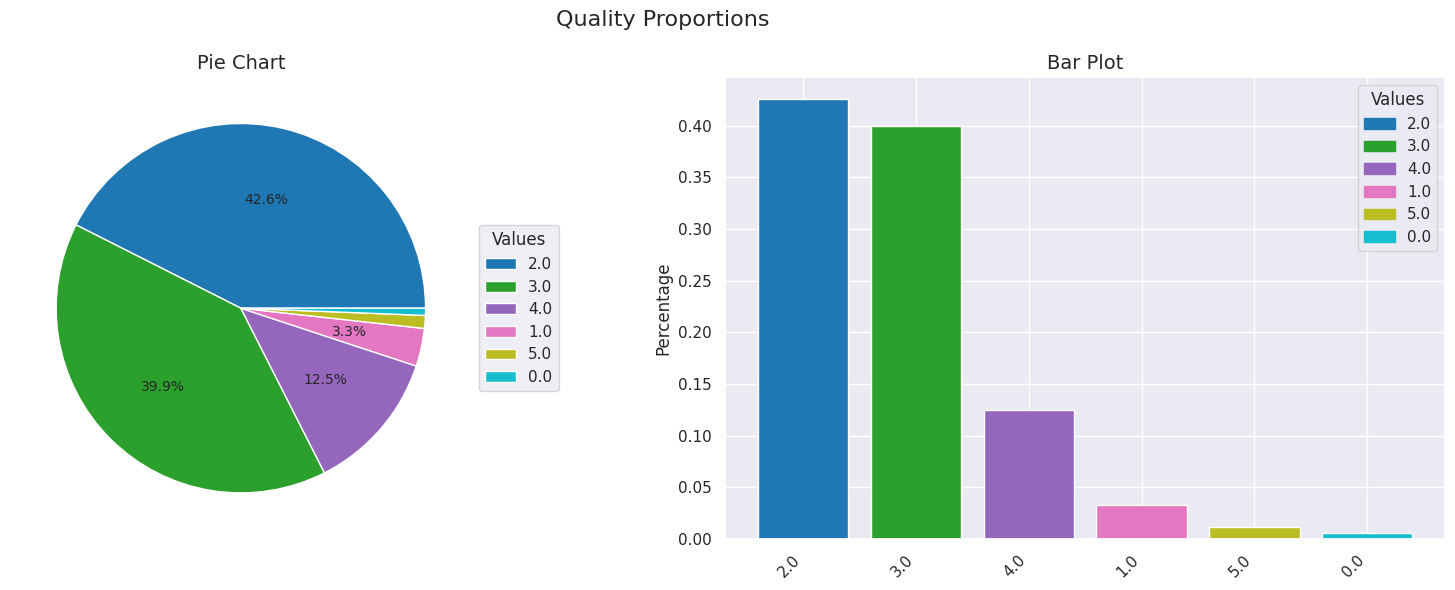

{'quality':     value  percentage
 0 2.00000     0.42553
 1 3.00000     0.39925
 2 4.00000     0.12453
 3 1.00000     0.03317
 4 5.00000     0.01126
 5 0.00000     0.00626}

In [154]:
value_counts_ratio(df,['quality'], plot = True)

In [155]:
value_counts_dfs = value_counts_ratio(df, cat_cols)
value_counts_dfs['quality']

value  percentage
0 2.00000     0.42553
1 3.00000     0.39925
2 4.00000     0.12453
3 1.00000     0.03317
4 5.00000     0.01126
5 0.00000     0.00626

In [156]:
value_counts_dfs = value_counts_ratio(df, cat_cols)
value_counts_dfs['quality']


value  percentage
0 2.00000     0.42553
1 3.00000     0.39925
2 4.00000     0.12453
3 1.00000     0.03317
4 5.00000     0.01126
5 0.00000     0.00626

In [157]:
def null_dataframe(dataframe, plot=False, verbose=False):
    if not isinstance(dataframe, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame")

    df_null = dataframe.isnull().sum().sort_values(ascending=False).to_frame(name='null_values')
    df_null.reset_index(inplace=True)
    df_null.rename(columns={'index': 'variables'}, inplace=True)

    variable_types = {col: 'Categorical' for col in cat_cols}
    variable_types.update({col: 'Numerical' for col in num_cols})
    variable_types.update({col: 'Categorical Cardinal' for col in cat_but_car})
    variable_types.update({col: 'Date' for col in date_cols})

    df_null['variable_type'] = df_null['variables'].map(variable_types)
    df_null['null_ratio'] = df_null['null_values'] / len(dataframe)

    null_variables = df_null[df_null['null_values'] != 0]['variables'].tolist()
    notnull_variables = df_null[df_null['null_values'] == 0]['variables'].tolist()

    if verbose:
        print(f'The null variables are: {null_variables}\n')
        print(f'The not null variables are: {notnull_variables}\n')
        print(df_null)

    if plot and null_variables:
        for var in null_variables:
            null_ratio = df_null[df_null['variables'] == var]['null_ratio'].values[0]
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
            fig.suptitle(f'Null Ratio for {var.capitalize()} Variable', fontsize=16)

            def autopct_format(pct):
                return f'{pct:.1f}%' if pct >= 2 else ''

            wedges, texts, autotexts = ax1.pie(
                [null_ratio, 1 - null_ratio],
                labels=None,
                autopct=autopct_format,
                colors=['#636EFA', '#EF553B'],
                textprops={'fontsize': 10}
            )
            ax1.set_title('Pie Chart', fontsize=14)
            ax1.legend(wedges, ['Null', 'Not Null'], title="Values", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

            x = ['Null', 'Not Null']
            y = [null_ratio, 1 - null_ratio]
            ax2.bar(x, y, color=['#636EFA', '#EF553B'])
            ax2.set_title('Bar Plot', fontsize=14)
            ax2.set_xlabel('')
            ax2.set_ylabel('Ratio')
            ax2.set_ylim(0, 1)

            for i, v in enumerate(y):
                ax2.text(i, v, f'{v:.2f}', ha='center', va='bottom')

            plt.tight_layout()
            plt.show()

    return df_null
null_df = null_dataframe(df)
null_df

variables  null_values variable_type  null_ratio
0   total sulfur dioxide            1     Numerical     0.00063
1                     pH            1     Numerical     0.00063
2                quality            1   Categorical     0.00063
3          fixed acidity            0     Numerical     0.00000
4       volatile acidity            0     Numerical     0.00000
5            citric acid            0     Numerical     0.00000
6         residual sugar            0     Numerical     0.00000
7              chlorides            0     Numerical     0.00000
8    free sulfur dioxide            0     Numerical     0.00000
9                density            0     Numerical     0.00000
10             sulphates            0     Numerical     0.00000
11               alcohol            0     Numerical     0.00000

In [158]:
df.dropna(inplace=True)

In [159]:
def null_dataframe(dataframe, plot=False, verbose=False):
    if not isinstance(dataframe, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame")

    df_null = dataframe.isnull().sum().sort_values(ascending=False).to_frame(name='null_values')
    df_null.reset_index(inplace=True)
    df_null.rename(columns={'index': 'variables'}, inplace=True)

    variable_types = {col: 'Categorical' for col in cat_cols}
    variable_types.update({col: 'Numerical' for col in num_cols})
    variable_types.update({col: 'Categorical Cardinal' for col in cat_but_car})
    variable_types.update({col: 'Date' for col in date_cols})

    df_null['variable_type'] = df_null['variables'].map(variable_types)
    df_null['null_ratio'] = df_null['null_values'] / len(dataframe)

    null_variables = df_null[df_null['null_values'] != 0]['variables'].tolist()
    notnull_variables = df_null[df_null['null_values'] == 0]['variables'].tolist()

    if verbose:
        print(f'The null variables are: {null_variables}\n')
        print(f'The not null variables are: {notnull_variables}\n')
        print(df_null)

    if plot and null_variables:
        for var in null_variables:
            null_ratio = df_null[df_null['variables'] == var]['null_ratio'].values[0]
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
            fig.suptitle(f'Null Ratio for {var.capitalize()} Variable', fontsize=16)

            def autopct_format(pct):
                return f'{pct:.1f}%' if pct >= 2 else ''

            wedges, texts, autotexts = ax1.pie(
                [null_ratio, 1 - null_ratio],
                labels=None,
                autopct=autopct_format,
                colors=['#636EFA', '#EF553B'],
                textprops={'fontsize': 10}
            )
            ax1.set_title('Pie Chart', fontsize=14)
            ax1.legend(wedges, ['Null', 'Not Null'], title="Values", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

            x = ['Null', 'Not Null']
            y = [null_ratio, 1 - null_ratio]
            ax2.bar(x, y, color=['#636EFA', '#EF553B'])
            ax2.set_title('Bar Plot', fontsize=14)
            ax2.set_xlabel('')
            ax2.set_ylabel('Ratio')
            ax2.set_ylim(0, 1)

            for i, v in enumerate(y):
                ax2.text(i, v, f'{v:.2f}', ha='center', va='bottom')

            plt.tight_layout()
            plt.show()

    return df_null
null_df = null_dataframe(df)
null_df

variables  null_values variable_type  null_ratio
0          fixed acidity            0     Numerical     0.00000
1       volatile acidity            0     Numerical     0.00000
2            citric acid            0     Numerical     0.00000
3         residual sugar            0     Numerical     0.00000
4              chlorides            0     Numerical     0.00000
5    free sulfur dioxide            0     Numerical     0.00000
6   total sulfur dioxide            0     Numerical     0.00000
7                density            0     Numerical     0.00000
8                     pH            0     Numerical     0.00000
9              sulphates            0     Numerical     0.00000
10               alcohol            0     Numerical     0.00000
11               quality            0   Categorical     0.00000

Summary for fixed acidity:
count   1596.00000
mean       8.32137
std        1.74212
min        4.60000
1%         5.20000
5%         6.10000
10%        6.50000
25%        7.10000
50%        7.90000
75%        9.20000
90%       10.70000
95%       11.80000
99%       13.30000
max       15.90000
Name: fixed acidity, dtype: float64
Skewness: 0.98
Kurtosis: 1.13
Zero count: 0 (0.00%)
Negative count: 0 (0.00%)
Missing values: 0 (0.00%)


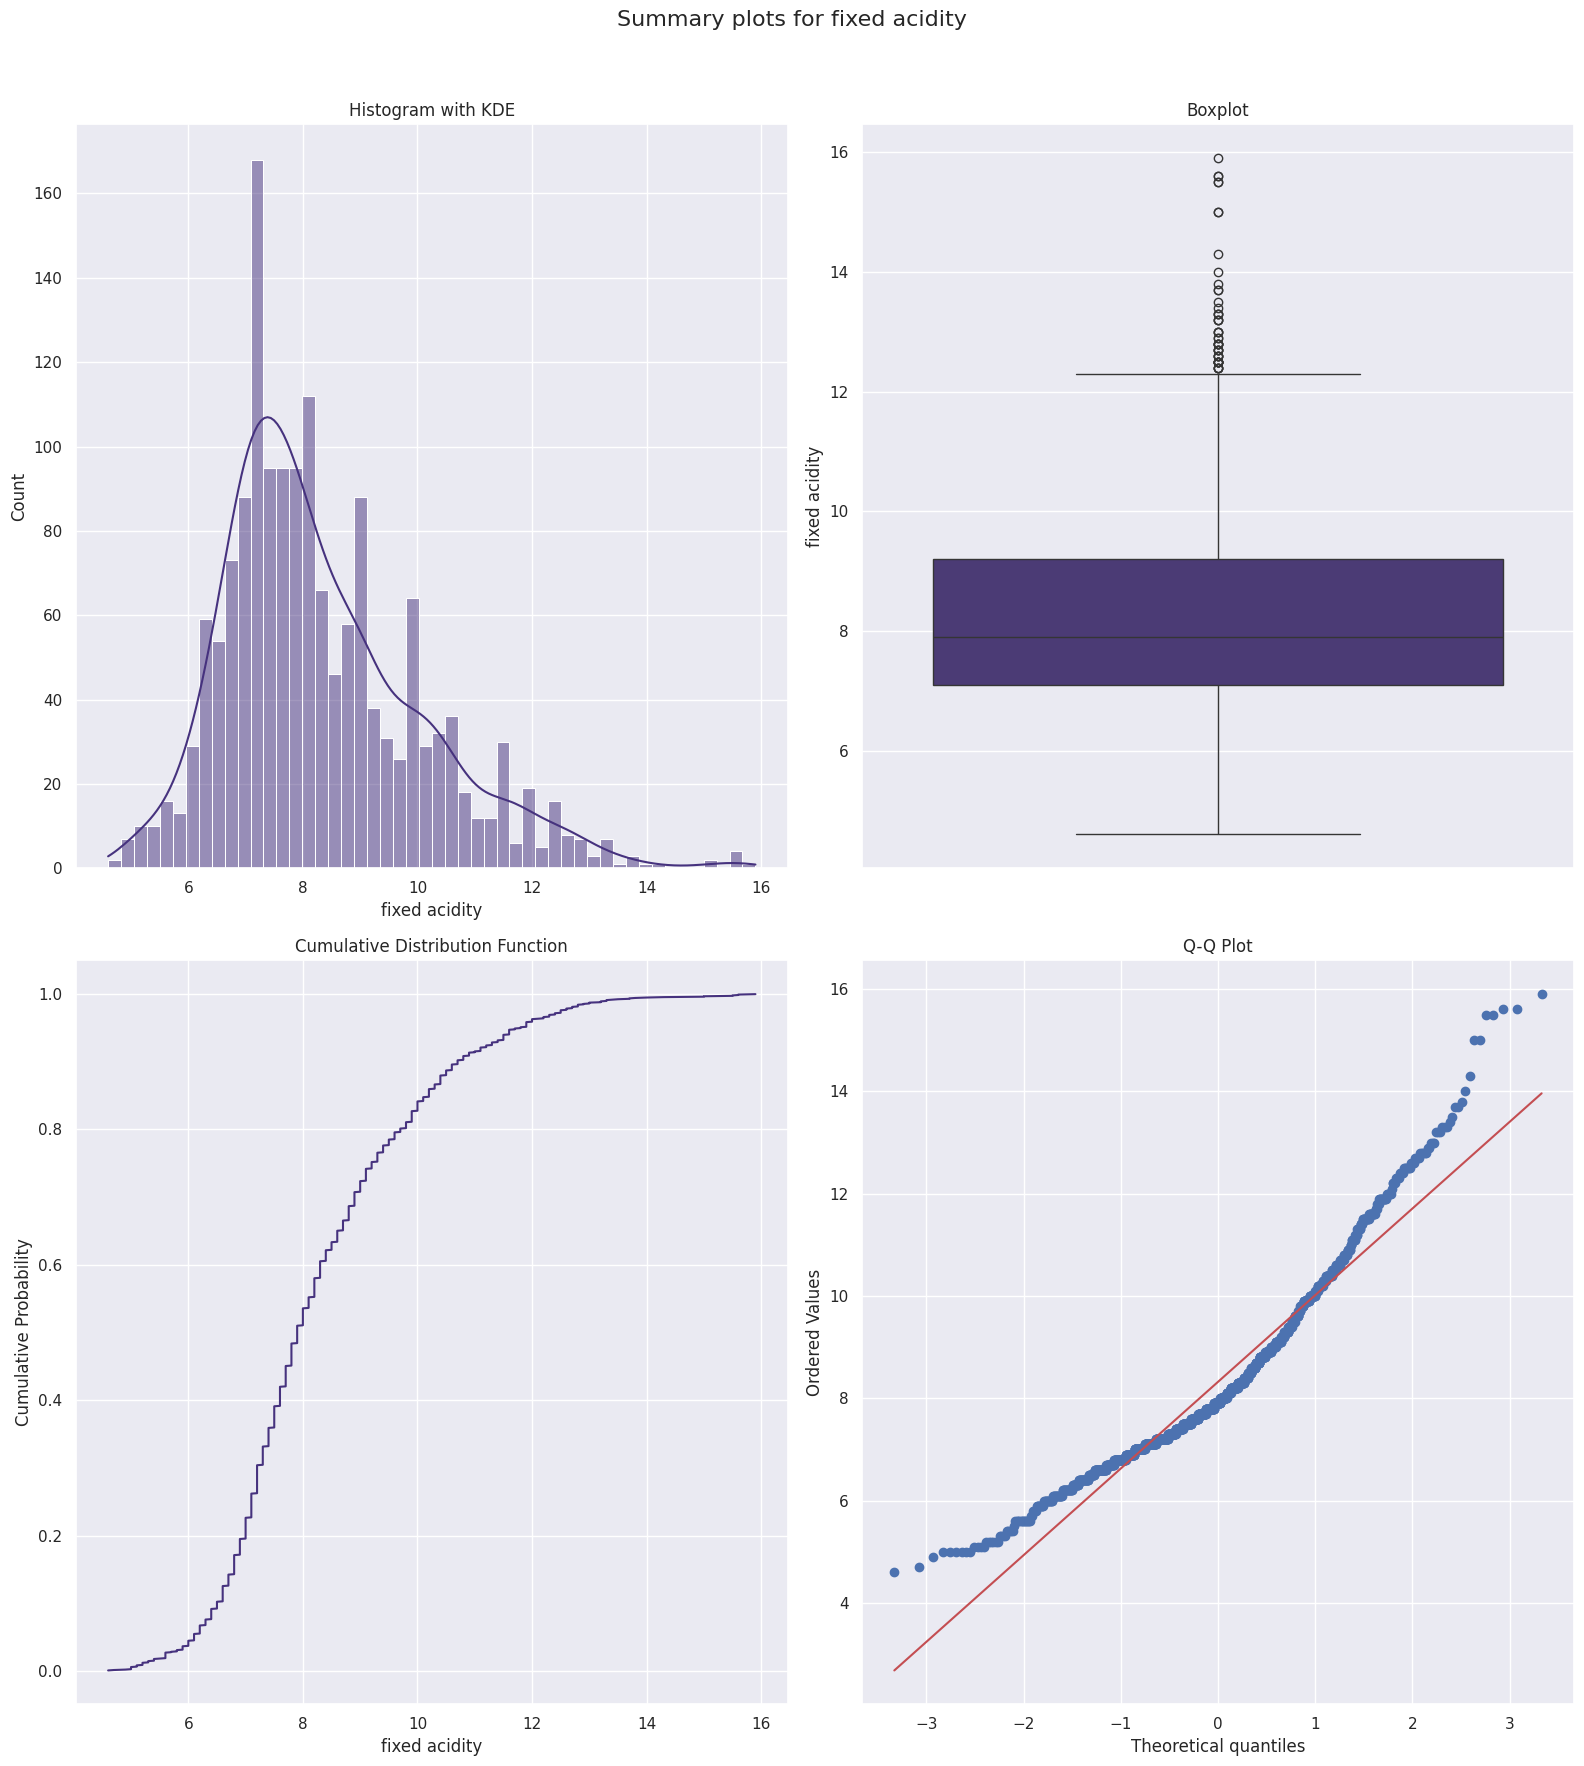

----------------------------------------------------
Summary for volatile acidity:
count   1596.00000
mean       0.52767
std        0.17915
min        0.12000
1%         0.19000
5%         0.27000
10%        0.31000
25%        0.39000
50%        0.52000
75%        0.64000
90%        0.74500
95%        0.84000
99%        1.02000
max        1.58000
Name: volatile acidity, dtype: float64
Skewness: 0.67
Kurtosis: 1.23
Zero count: 0 (0.00%)
Negative count: 0 (0.00%)
Missing values: 0 (0.00%)


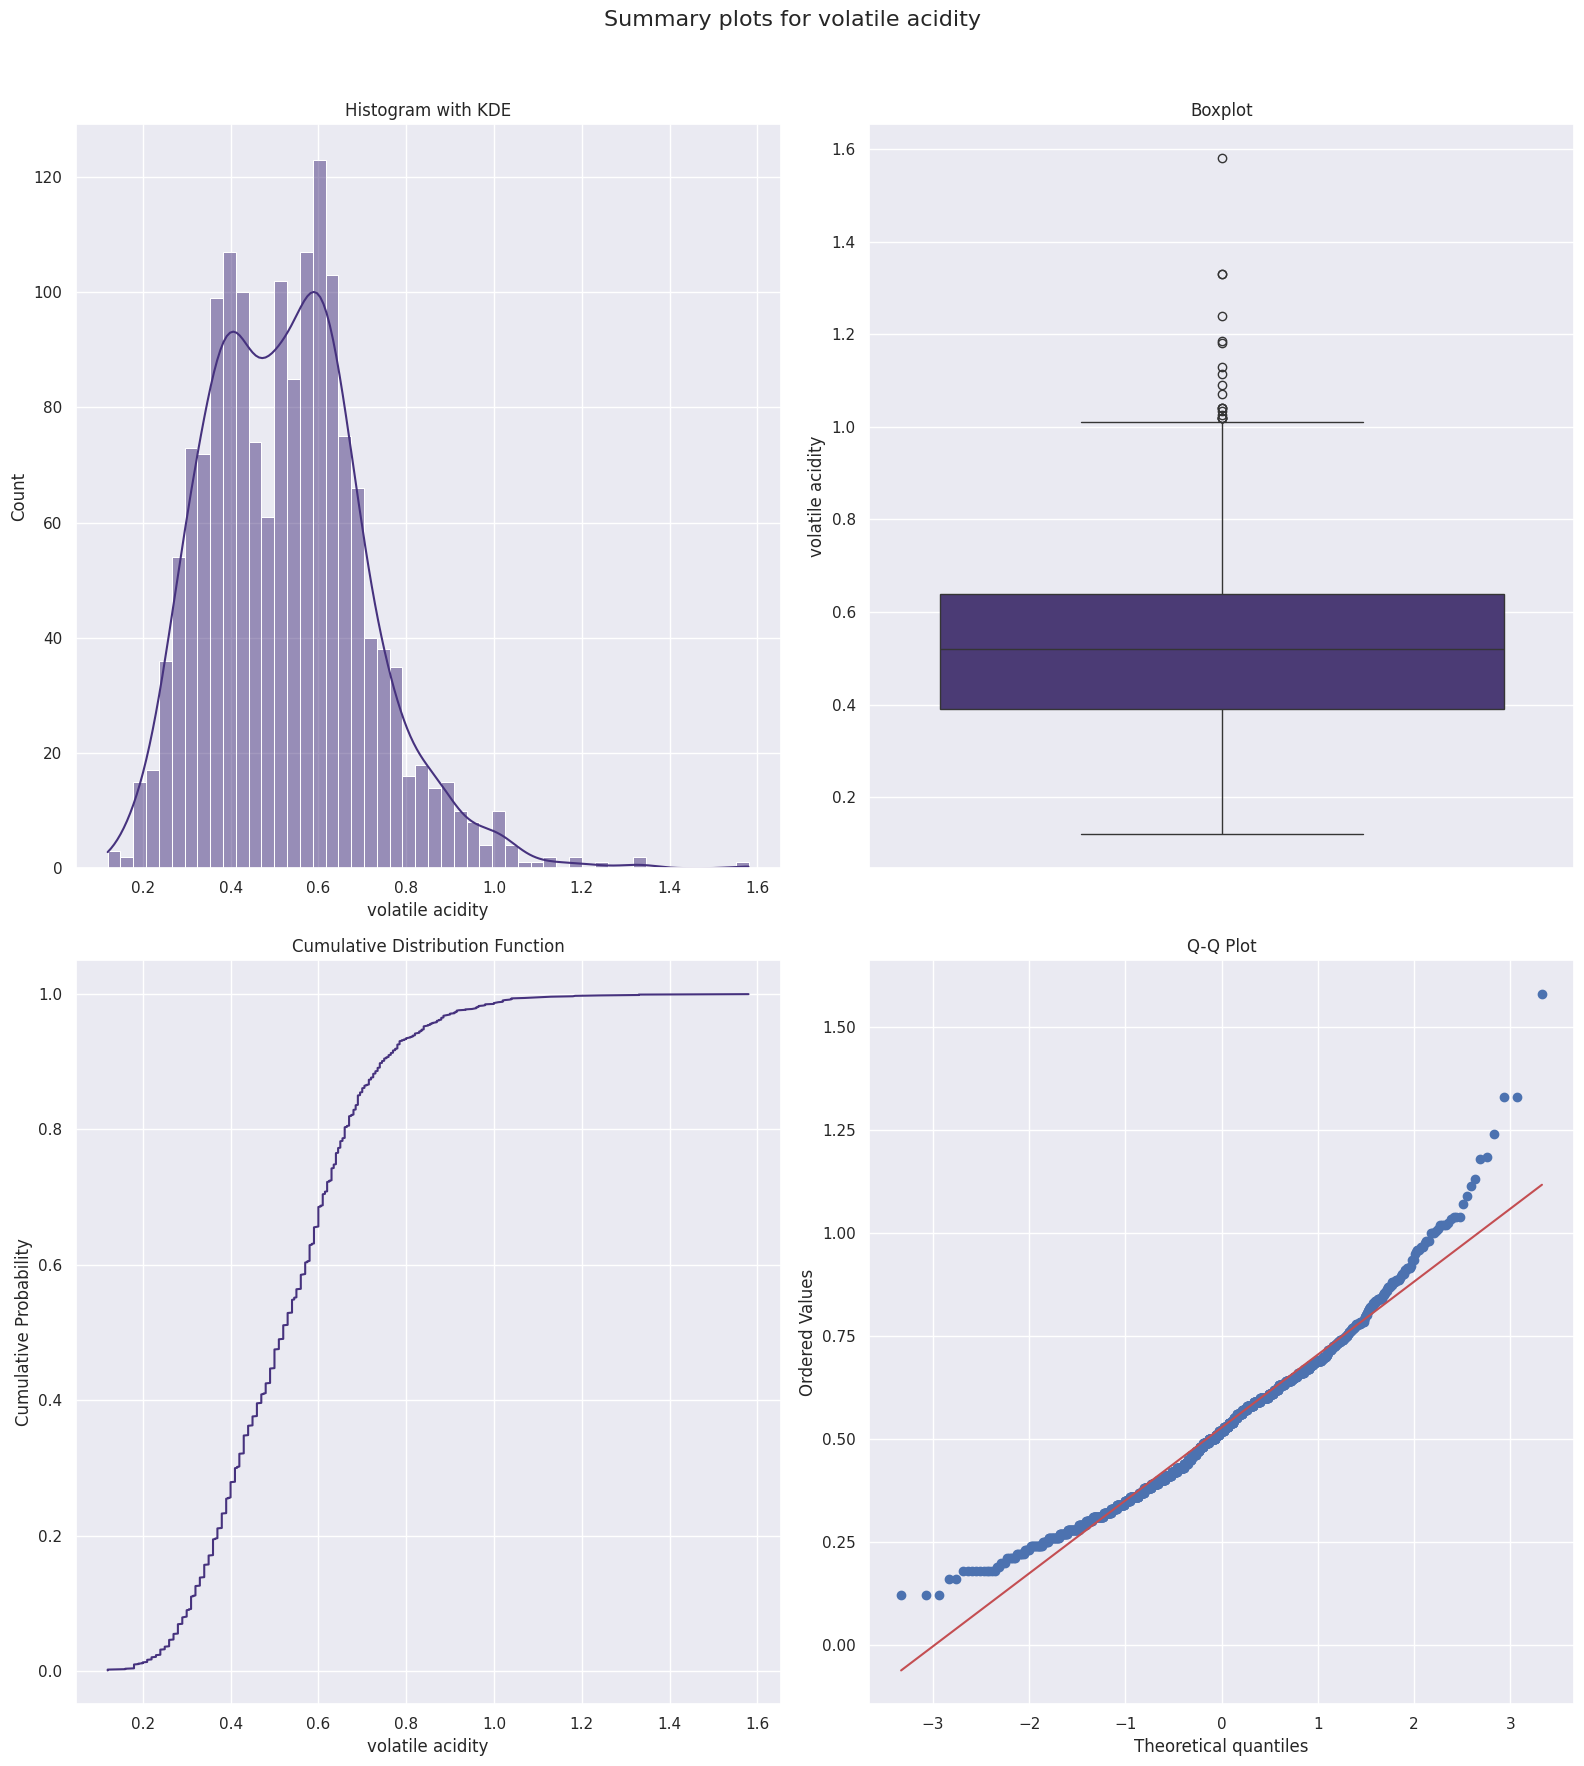

----------------------------------------------------
Summary for citric acid:
count   1596.00000
mean       0.27113
std        0.19485
min        0.00000
1%         0.00000
5%         0.00000
10%        0.01000
25%        0.09000
50%        0.26000
75%        0.42000
90%        0.52500
95%        0.60000
99%        0.70050
max        1.00000
Name: citric acid, dtype: float64
Skewness: 0.32
Kurtosis: -0.79
Zero count: 131 (8.21%)
Negative count: 0 (0.00%)
Missing values: 0 (0.00%)


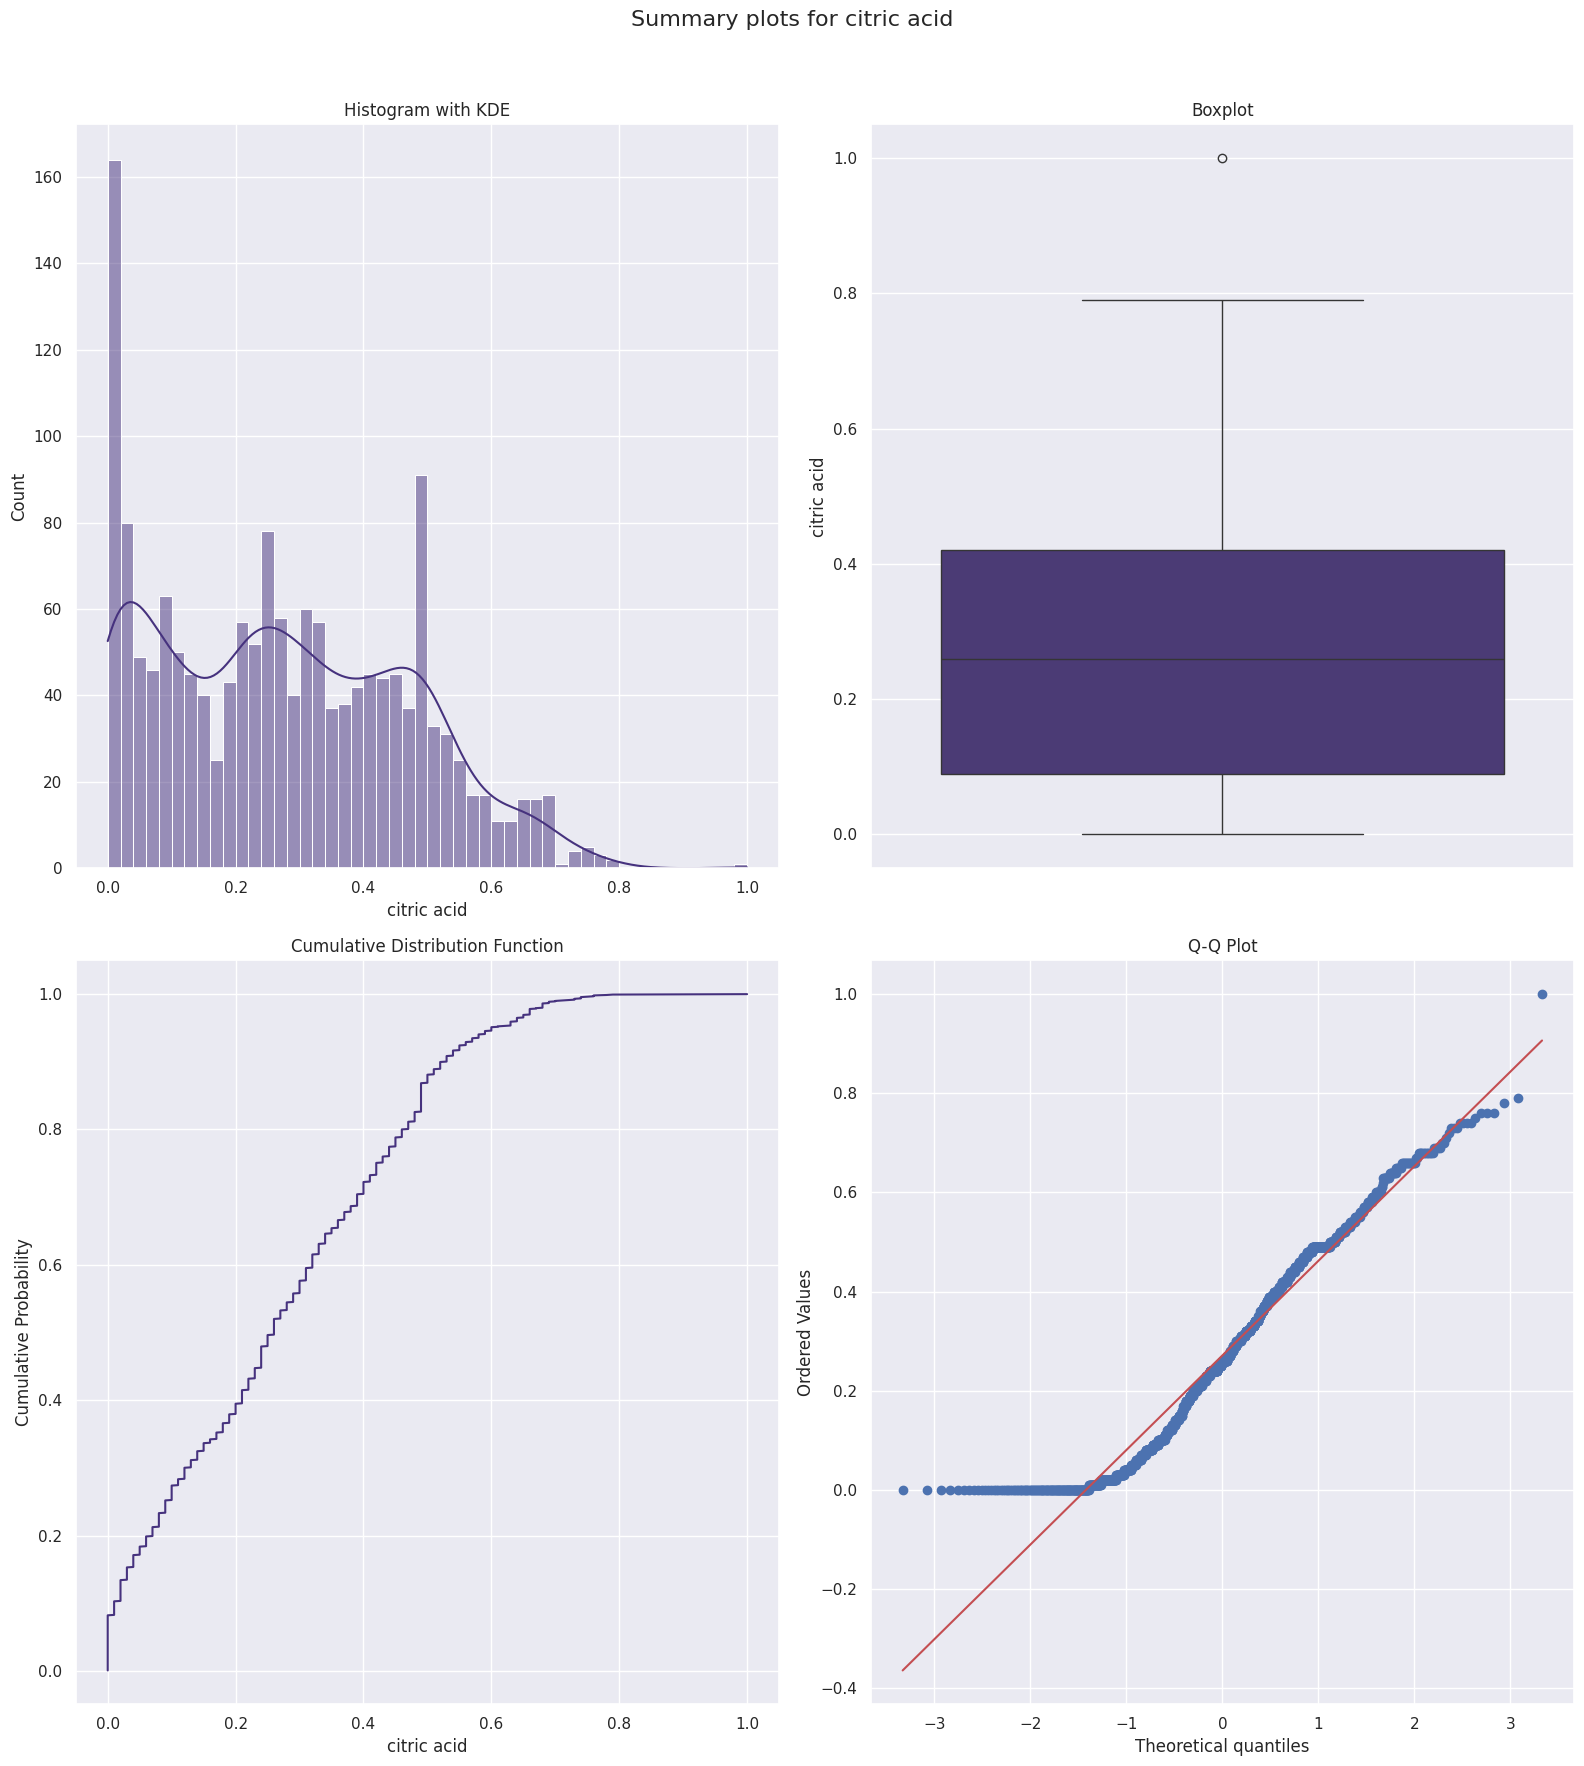

----------------------------------------------------
Summary for residual sugar:
count   1596.00000
mean       2.53694
std        1.40834
min        0.90000
1%         1.40000
5%         1.57500
10%        1.70000
25%        1.90000
50%        2.20000
75%        2.60000
90%        3.60000
95%        5.10000
99%        8.31500
max       15.50000
Name: residual sugar, dtype: float64
Skewness: 4.56
Kurtosis: 28.82
Zero count: 0 (0.00%)
Negative count: 0 (0.00%)
Missing values: 0 (0.00%)


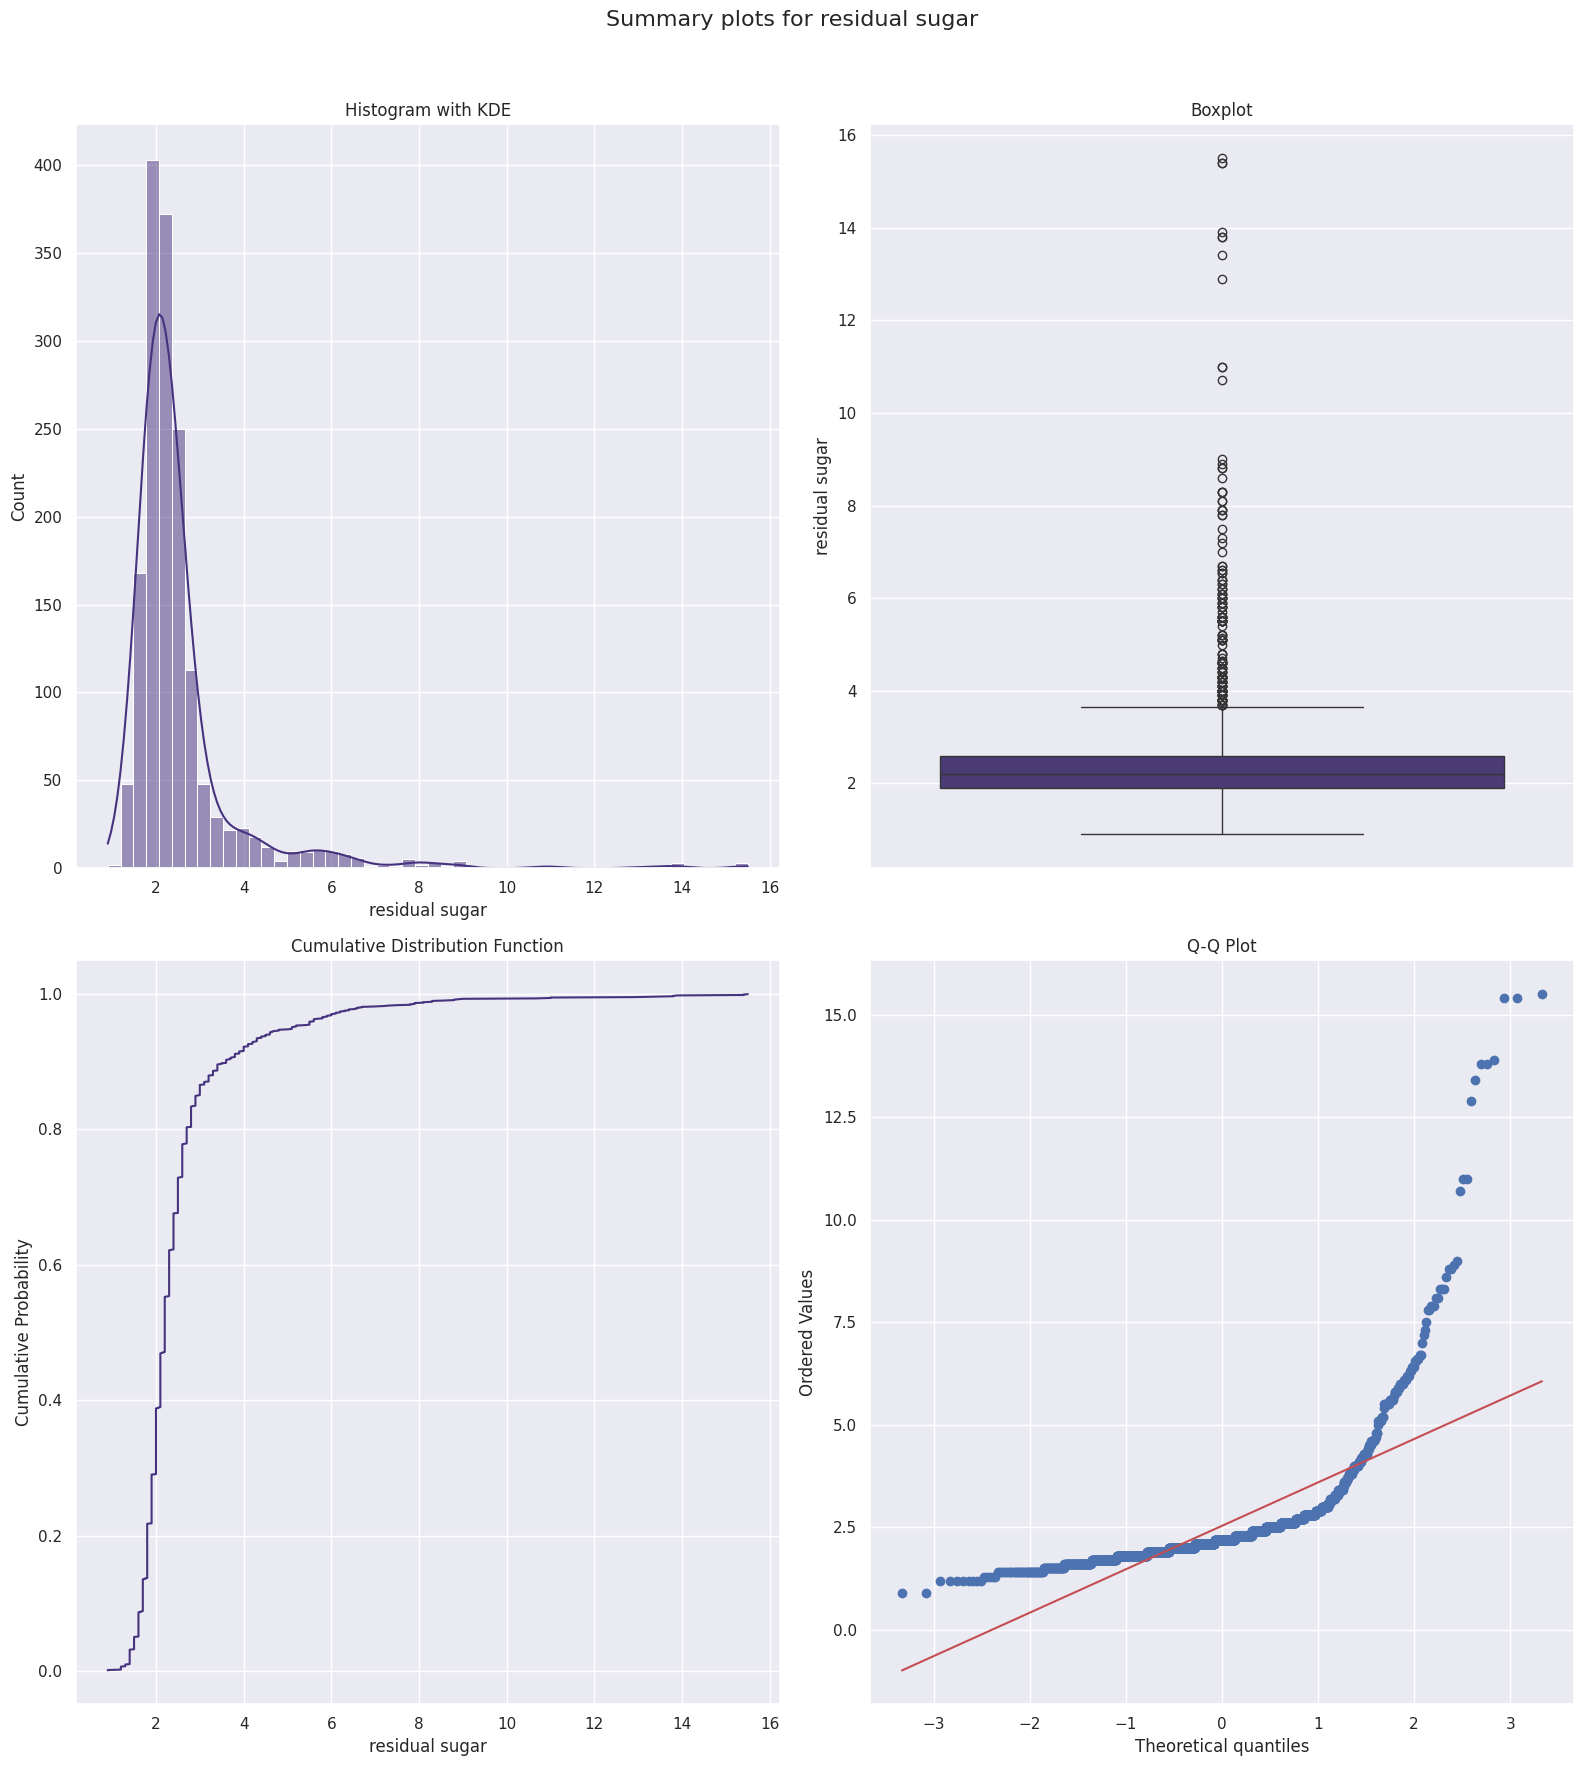

----------------------------------------------------
Summary for chlorides:
count   1596.00000
mean       0.08749
std        0.04711
min        0.01200
1%         0.04295
5%         0.05400
10%        0.06000
25%        0.07000
50%        0.07900
75%        0.09000
90%        0.10900
95%        0.12625
99%        0.36040
max        0.61100
Name: chlorides, dtype: float64
Skewness: 5.67
Kurtosis: 41.63
Zero count: 0 (0.00%)
Negative count: 0 (0.00%)
Missing values: 0 (0.00%)


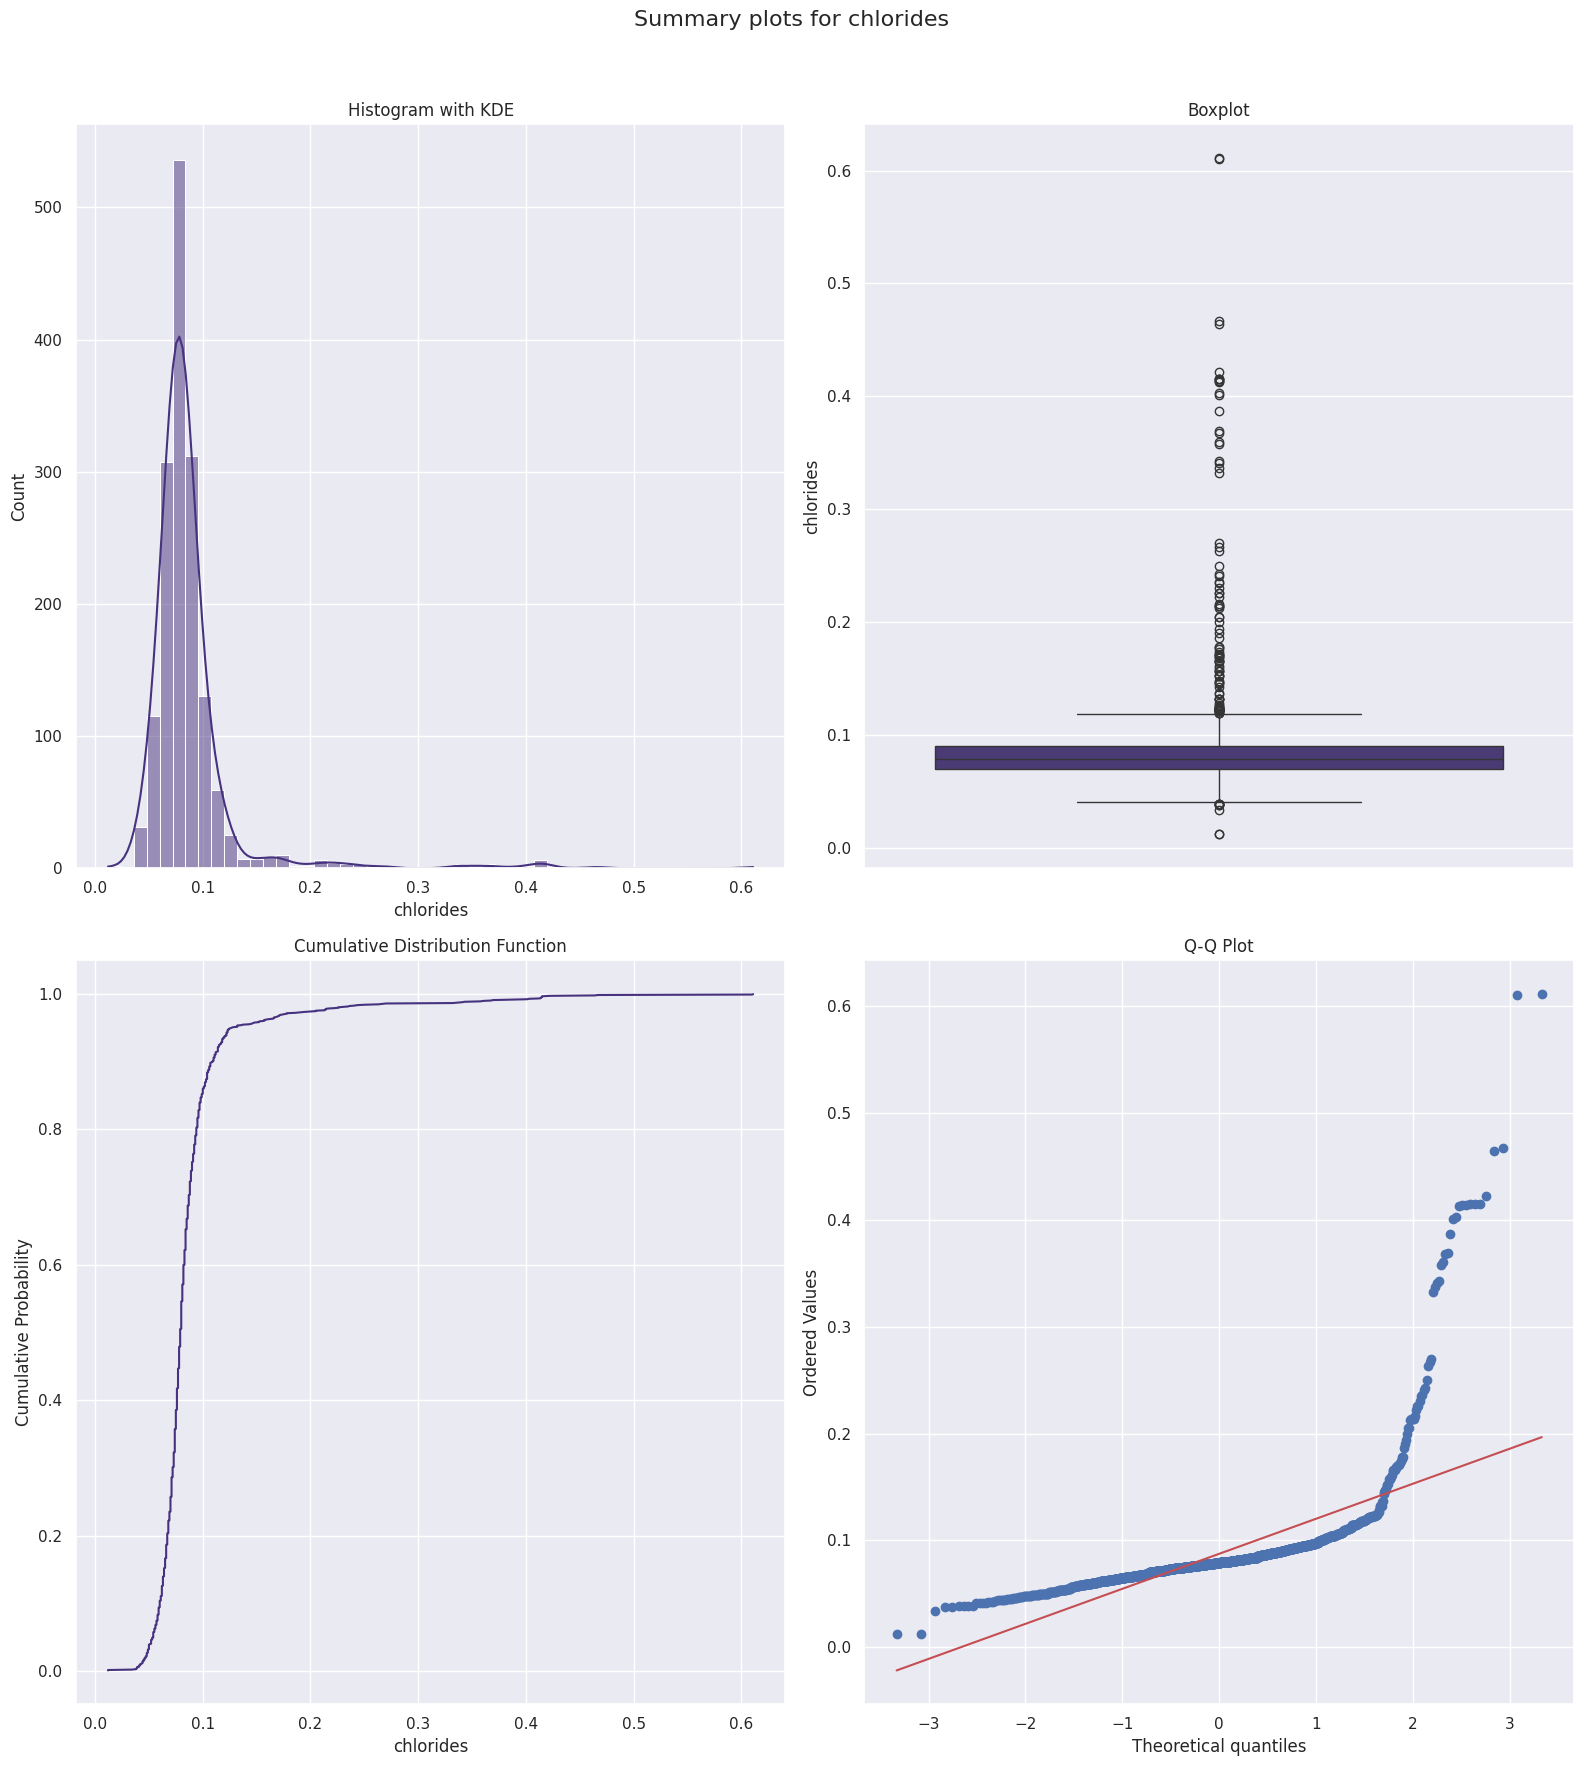

----------------------------------------------------
Summary for free sulfur dioxide:
count   1596.00000
mean      15.88221
std       10.46738
min        1.00000
1%         3.00000
5%         4.00000
10%        5.00000
25%        7.00000
50%       14.00000
75%       21.00000
90%       31.00000
95%       35.00000
99%       50.05000
max       72.00000
Name: free sulfur dioxide, dtype: float64
Skewness: 1.25
Kurtosis: 2.02
Zero count: 0 (0.00%)
Negative count: 0 (0.00%)
Missing values: 0 (0.00%)


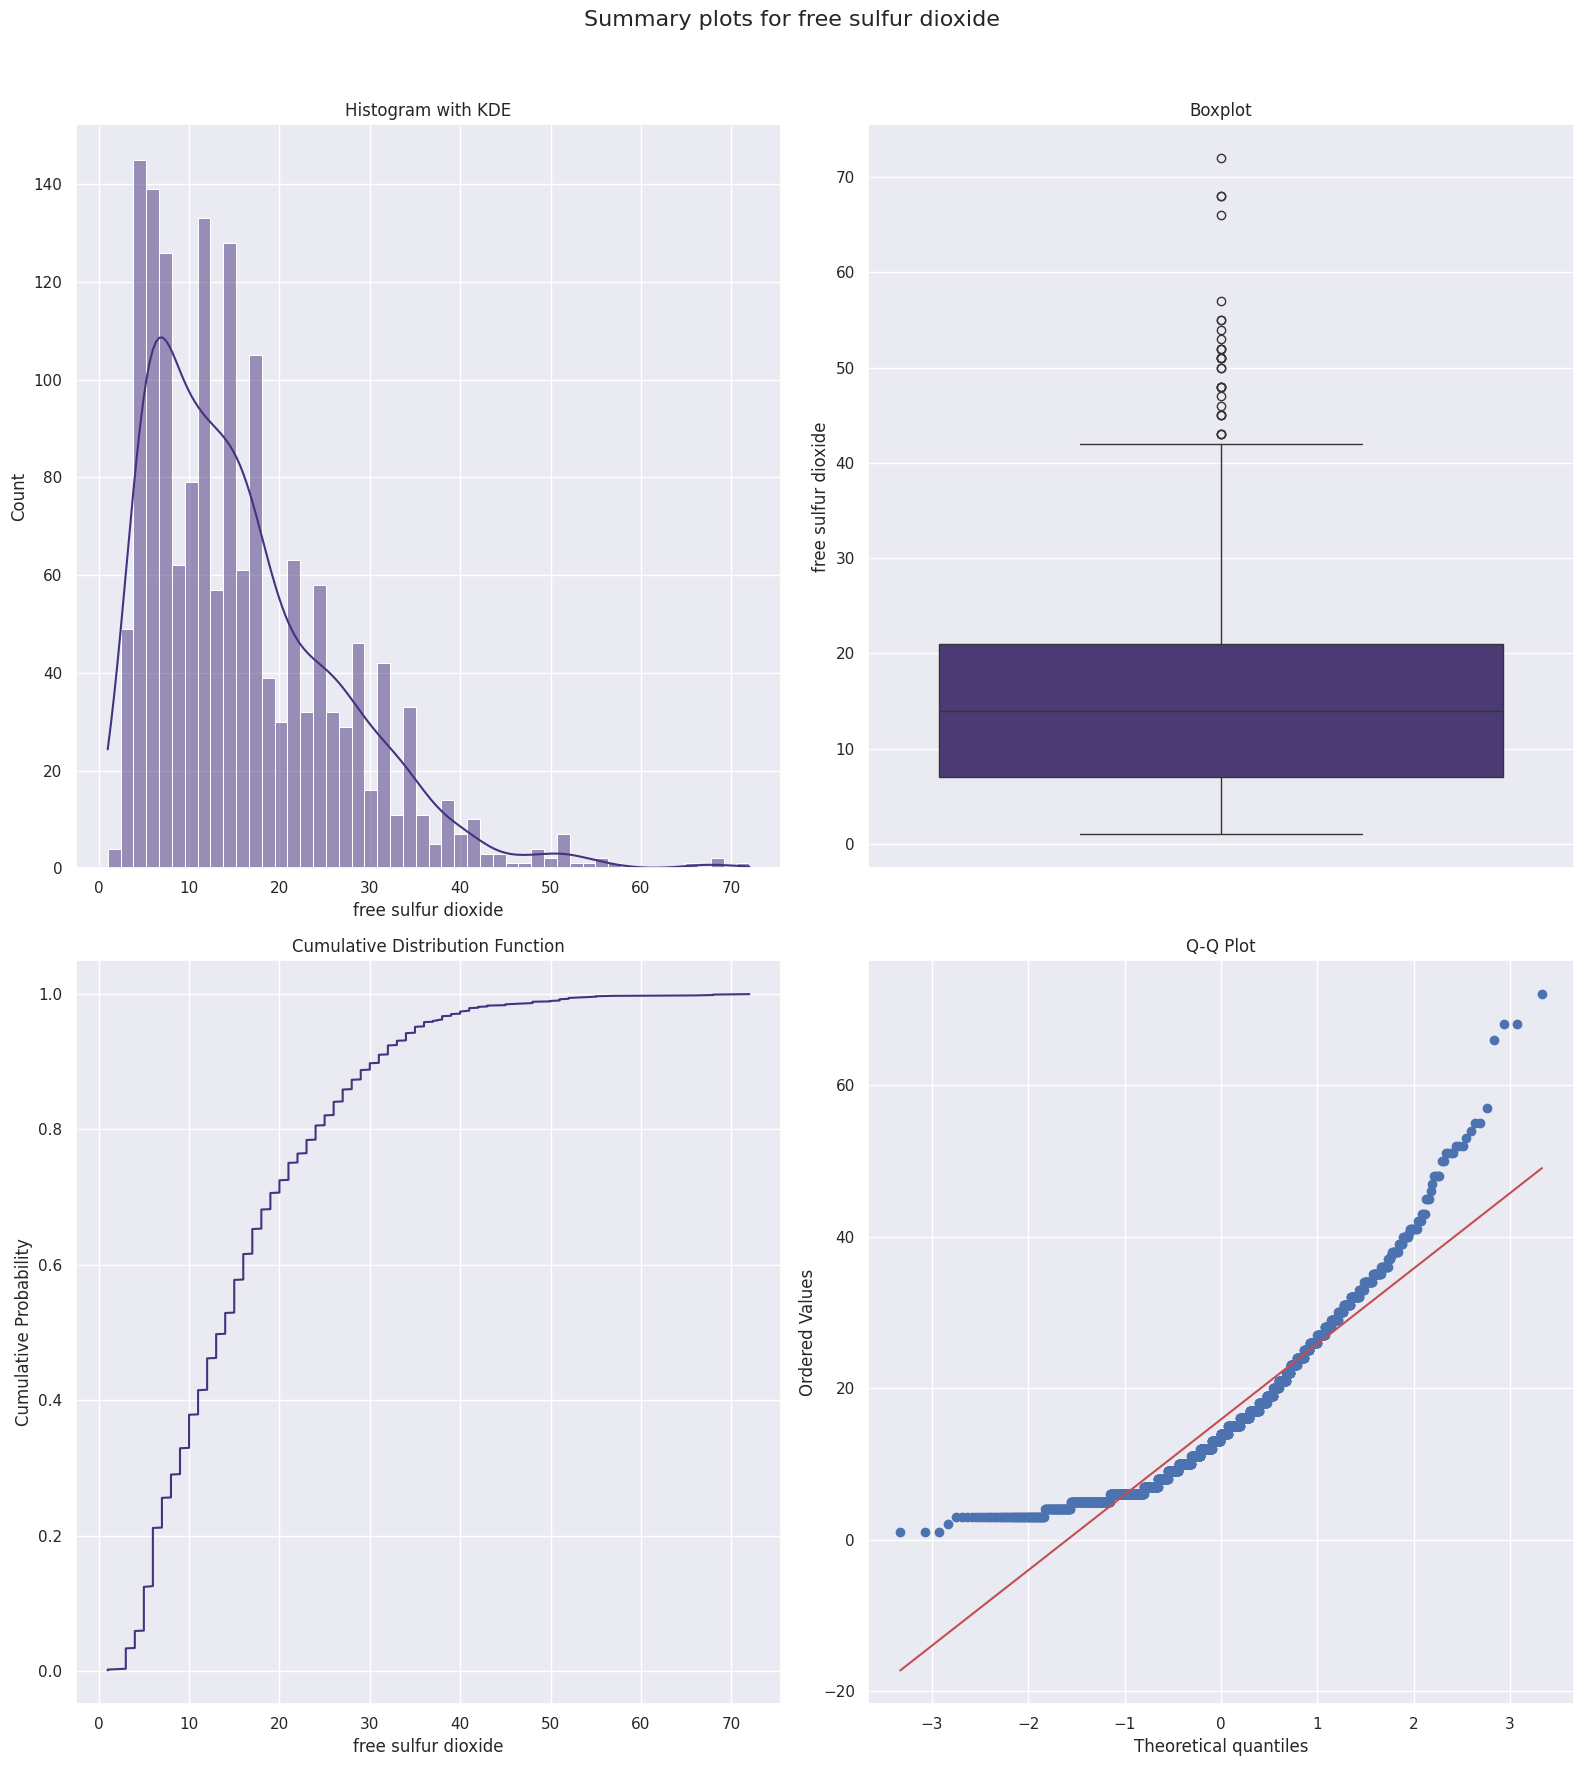

----------------------------------------------------
Summary for total sulfur dioxide:
count   1596.00000
mean      46.43108
std       32.89307
min        6.00000
1%         8.00000
5%        11.00000
10%       14.00000
25%       22.00000
50%       38.00000
75%       62.00000
90%       93.00000
95%      112.25000
99%      145.00000
max      289.00000
Name: total sulfur dioxide, dtype: float64
Skewness: 1.52
Kurtosis: 3.83
Zero count: 0 (0.00%)
Negative count: 0 (0.00%)
Missing values: 0 (0.00%)


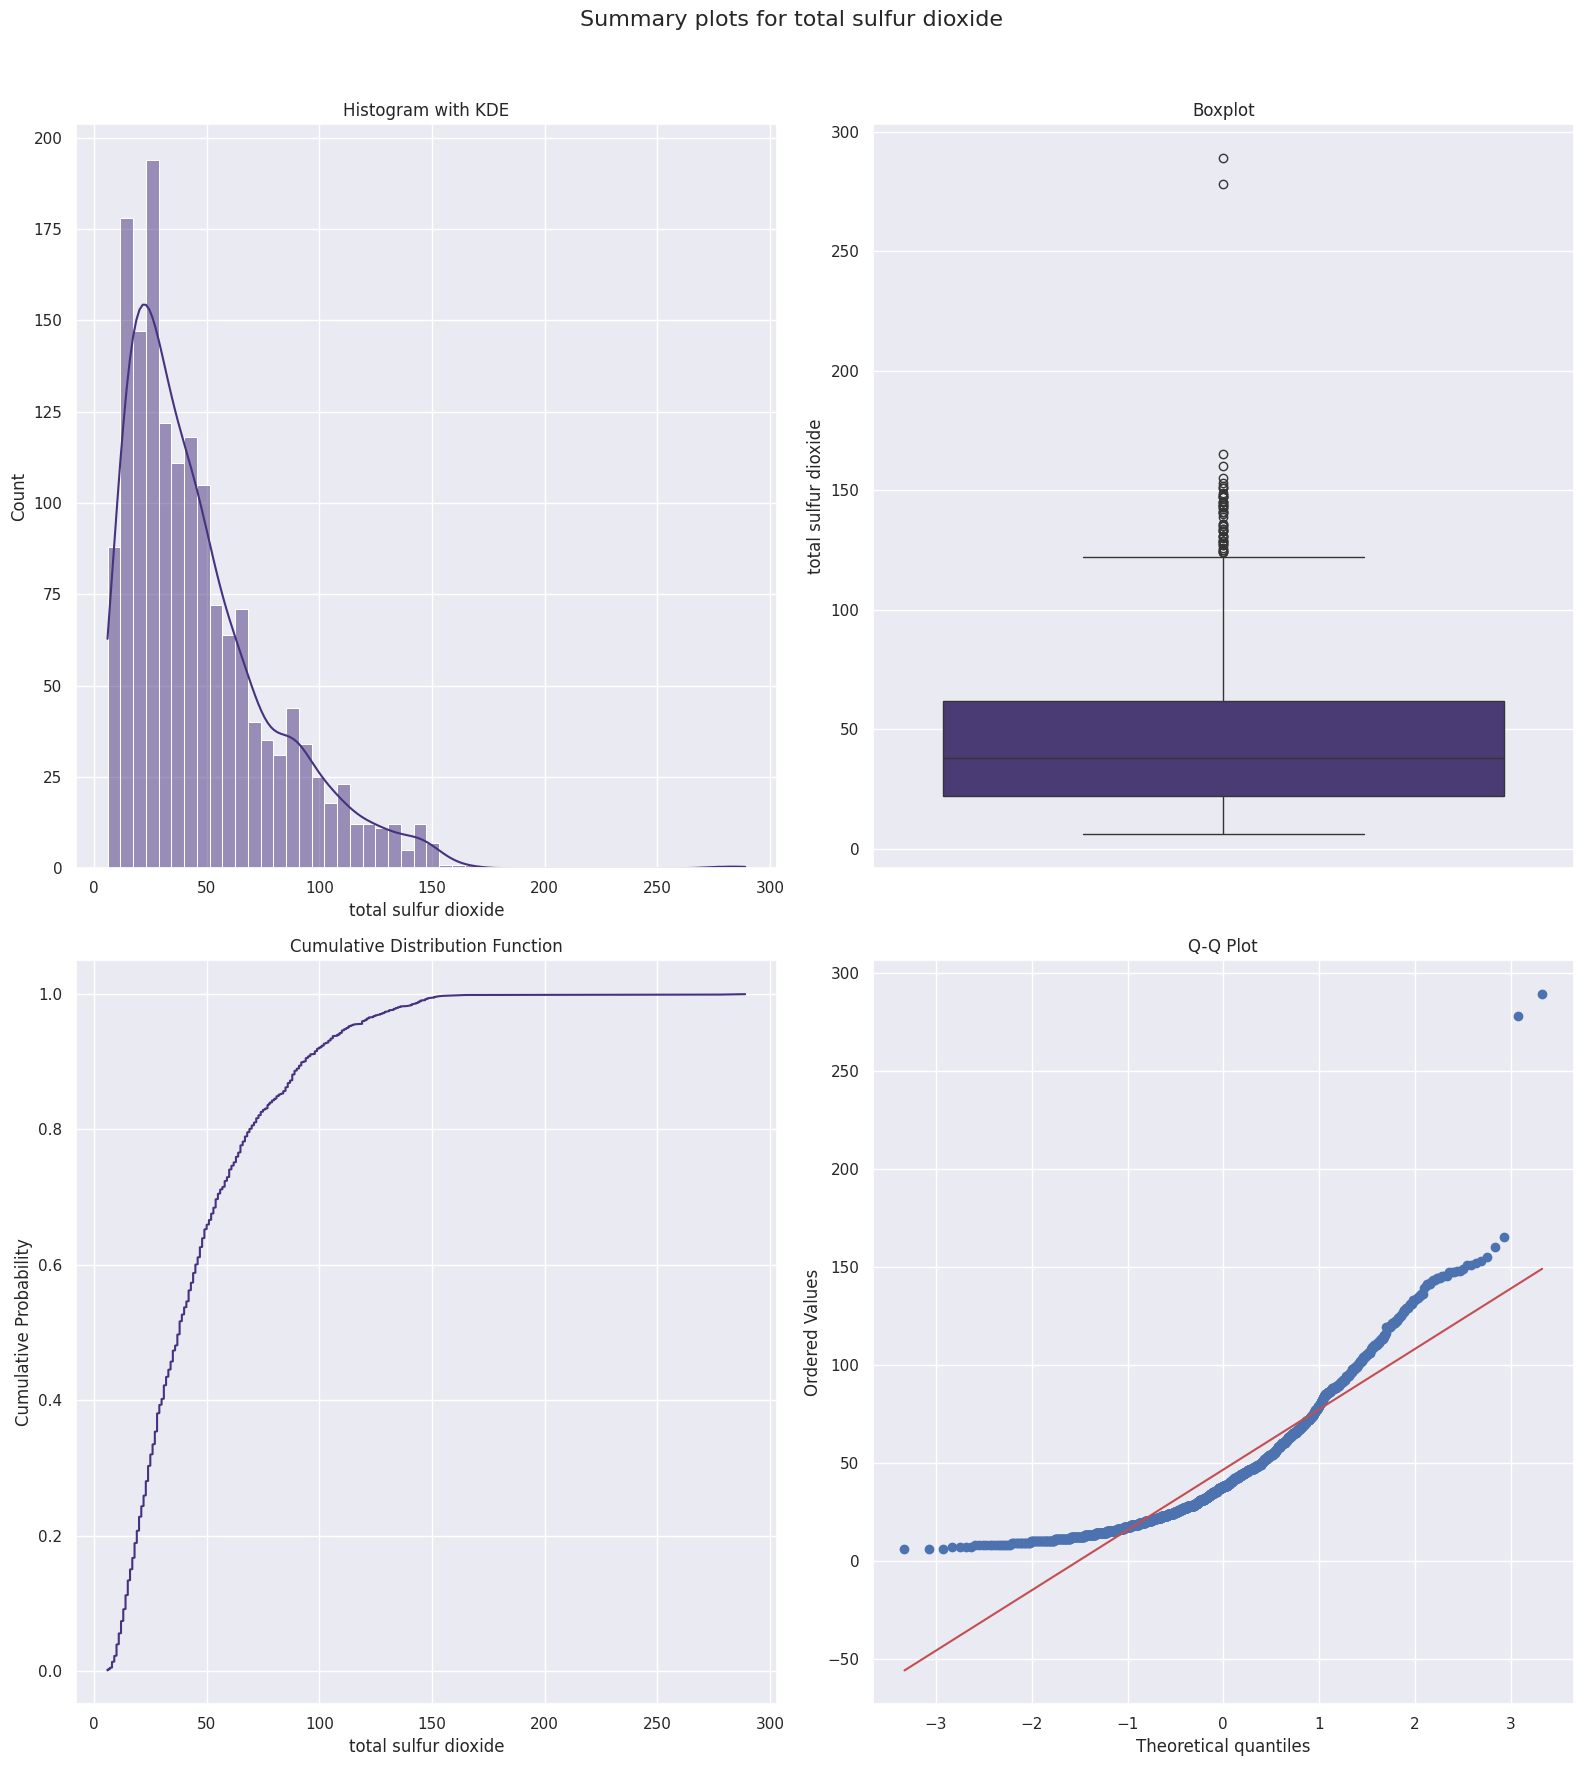

----------------------------------------------------
Summary for density:
count   1596.00000
mean       0.99675
std        0.00189
min        0.99007
1%         0.99182
5%         0.99360
10%        0.99455
25%        0.99560
50%        0.99674
75%        0.99784
90%        0.99914
95%        1.00000
99%        1.00151
max        1.00369
Name: density, dtype: float64
Skewness: 0.07
Kurtosis: 0.93
Zero count: 0 (0.00%)
Negative count: 0 (0.00%)
Missing values: 0 (0.00%)


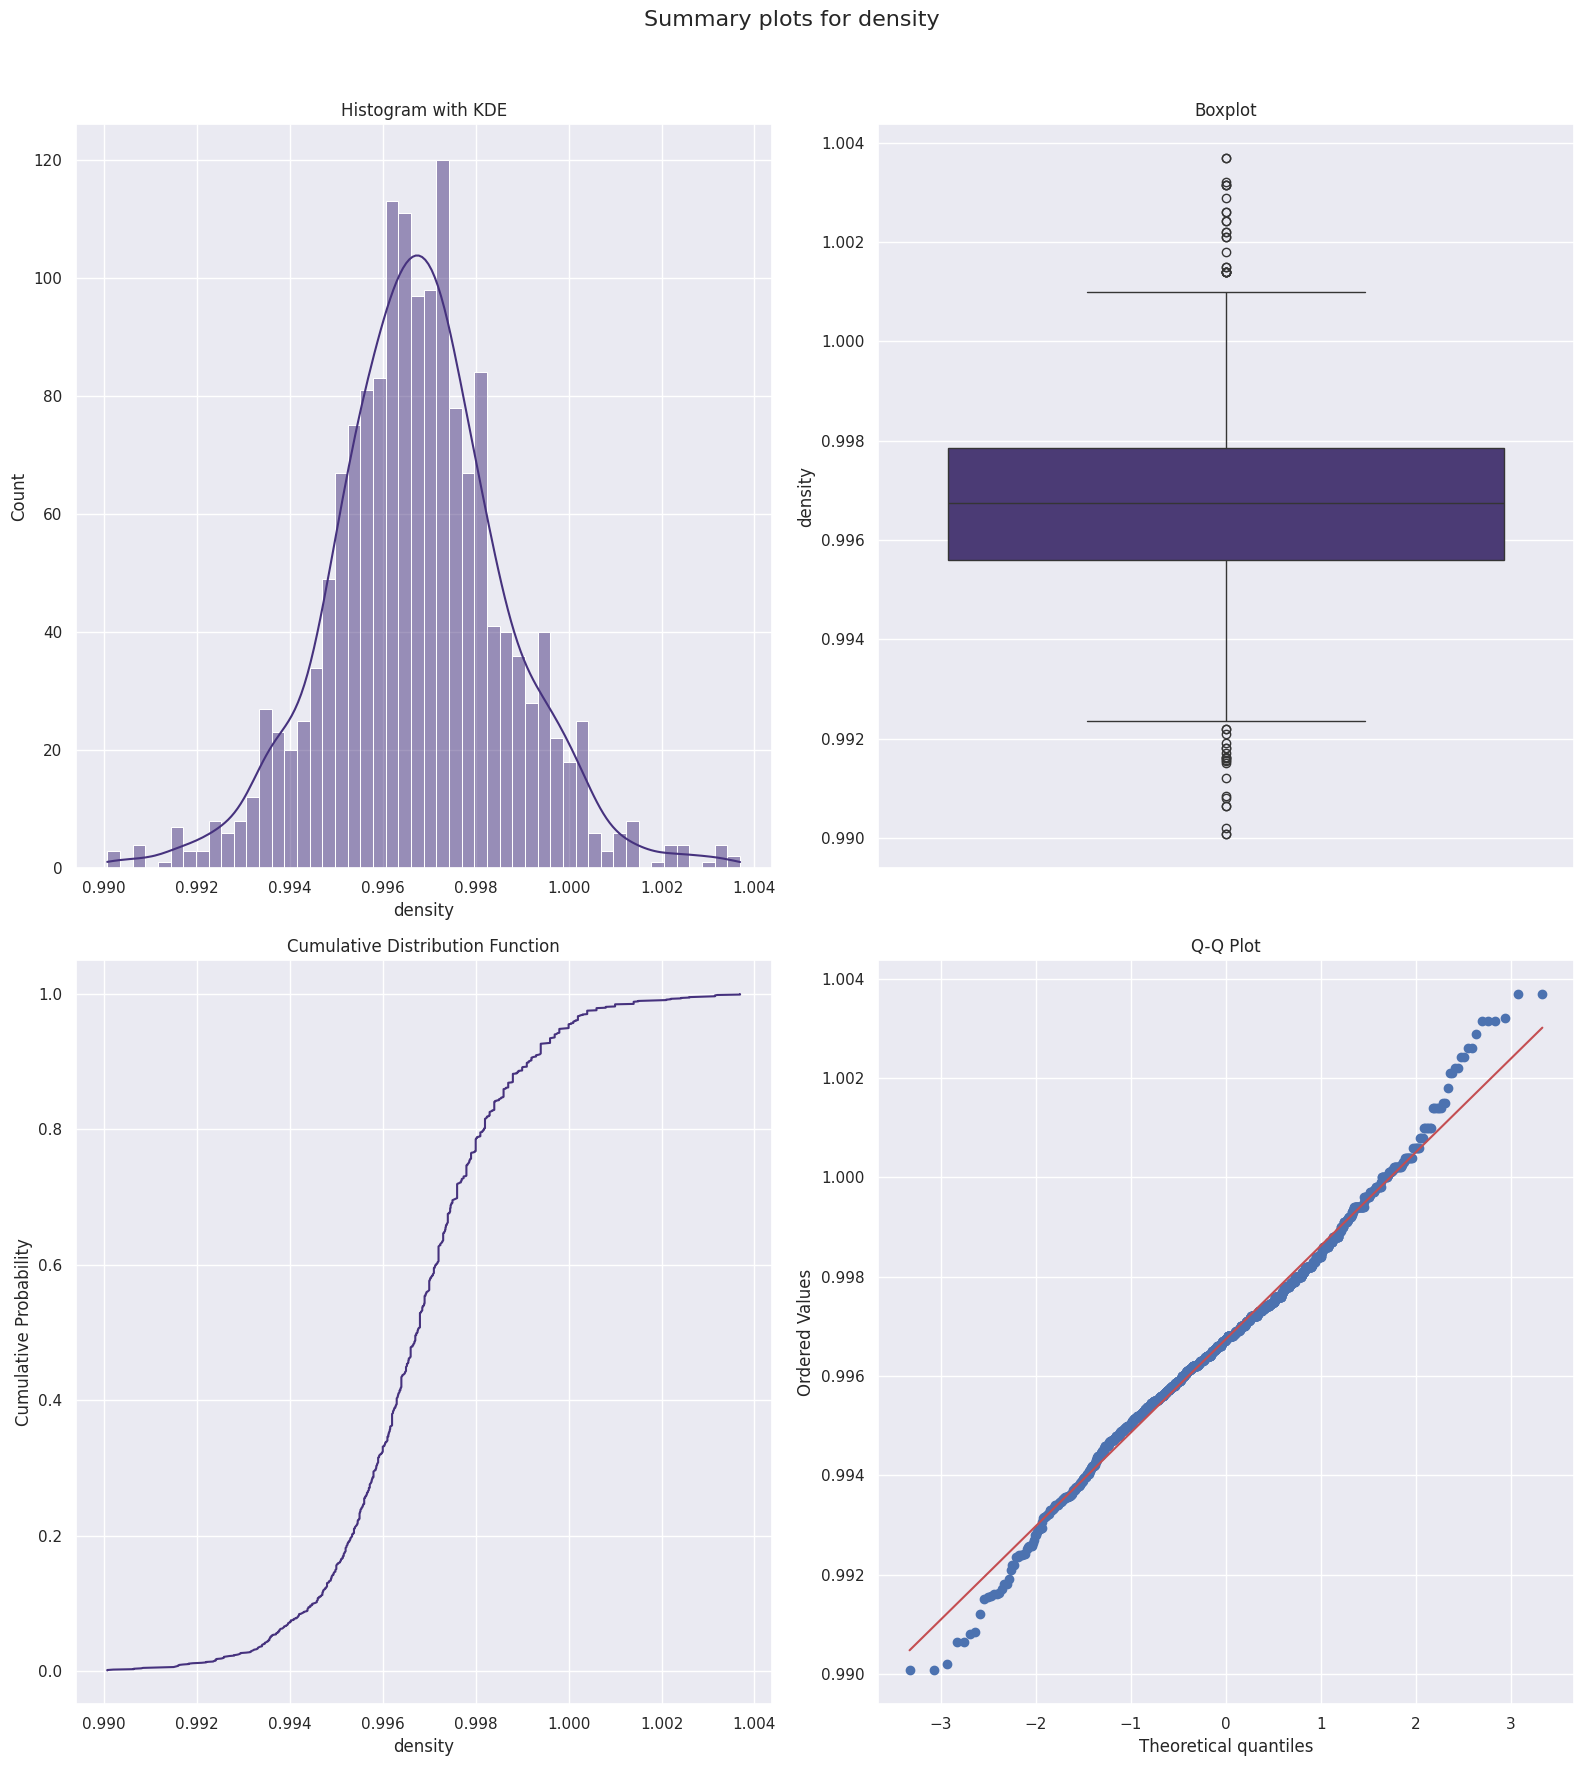

----------------------------------------------------
Summary for pH:
count   1596.00000
mean       3.49872
std        0.08030
min        2.74000
1%         3.15000
5%         3.32750
10%        3.50500
25%        3.52000
50%        3.52000
75%        3.52000
90%        3.52000
95%        3.52000
99%        3.53000
max        3.90000
Name: pH, dtype: float64
Skewness: -3.77
Kurtosis: 18.88
Zero count: 0 (0.00%)
Negative count: 0 (0.00%)
Missing values: 0 (0.00%)


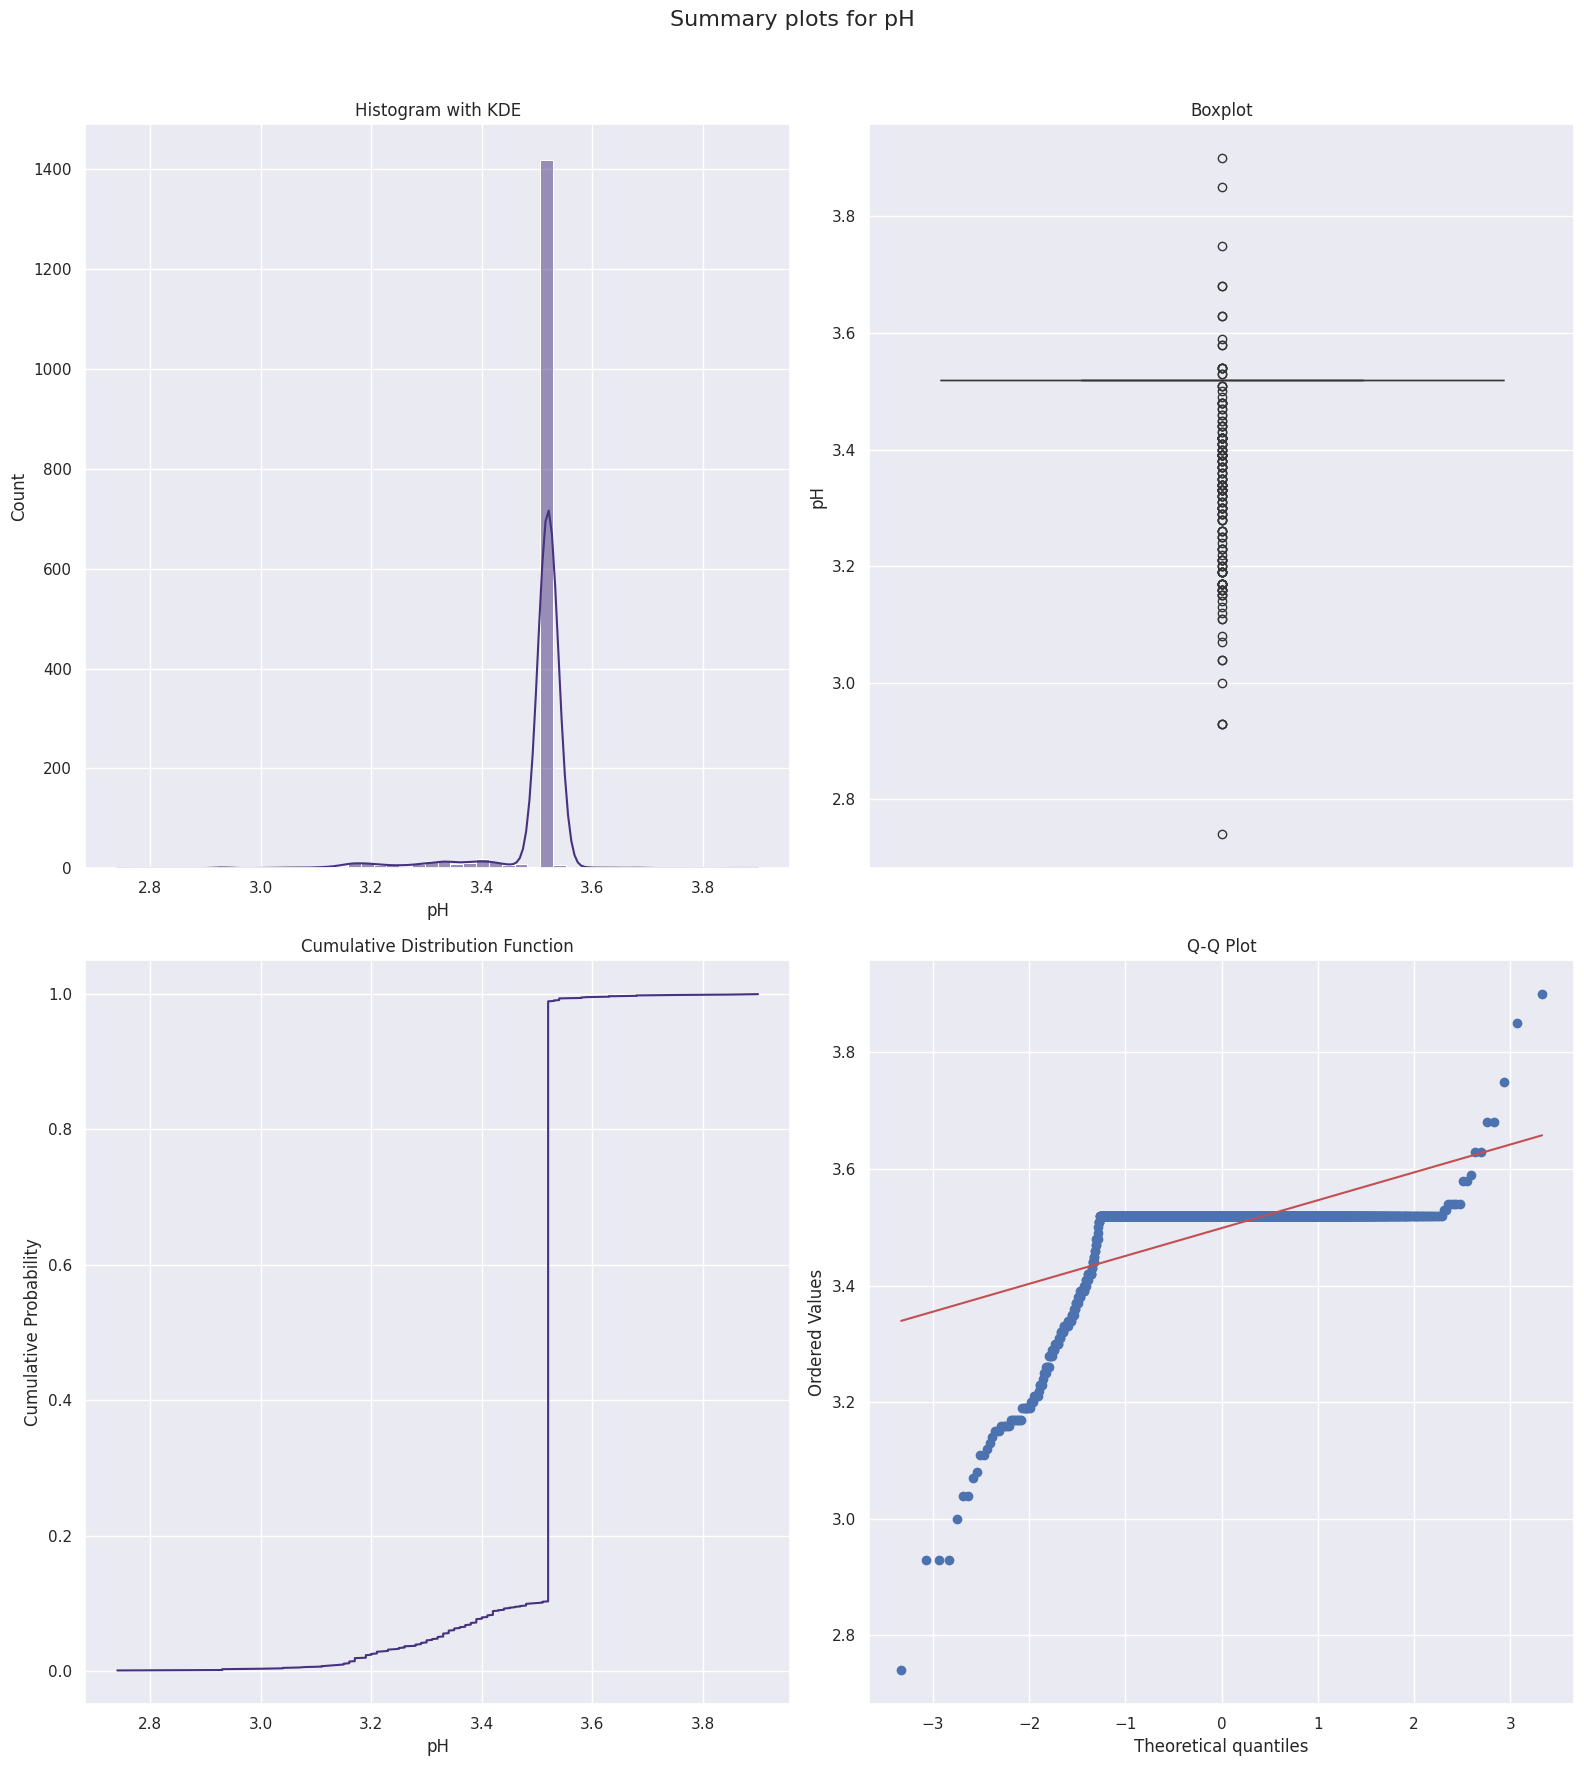

----------------------------------------------------
Summary for sulphates:
count   1596.00000
mean       0.65819
std        0.16959
min        0.33000
1%         0.42000
5%         0.47000
10%        0.50000
25%        0.55000
50%        0.62000
75%        0.73000
90%        0.85000
95%        0.93000
99%        1.26100
max        2.00000
Name: sulphates, dtype: float64
Skewness: 2.43
Kurtosis: 11.72
Zero count: 0 (0.00%)
Negative count: 0 (0.00%)
Missing values: 0 (0.00%)


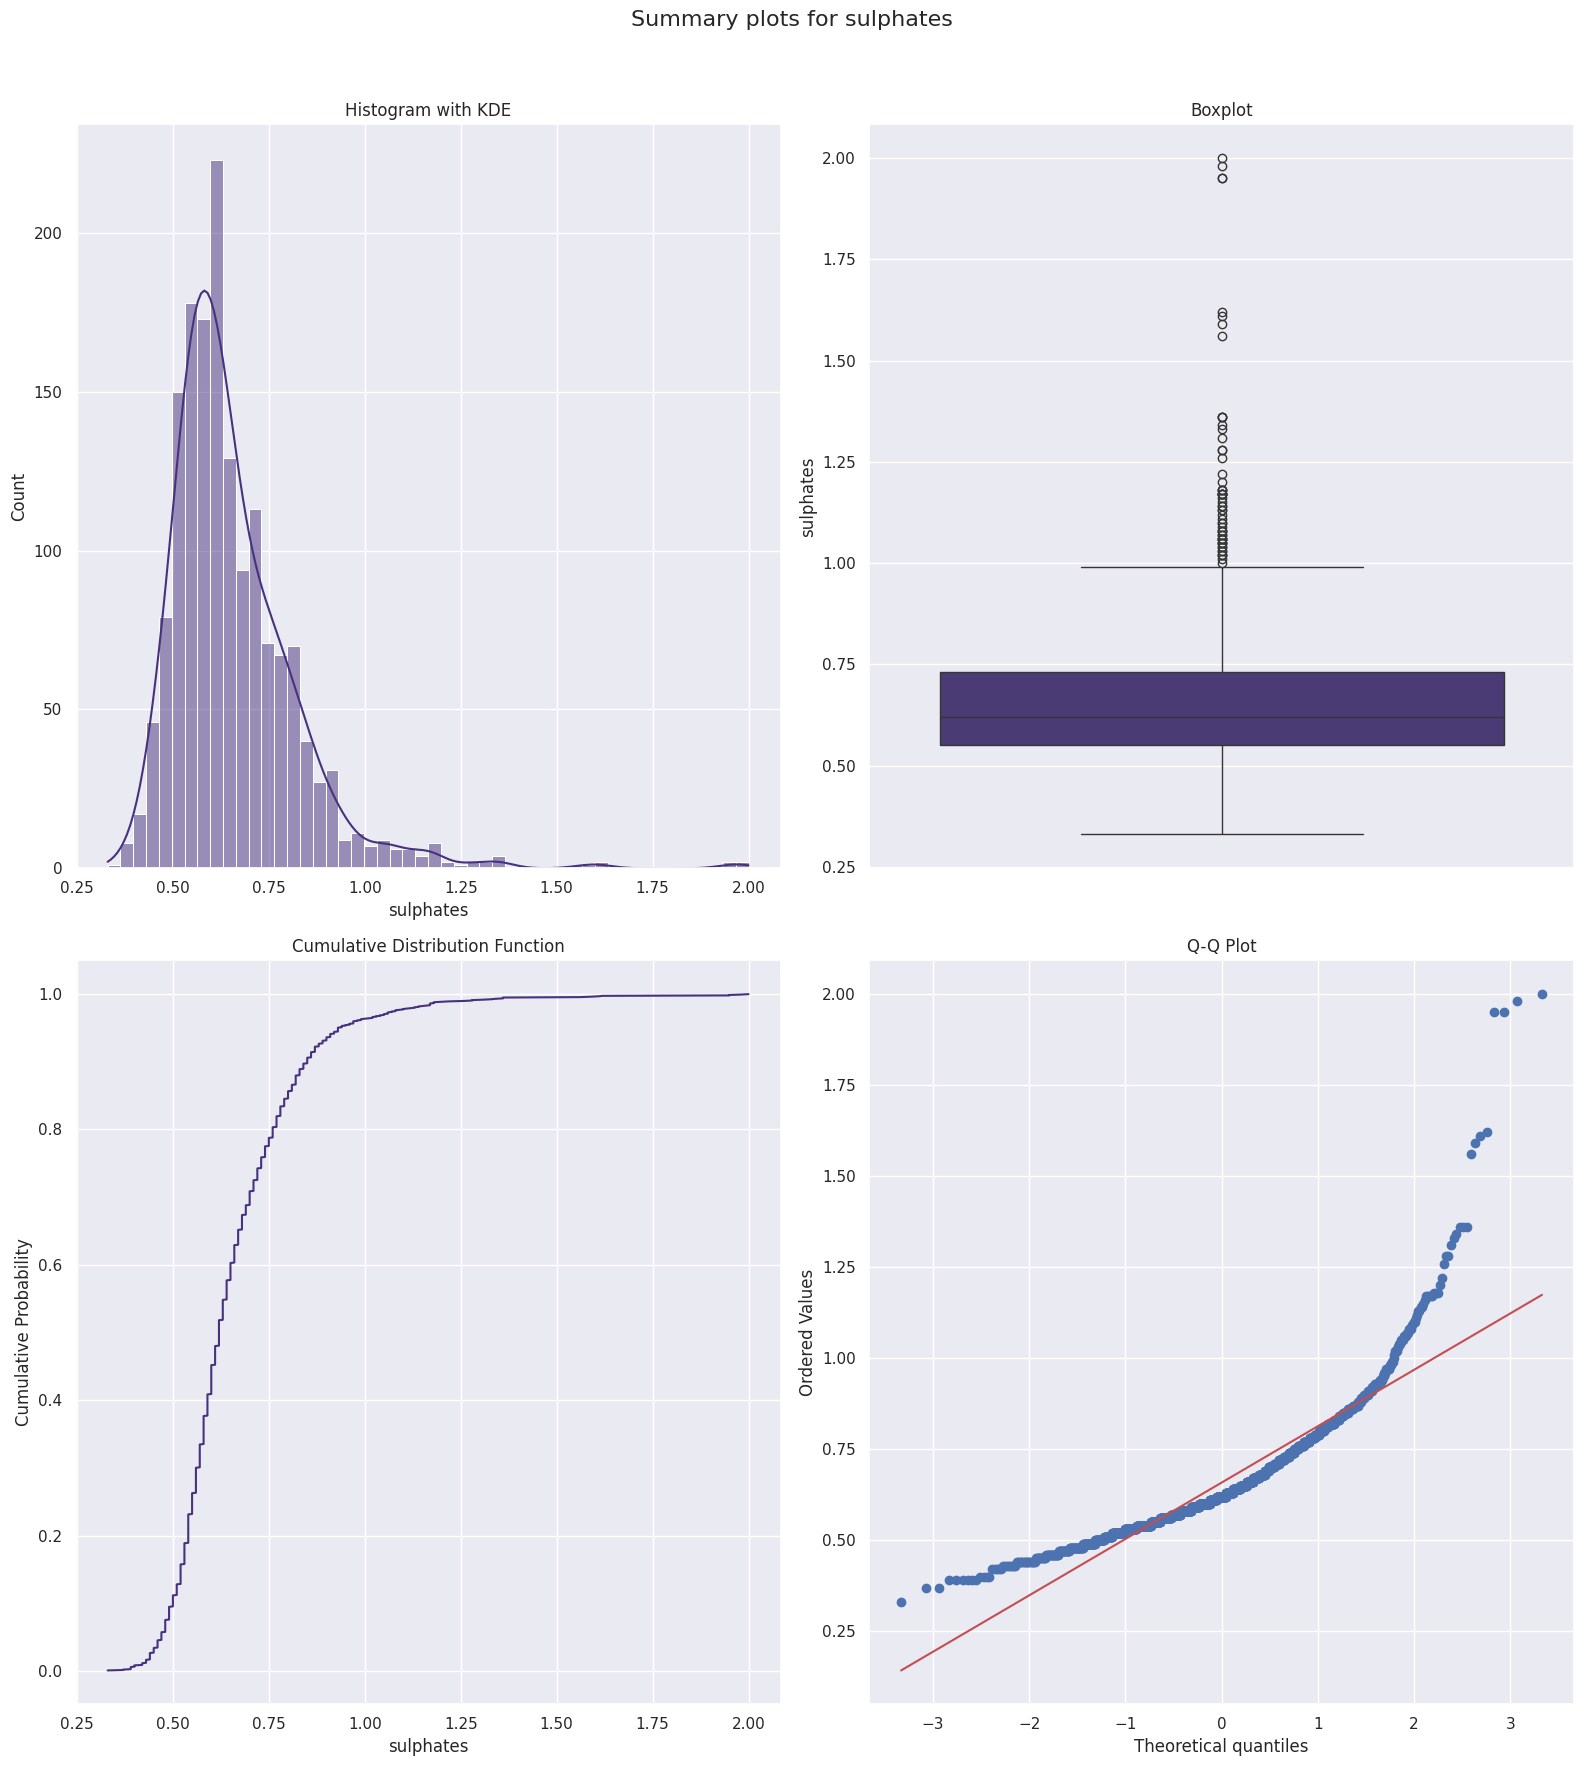

----------------------------------------------------
Summary for alcohol:
count   1596.00000
mean      10.42422
std        1.06605
min        8.40000
1%         9.00000
5%         9.20000
10%        9.30000
25%        9.50000
50%       10.20000
75%       11.10000
90%       12.00000
95%       12.50000
99%       13.40000
max       14.90000
Name: alcohol, dtype: float64
Skewness: 0.86
Kurtosis: 0.20
Zero count: 0 (0.00%)
Negative count: 0 (0.00%)
Missing values: 0 (0.00%)


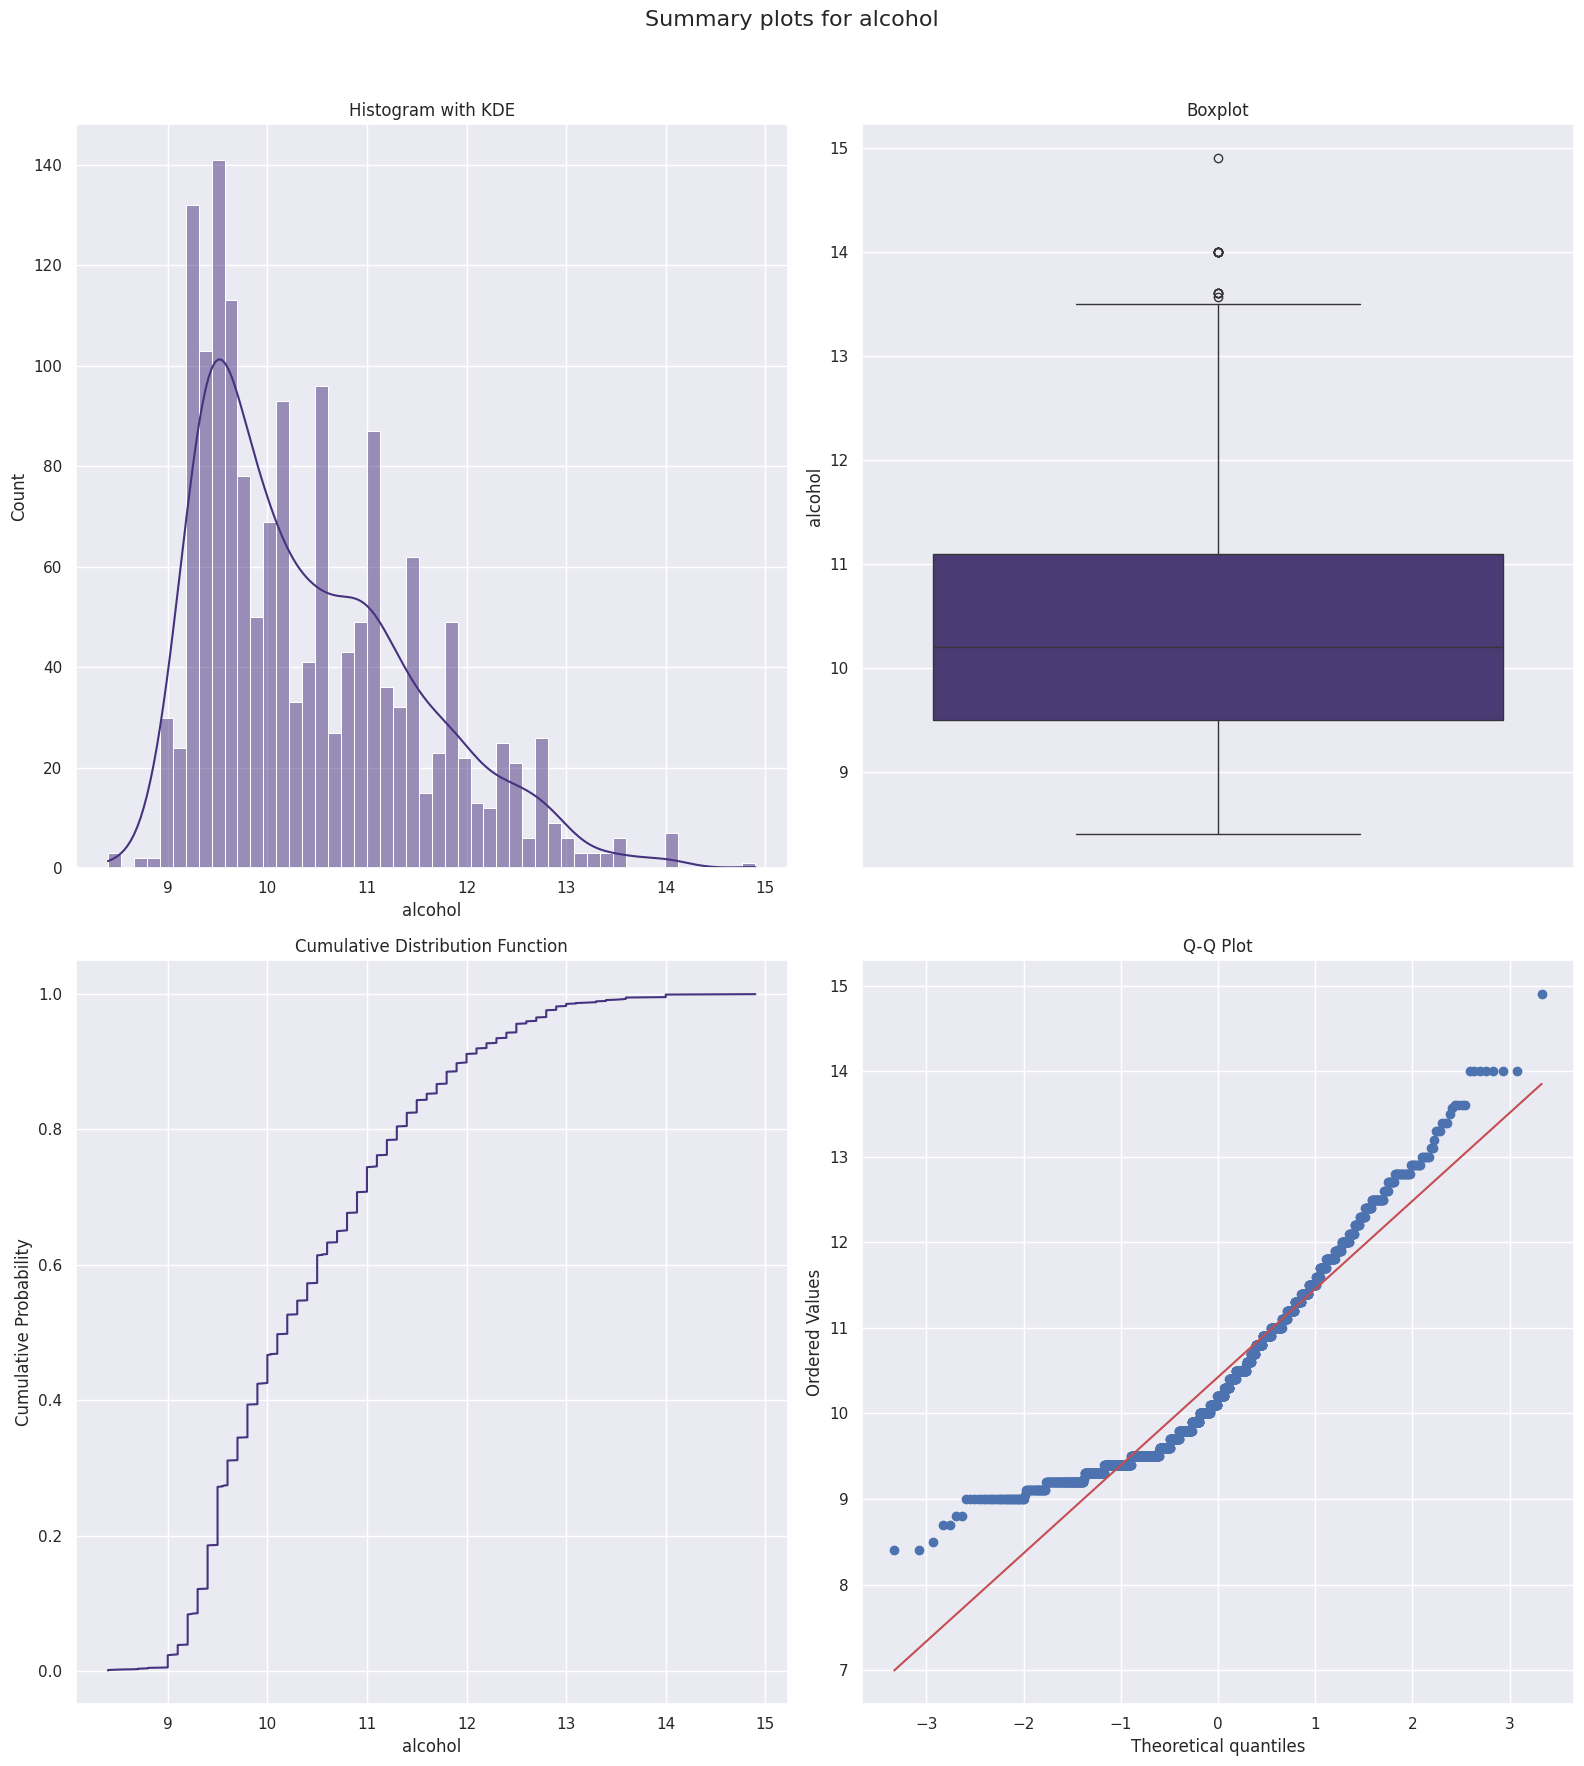

----------------------------------------------------


In [160]:
def num_summary(dataframe, numerical_cols, plot=False, bins=50, percentiles=None):
    try:
        if not isinstance(dataframe, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame")

        if not isinstance(numerical_cols, list):
            raise TypeError("numerical_cols must be a list")

        for numerical_col in numerical_cols:
            if numerical_col not in dataframe.columns:
                raise ValueError(f"Column '{numerical_col}' not found in the DataFrame")

            if not np.issubdtype(dataframe[numerical_col].dtype, np.number):
                raise TypeError(f"Column '{numerical_col}' is not numeric")

            if not isinstance(bins, int) or bins <= 0:
                raise ValueError("'bins' must be a positive integer")

            if percentiles is not None:
                if not isinstance(percentiles, list):
                    raise TypeError("'percentiles' must be a list")
                if not all(0 <= p <= 1 for p in percentiles):
                    raise ValueError("All percentiles must be between 0 and 1")

            if percentiles is None:
                percentiles = [.01, .05, .10, .25, .50, .75, .90, .95, .99]

            desc = dataframe[numerical_col].describe(percentiles=percentiles)
            skewness = dataframe[numerical_col].skew()
            kurtosis = dataframe[numerical_col].kurtosis()

            print(f"Summary for {numerical_col}:")
            print(desc)
            print(f"Skewness: {skewness:.2f}")
            print(f"Kurtosis: {kurtosis:.2f}")

            zero_count = (dataframe[numerical_col] == 0).sum()
            neg_count = (dataframe[numerical_col] < 0).sum()
            print(f"Zero count: {zero_count} ({zero_count/len(dataframe)*100:.2f}%)")
            print(f"Negative count: {neg_count} ({neg_count/len(dataframe)*100:.2f}%)")

            missing = dataframe[numerical_col].isnull().sum()
            print(f"Missing values: {missing} ({missing/len(dataframe)*100:.2f}%)")

            if plot:
                sns.set_palette("viridis")

                fig, axs = plt.subplots(2, 2, figsize=(16, 18))
                fig.suptitle(f'Summary plots for {numerical_col}', fontsize=16)

                sns.histplot(dataframe[numerical_col], kde=True, bins=bins, ax=axs[0, 0])
                axs[0, 0].set_title('Histogram with KDE')
                axs[0, 0].set_xlabel(numerical_col)

                sns.boxplot(y=dataframe[numerical_col], ax=axs[0, 1])
                axs[0, 1].set_title("Boxplot")
                axs[0, 1].set_ylabel(numerical_col)

                sorted_data = np.sort(dataframe[numerical_col].dropna())
                y = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
                axs[1, 0].plot(sorted_data, y)
                axs[1, 0].set_title('Cumulative Distribution Function')
                axs[1, 0].set_xlabel(numerical_col)
                axs[1, 0].set_ylabel('Cumulative Probability')

                stats.probplot(dataframe[numerical_col].dropna(), dist="norm", plot=axs[1, 1])
                axs[1, 1].set_title('Q-Q Plot')

                plt.tight_layout(rect=[0, 0, 1, 0.96])
                plt.show()

            print("----------------------------------------------------")

    except Exception as e:
        print(f"An error occurred: {str(e)}")
num_summary(df, num_cols, plot = True)

In [161]:
df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  free sulfur dioxide  \
0        7.40000           0.70000      0.00000         1.90000    0.07600             11.00000   
1        7.80000           0.88000      0.00000         2.60000    0.09800             25.00000   
2        7.80000           0.76000      0.04000         2.30000    0.09200             15.00000   
3       11.20000           0.28000      0.56000         1.90000    0.07500             17.00000   
4        7.40000           0.70000      0.00000         1.90000    0.07600             11.00000   

   total sulfur dioxide  density      pH  sulphates  alcohol  quality  
0              34.00000  0.99780 3.51000    0.56000  9.40000  2.00000  
1              67.00000  0.99680 3.20000    0.68000  9.80000  2.00000  
2              54.00000  0.99700 3.26000    0.65000  9.80000  2.00000  
3              60.00000  0.99800 3.16000    0.58000  9.80000  3.00000  
4              34.00000  0.99780 3.51000    0.56000  9.40000  2.00000

In [162]:
df.groupby('quality')[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide',
                      'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']].agg(['mean', 'median'])

fixed acidity         volatile acidity         citric acid         residual sugar          \
                 mean  median             mean  median        mean  median           mean  median   
quality                                                                                             
0.00000       8.36000 7.50000          0.88450 0.84500     0.17100 0.03500        2.63500 2.10000   
1.00000       7.77925 7.50000          0.69396 0.67000     0.17415 0.09000        2.69434 2.10000   
2.00000       8.16848 7.80000          0.57696 0.58000     0.24387 0.23000        2.52349 2.20000   
3.00000       8.34976 7.90000          0.49729 0.49000     0.27392 0.26000        2.47810 2.20000   
4.00000       8.87236 8.80000          0.40392 0.37000     0.37518 0.40000        2.72060 2.30000   
5.00000       8.56667 8.25000          0.42333 0.37000     0.39111 0.42000        2.57778 2.10000   

        chlorides         free sulfur dioxide          total sulfur dioxide          density  \
             mean  median                mean   median                 mean   median    mean   
quality                                                                                        
0.00000   0.12250 0.09050            11.00000  6.00000             24.90000 15.00000 0.99746   
1.00000   0.09068 0.08000            12.26415 11.00000             36.24528 26.00000 0.99654   
2.00000   0.09279 0.08100            16.99264 15.00000             56.48012 47.00000 0.99710   
3.00000   0.08497 0.07800            15.72370 14.00000             40.83673 35.00000 0.99661   
4.00000   0.07659 0.07300            14.04523 11.00000             35.02010 27.00000 0.99610   
5.00000   0.06844 0.07050            13.27778  7.50000             33.44444 21.50000 0.99521   

                     pH         sulphates          alcohol           
         median    mean  median      mean  median     mean   median  
quality                                                              
0.00000 0.99757 3.52000 3.52000   0.57000 0.54500  9.95500  9.92500  
1.00000 0.99650 3.48566 3.52000   0.59642 0.56000 10.26509 10.00000  
2.00000 0.99699 3.48535 3.52000   0.62084 0.58000  9.89941  9.70000  
3.00000 0.99656 3.50810 3.52000   0.67548 0.64000 10.63161 10.50000  
4.00000 0.99577 3.51477 3.52000   0.74126 0.74000 11.46591 11.50000  
5.00000 0.99494 3.52000 3.52000   0.76778 0.74000 12.09444 12.15000

In [163]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


In [164]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


In [165]:
def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers

In [166]:
def replace_with_thresholds(dataframe, col):
    low_limit, up_limit = outlier_thresholds(dataframe, col)
    dataframe[col] = dataframe[col].apply(lambda x: low_limit if x < low_limit else (up_limit if x > up_limit else x))
    return dataframe


In [167]:
def outlier_thresholds_per_categoric(dataframe, col_name, cat_name, q1=0.25, q3=0.75):
    outlier_data = []
    for cat in dataframe[cat_name].unique():
        filtered_df = dataframe[dataframe[cat_name] == cat]
        total_length = filtered_df.shape[0]
        low_limit, up_limit = outlier_thresholds(filtered_df, col_name, q1=q1, q3=q3)

        low_limit_length = filtered_df[filtered_df[col_name] < low_limit].shape[0]
        up_limit_length = filtered_df[filtered_df[col_name] > up_limit].shape[0]

        low_limit_ratio = low_limit_length / total_length
        up_limit_ratio = up_limit_length / total_length

        outlier_data.append((cat, low_limit, up_limit, low_limit_length, up_limit_length,
                             low_limit_ratio, up_limit_ratio))

    outlier_df = pd.DataFrame(outlier_data, columns=[cat_name, 'Low Limit', 'Up Limit',
                                                     'Low Limit Length', 'Up Limit Length',
                                                     'Low Limit Ratio', 'Up Limit Ratio'])

    outlier_df['Low Limit'] = outlier_df['Low Limit'].map('{:.3f}'.format)
    outlier_df['Up Limit'] = outlier_df['Up Limit'].map('{:.3f}'.format)
    outlier_df['Low Limit Ratio'] = outlier_df['Low Limit Ratio'].map('{:.3f}'.format)
    outlier_df['Up Limit Ratio'] = outlier_df['Up Limit Ratio'].map('{:.3f}'.format)

    return outlier_df

In [168]:
df.columns = [col.replace(' ', '_') for col in df.columns]
cat_cols, num_cols, cat_but_car, date_cols = grab_col_names(df)

In [169]:
def replace_with_thresholds_per_categoric(dataframe, col_name, cat_name, q1=0.25, q3=0.75):
    for cat in dataframe[cat_name].unique():
        filtered_df = dataframe[dataframe[cat_name] == cat]
        low_limit, up_limit = outlier_thresholds(filtered_df, col_name, q1=q1, q3=q3)

        dataframe.loc[(dataframe[cat_name] == cat) & (dataframe[col_name] < low_limit), col_name] = low_limit
        dataframe.loc[(dataframe[cat_name] == cat) & (dataframe[col_name] > up_limit), col_name] = up_limit

    return dataframe

In [170]:
def plot_boxplots(dataframe, columns, categories, horizontal=False, hue_plot=False, palette='viridis'):
    for cat in categories:
        for col in columns:
            plt.figure(figsize=(10, 6))
            if horizontal:
                if hue_plot:
                    hue_column = input('Please enter your hue variable: ')
                    if hue_column in dataframe.columns:
                        sns.boxplot(x=col, y=cat, hue=hue_column, data=dataframe, palette=palette)
                    else:
                        print('Invalid hue variable.')
                else:
                    sns.boxplot(x=col, y=cat, data=dataframe, palette=palette)
            else:
                if hue_plot:
                    hue_column = input('Please enter your hue variable: ')
                    if hue_column in dataframe.columns:
                        sns.boxplot(x=cat, y=col, hue=hue_column, data=dataframe, palette=palette)
                    else:
                        print('Invalid hue variable.')
                else:
                    sns.boxplot(x=cat, y=col, data=dataframe, palette=palette)
            plt.title(f'{cat} vs {col}')
            plt.show()

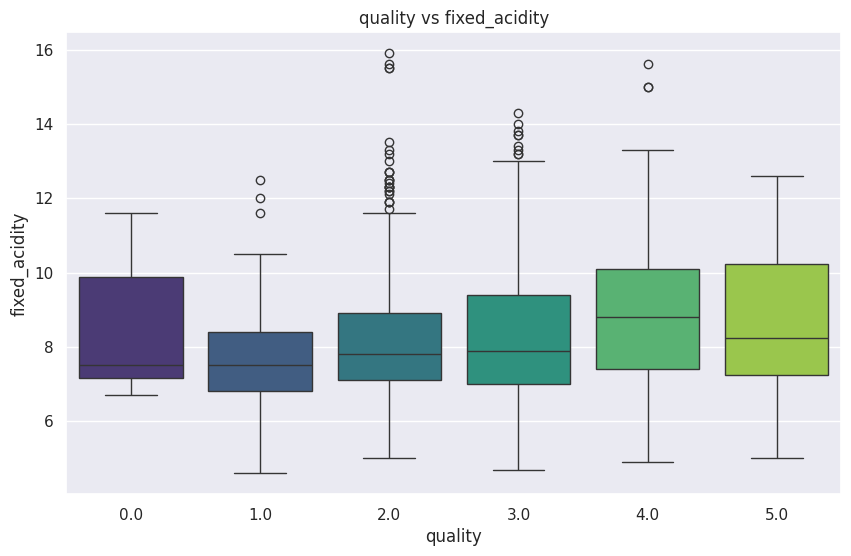

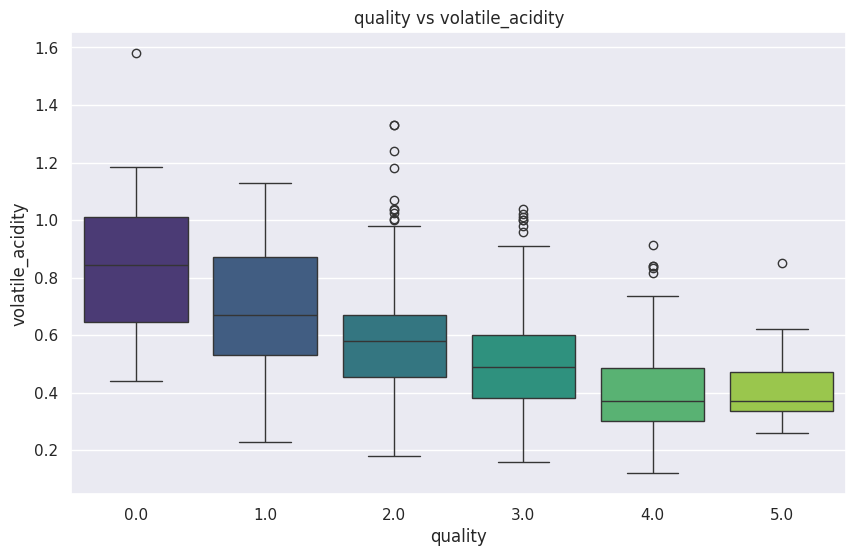

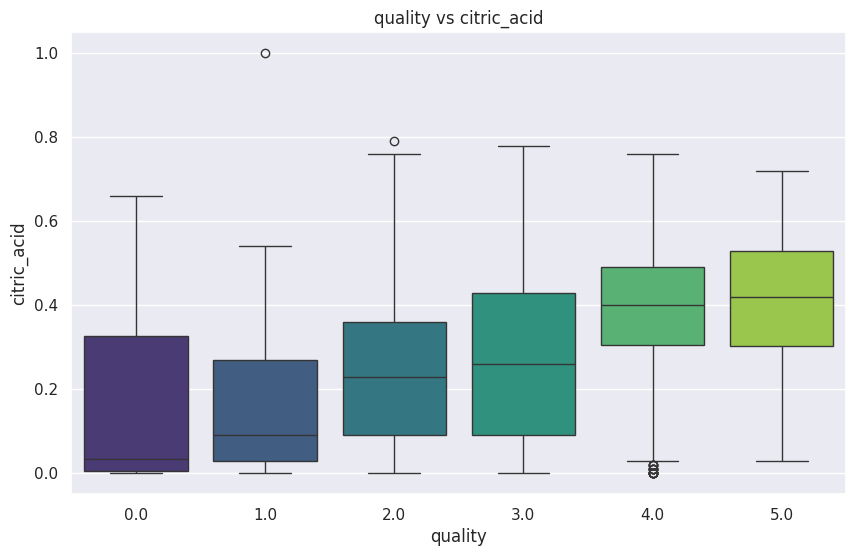

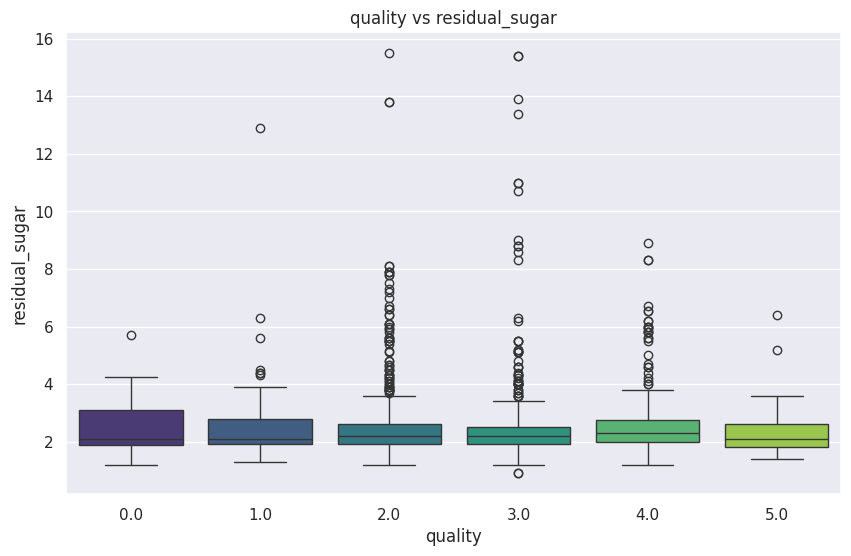

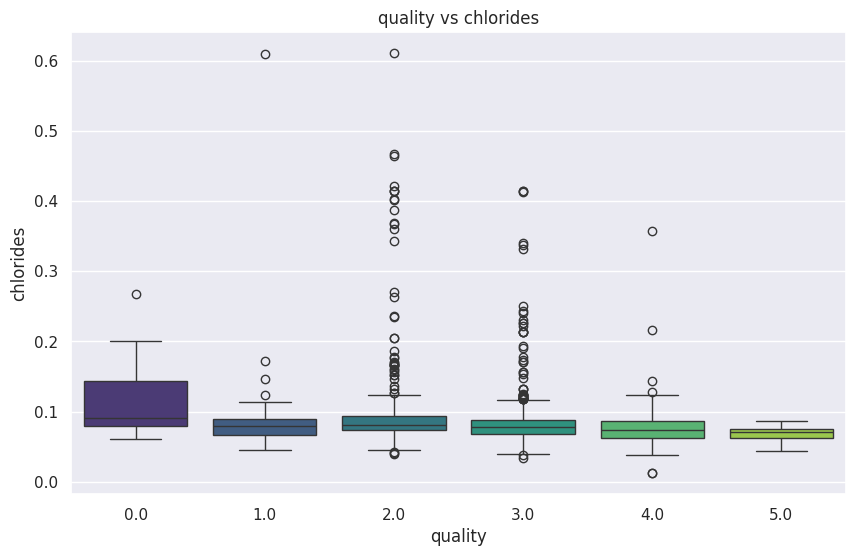

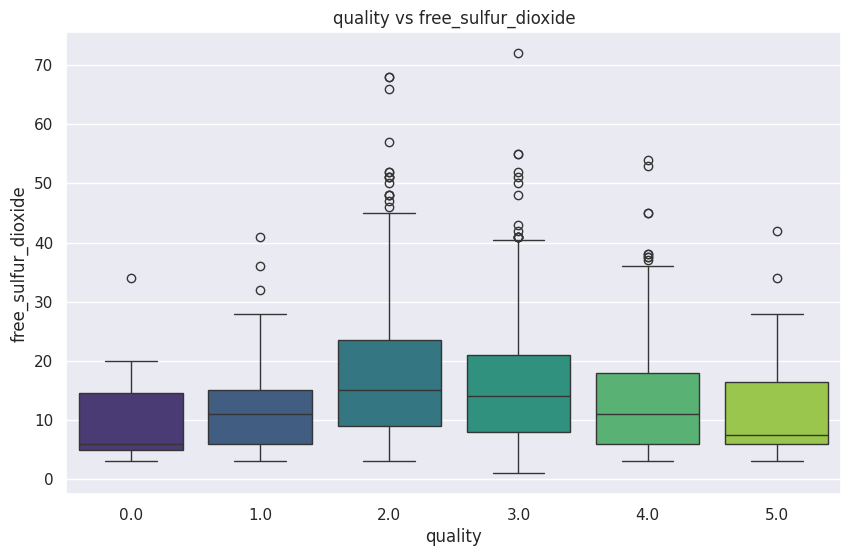

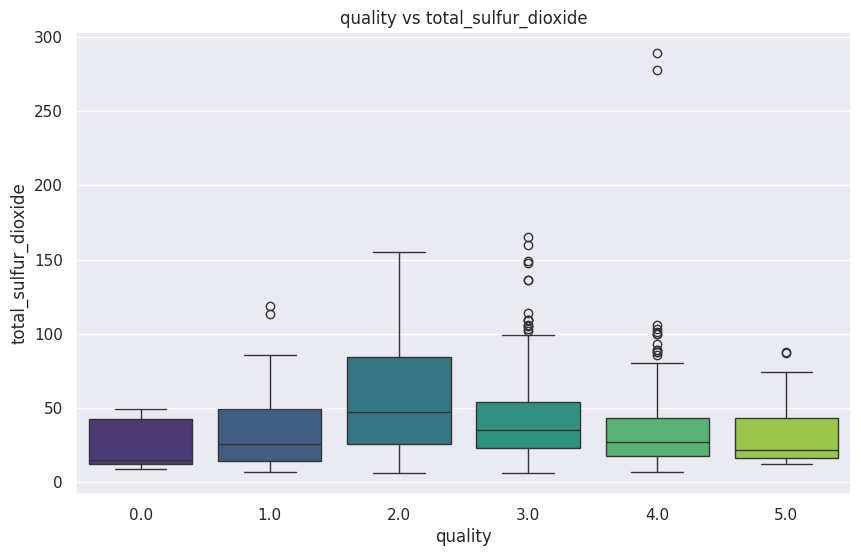

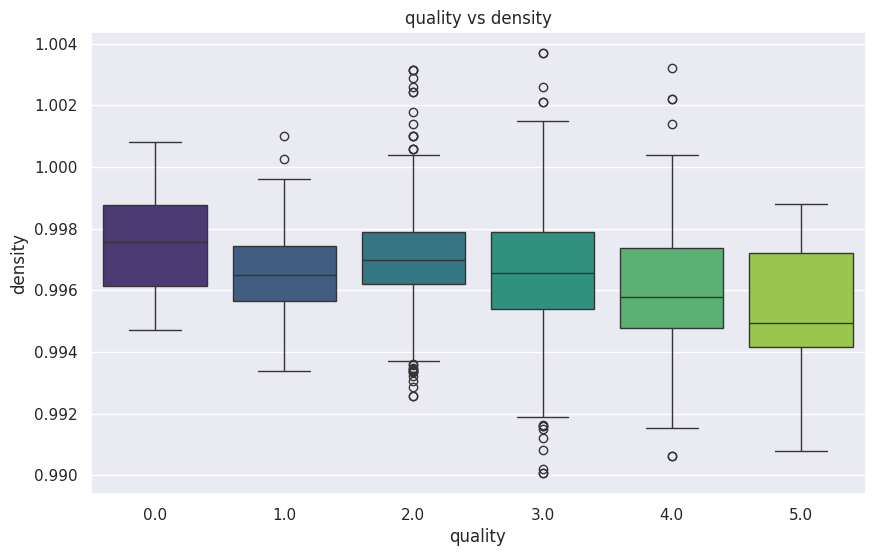

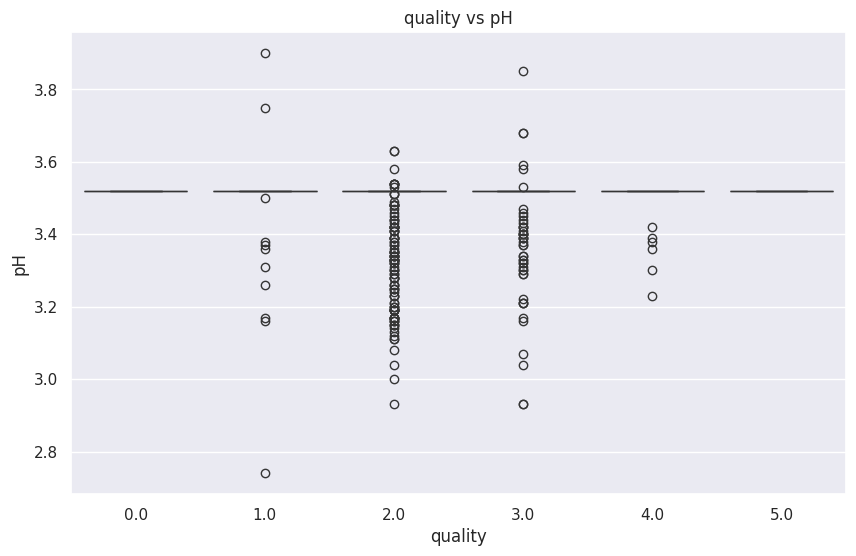

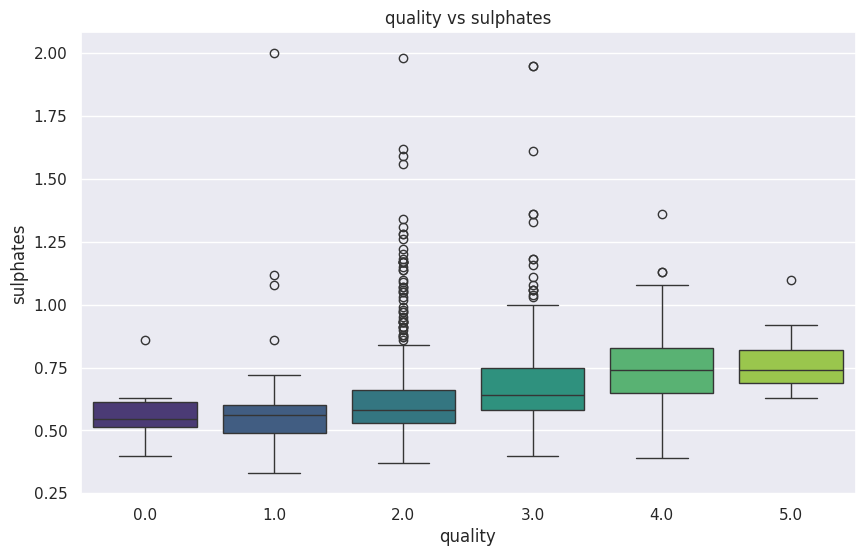

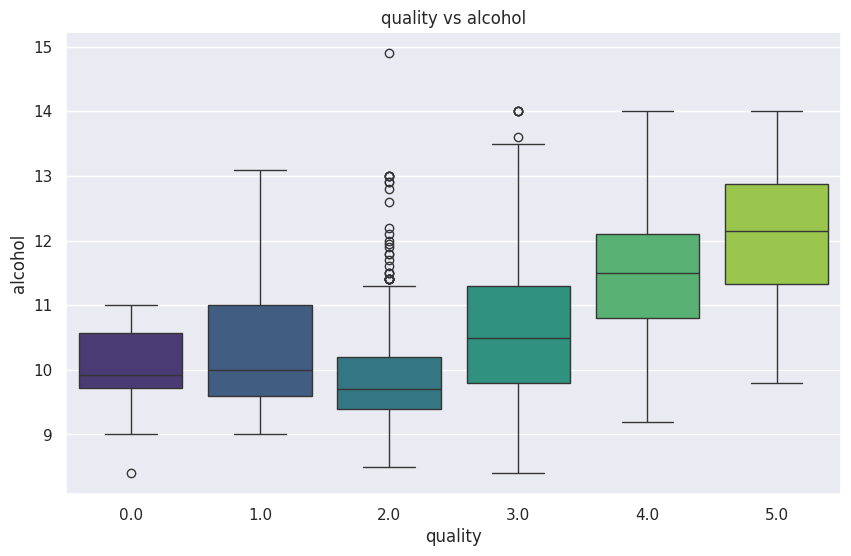

In [171]:
plot_boxplots(df, num_cols, cat_cols)

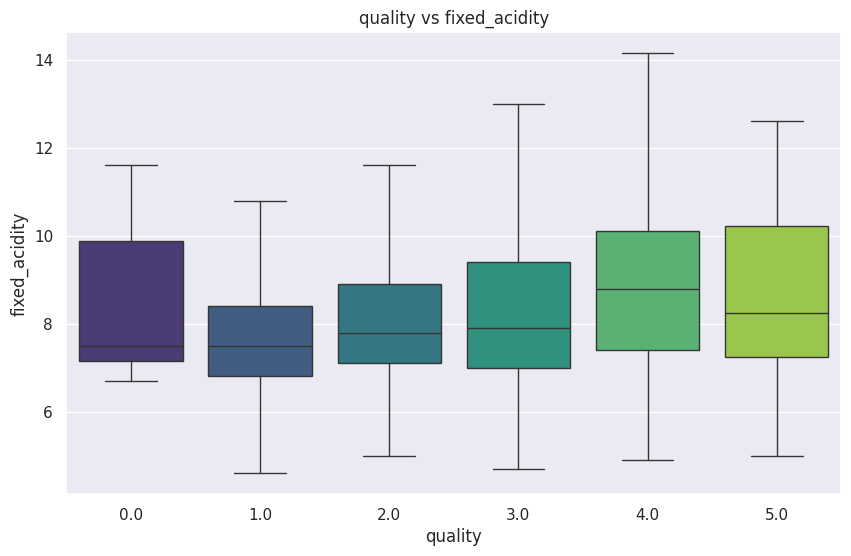

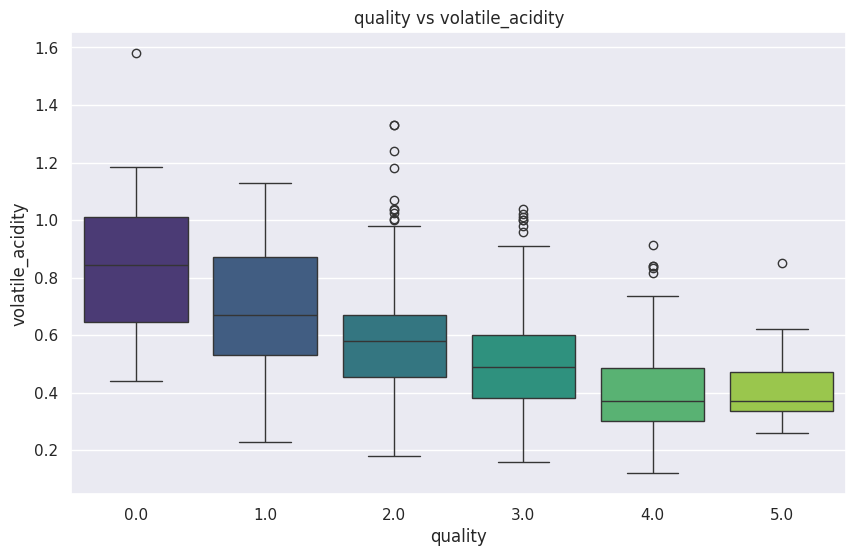

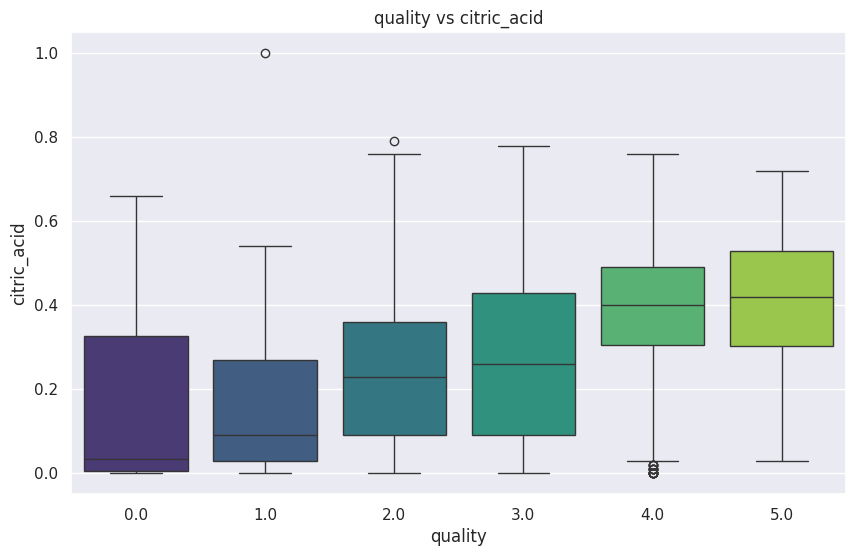

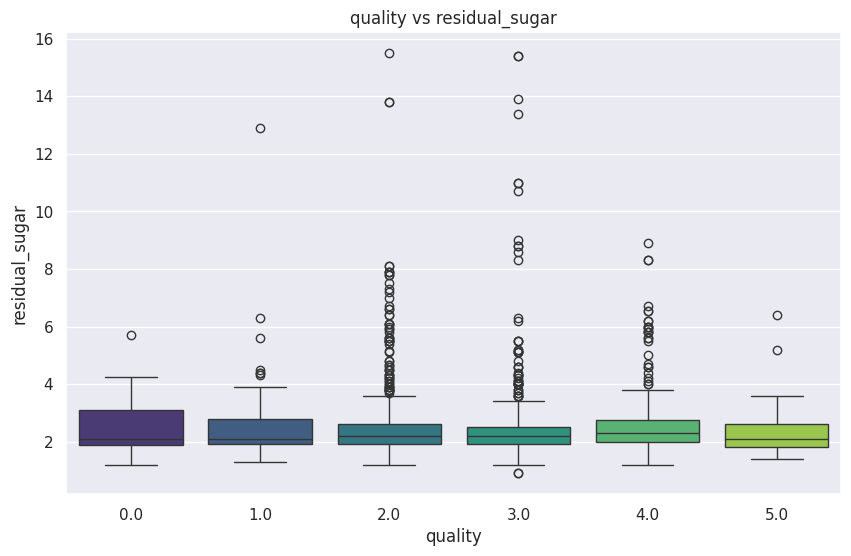

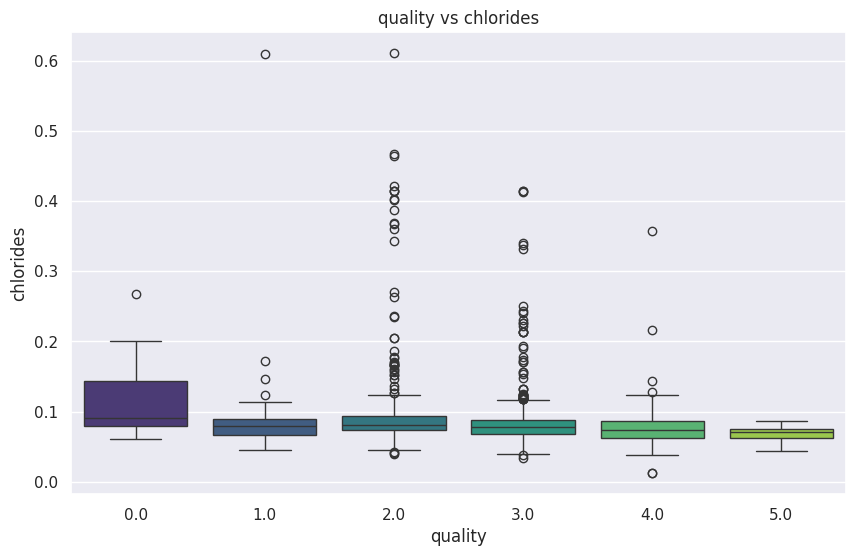

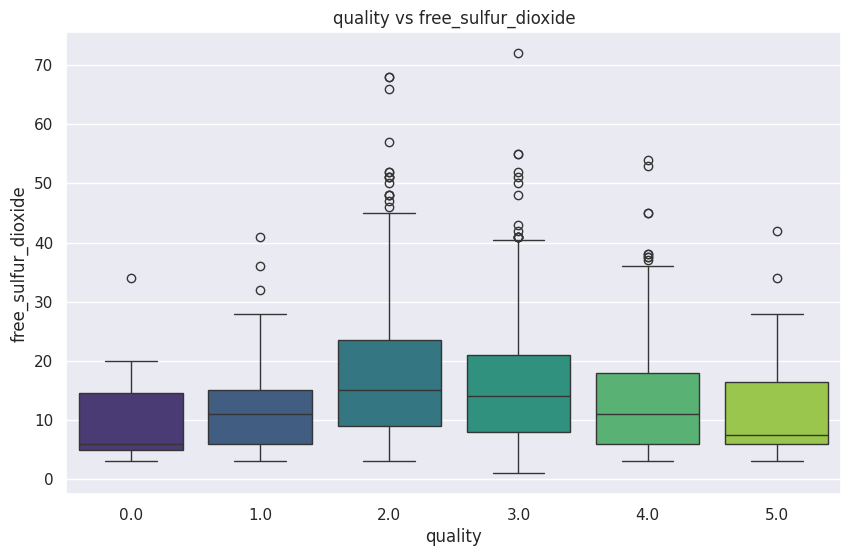

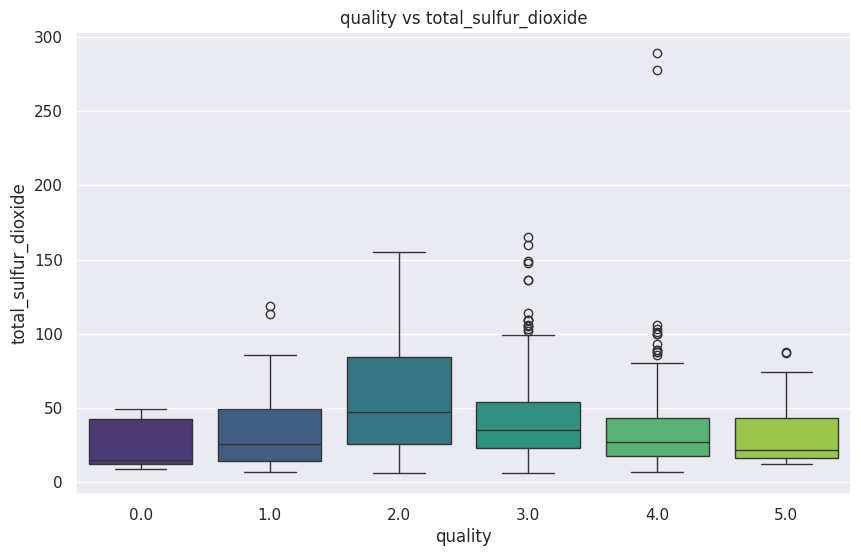

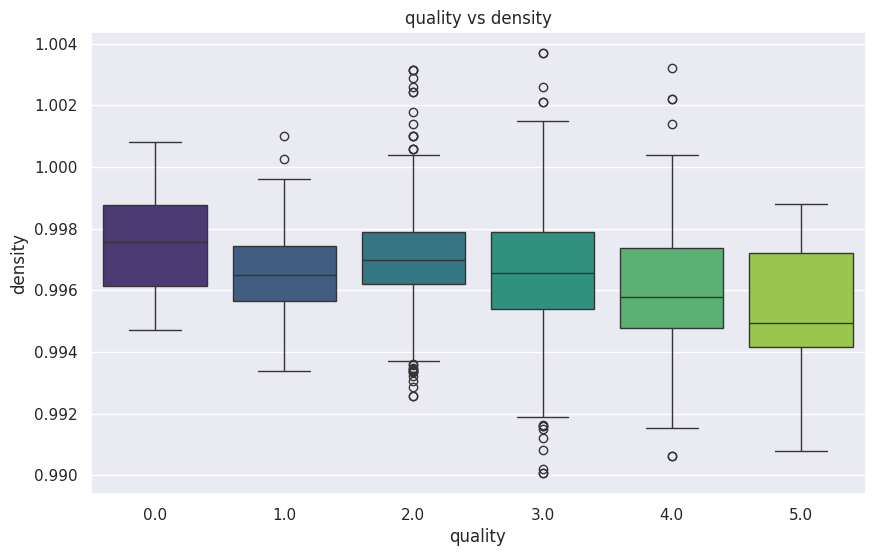

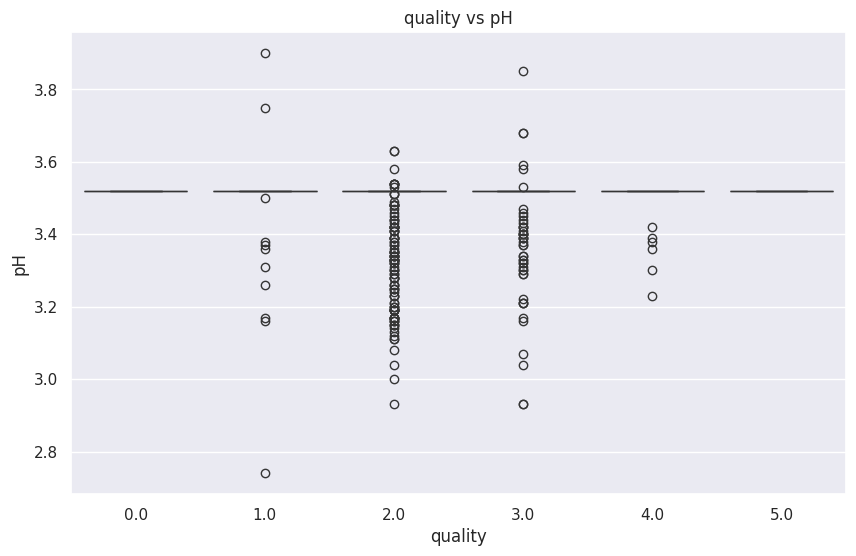

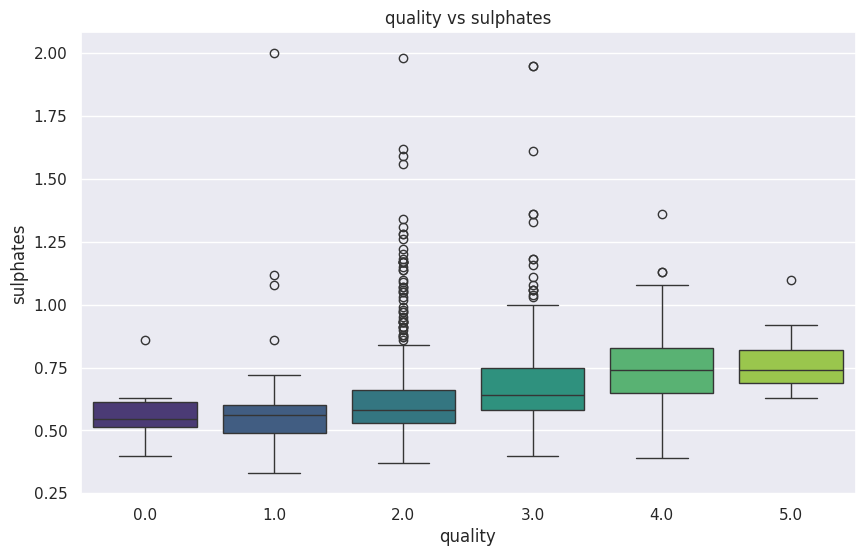

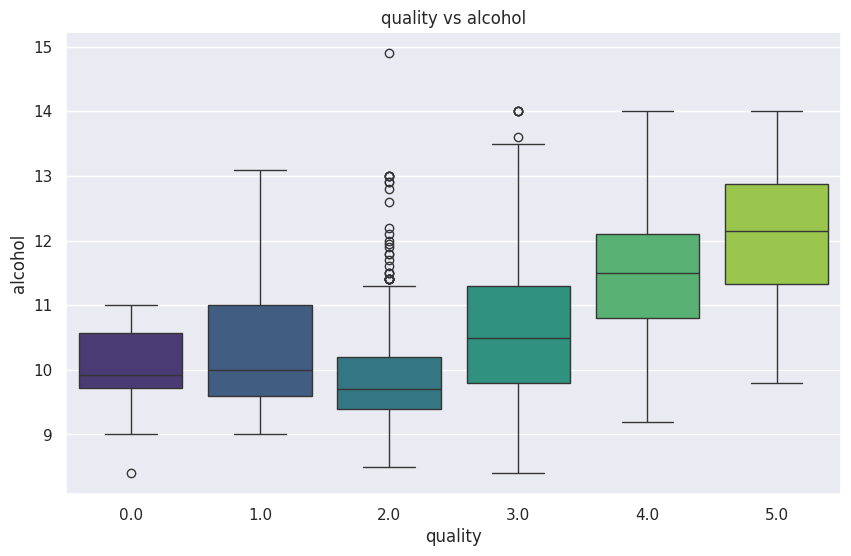

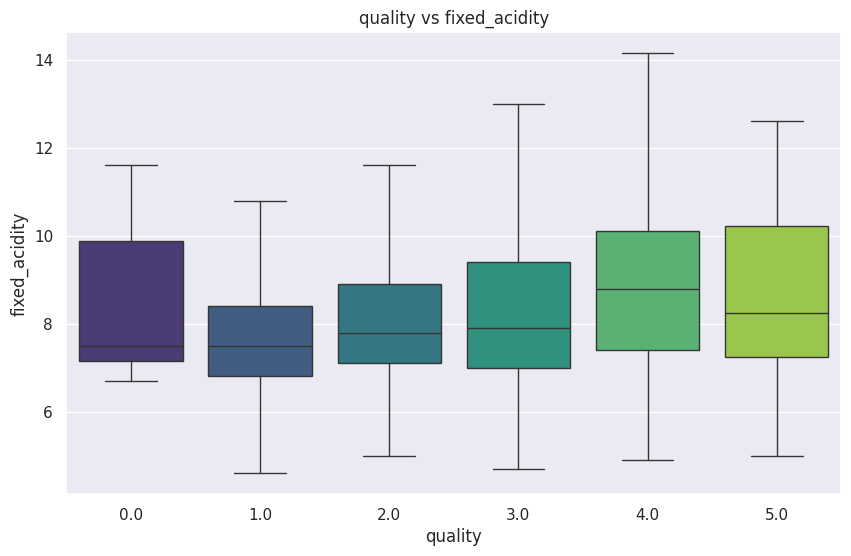

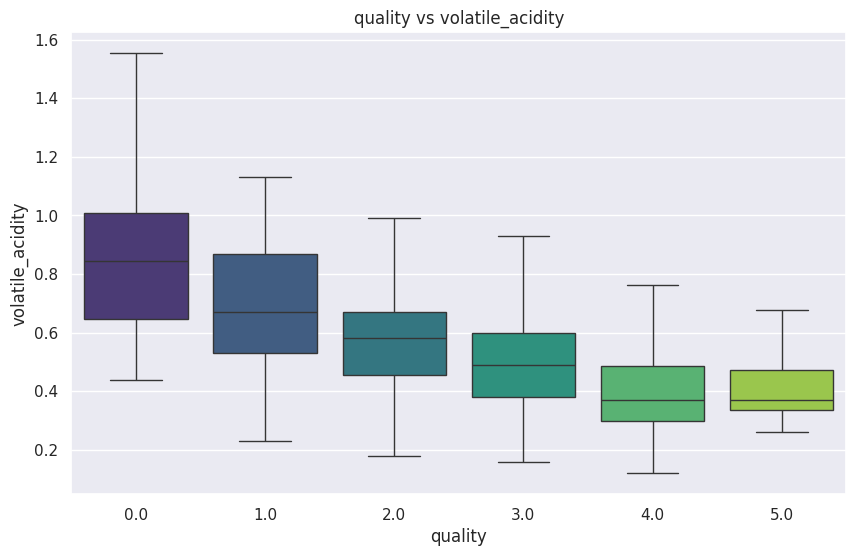

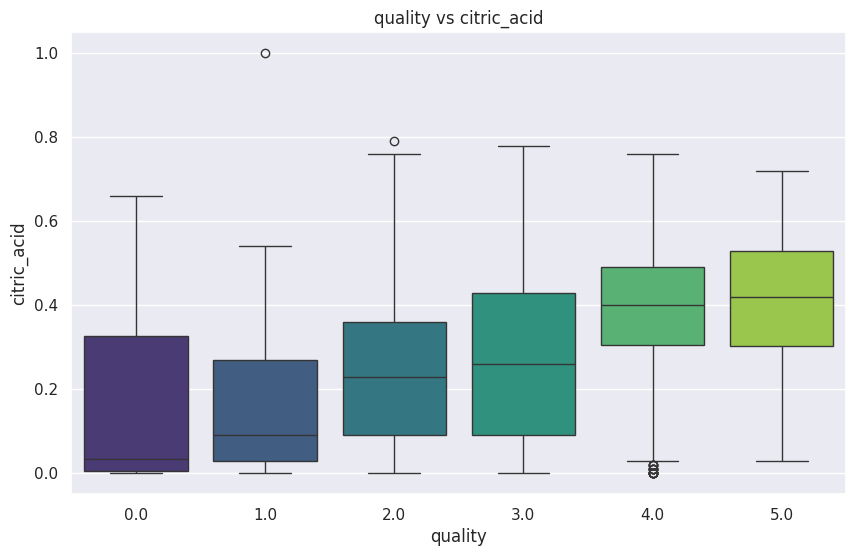

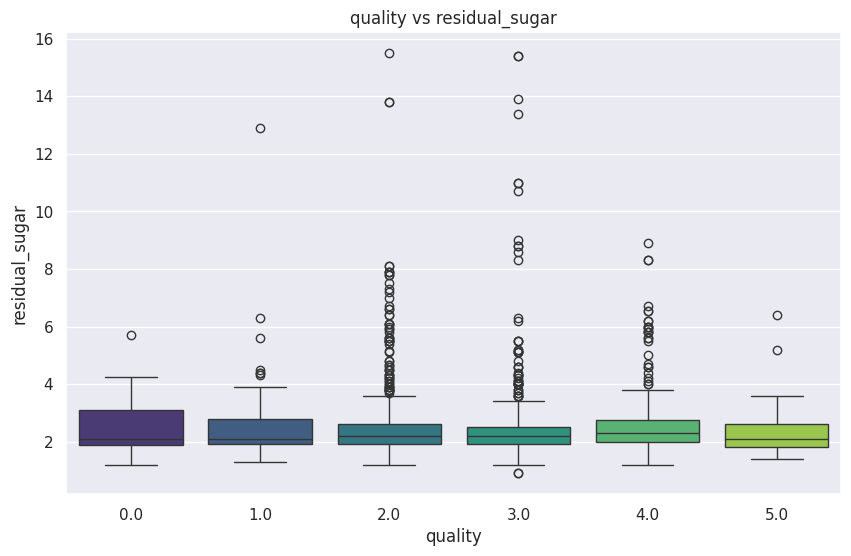

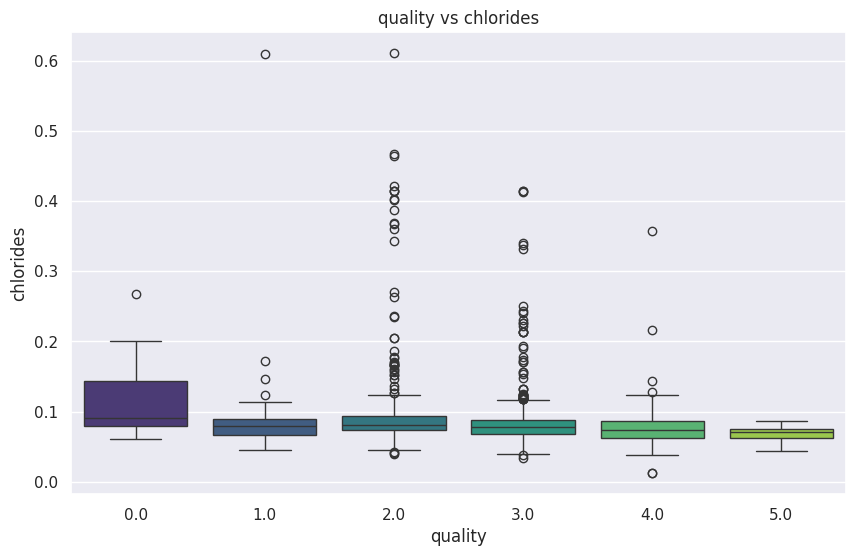

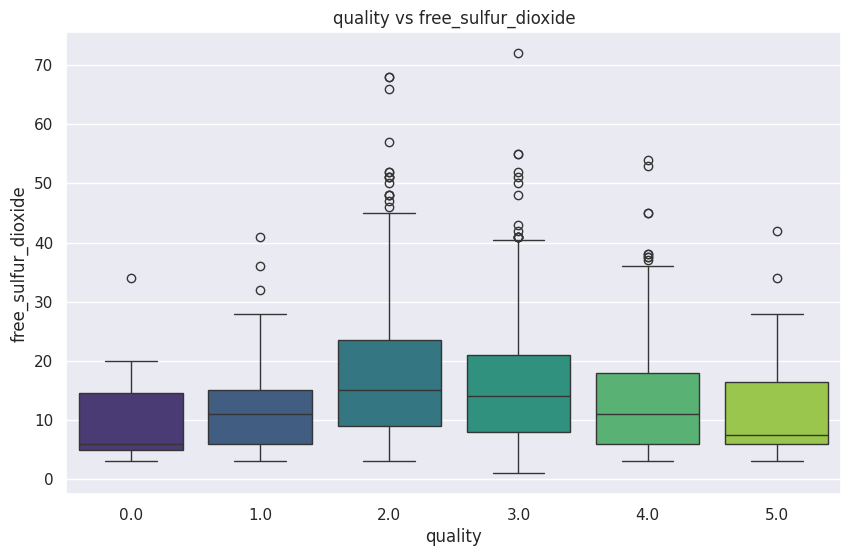

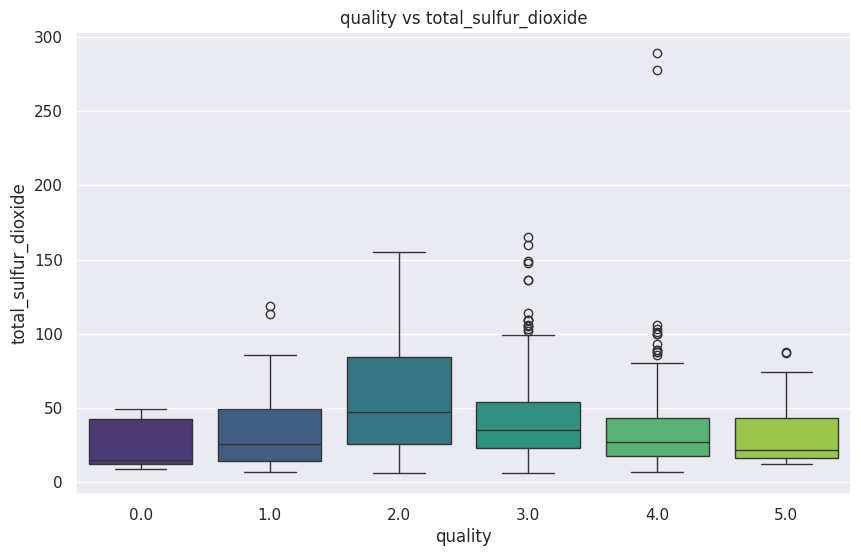

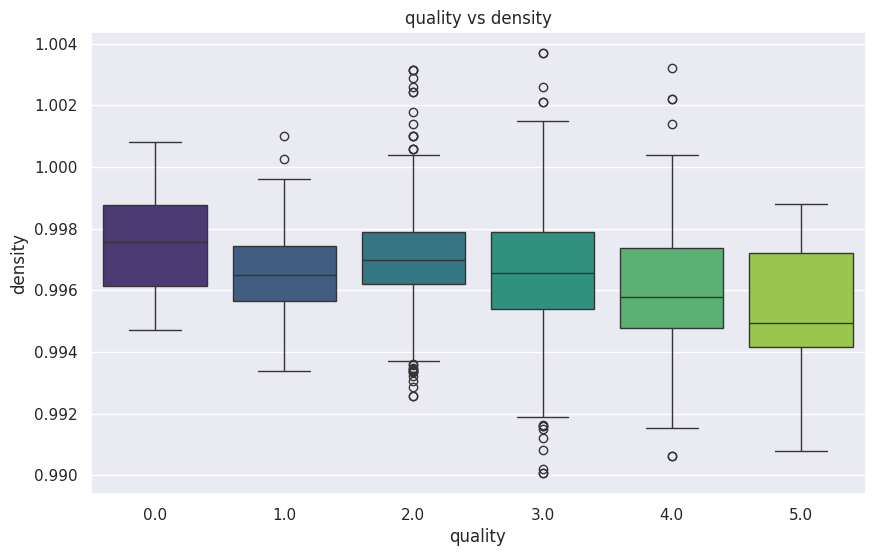

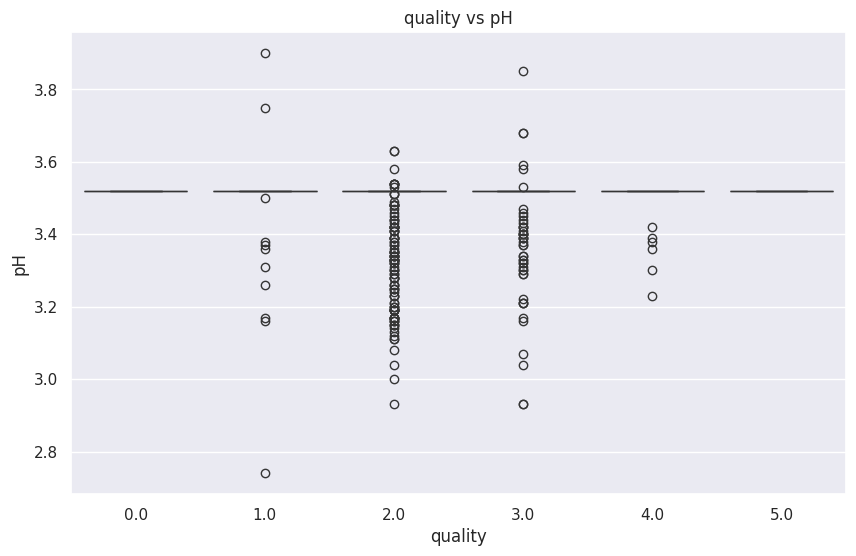

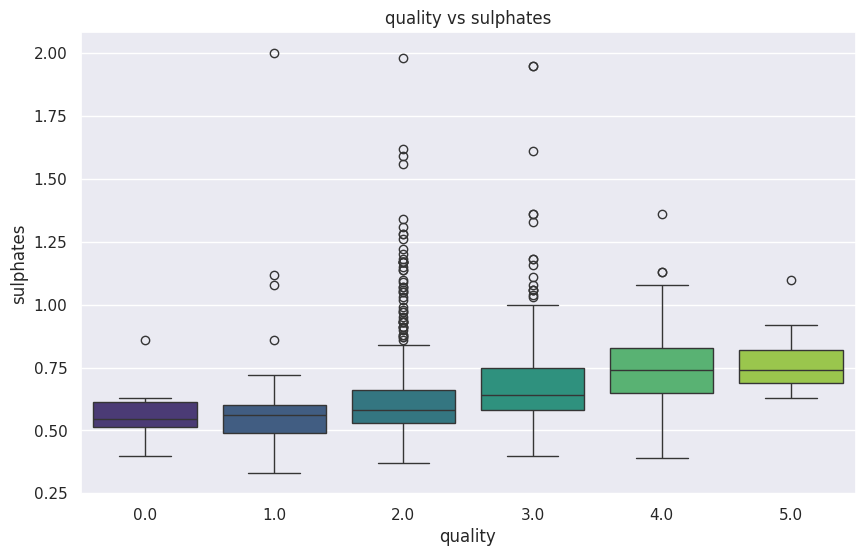

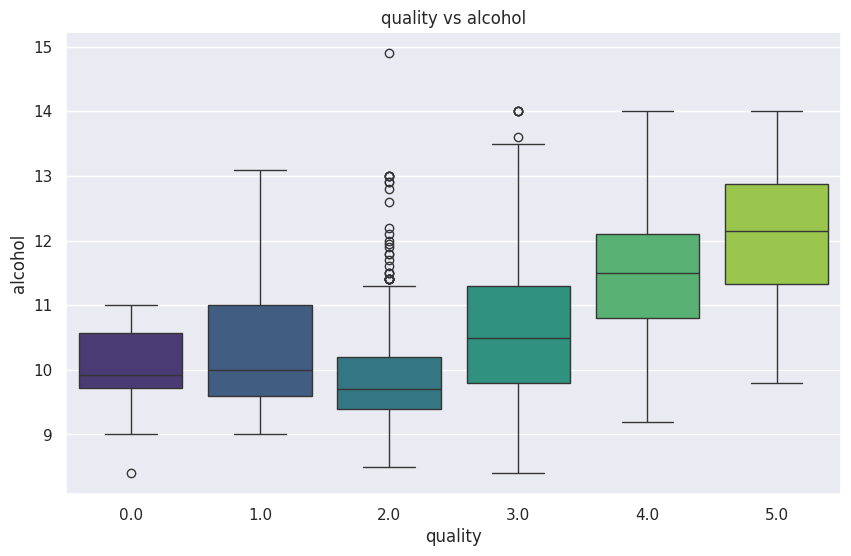

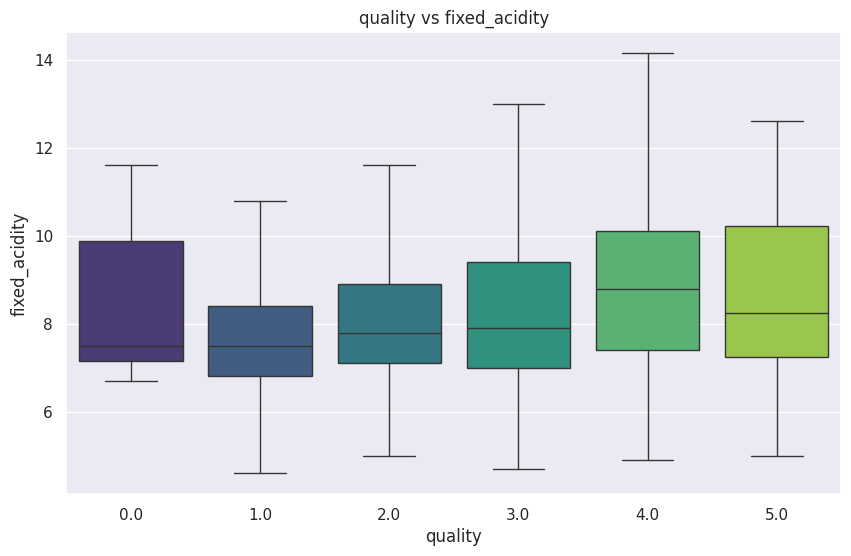

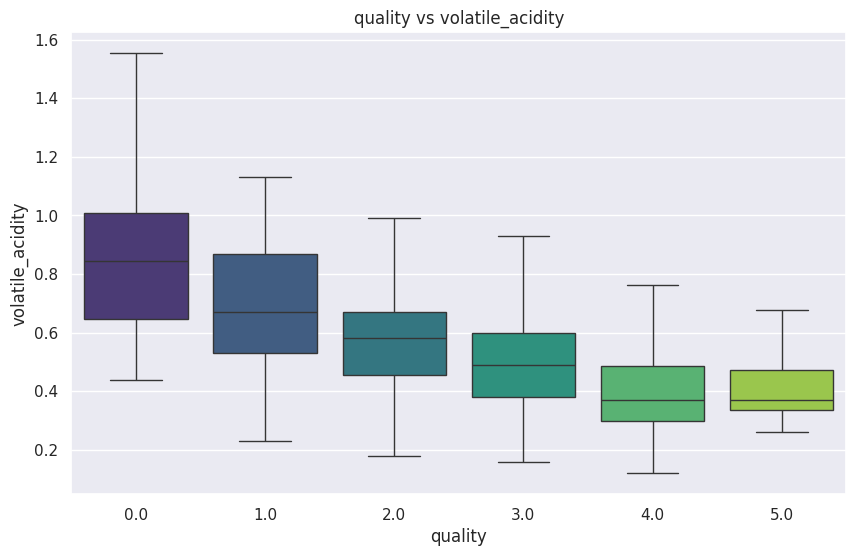

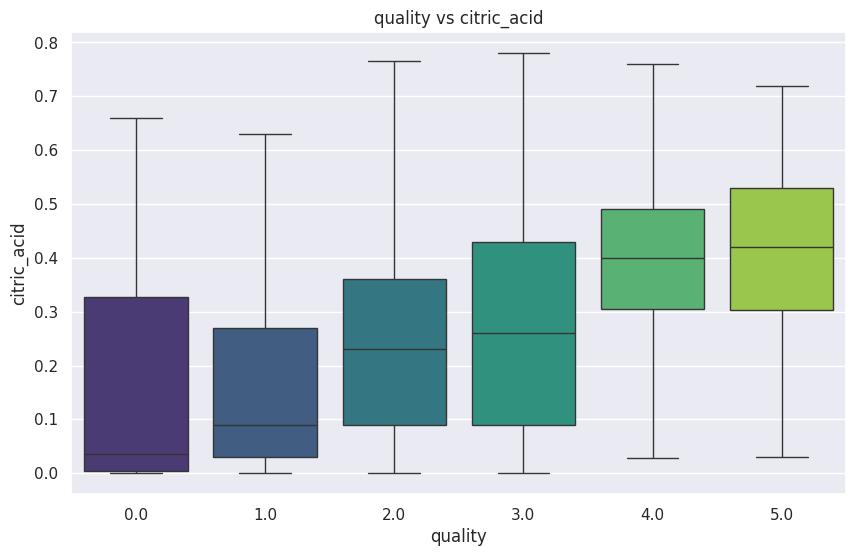

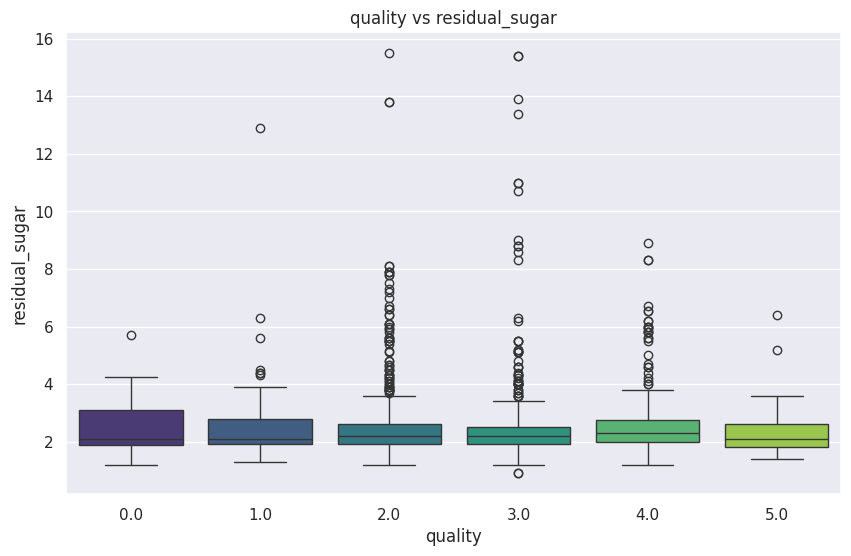

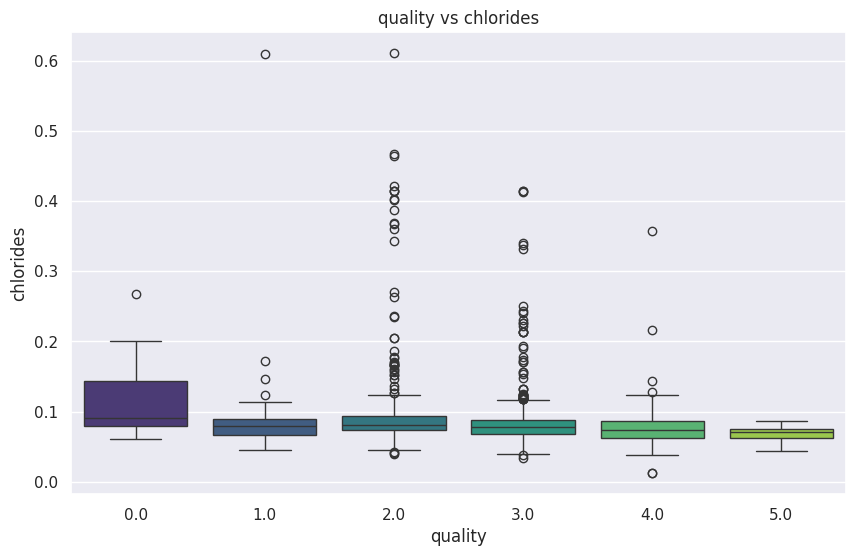

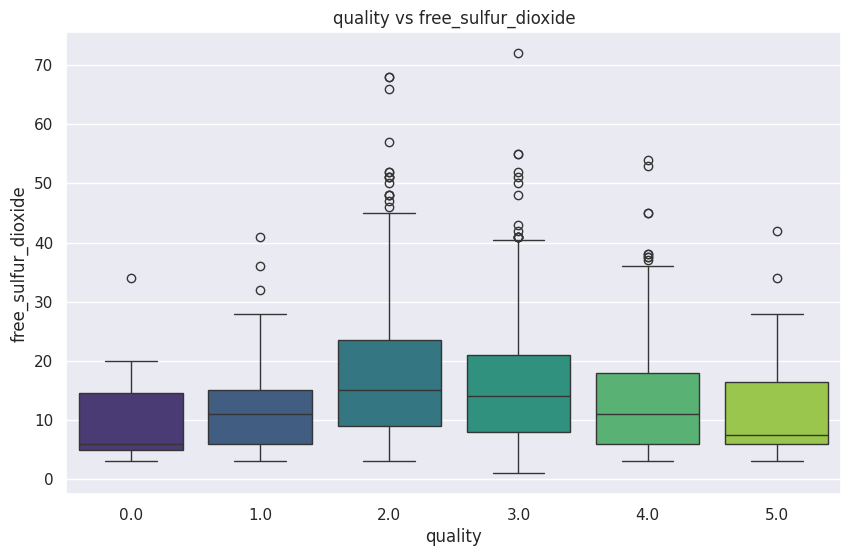

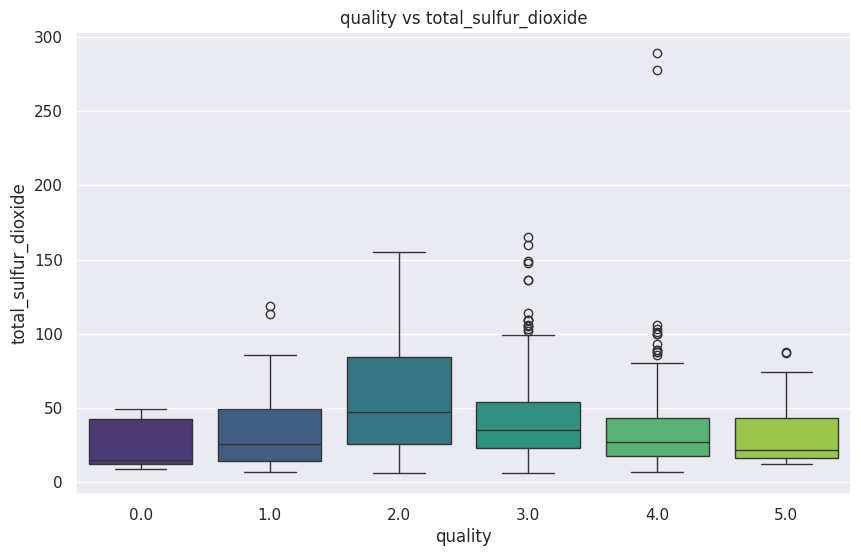

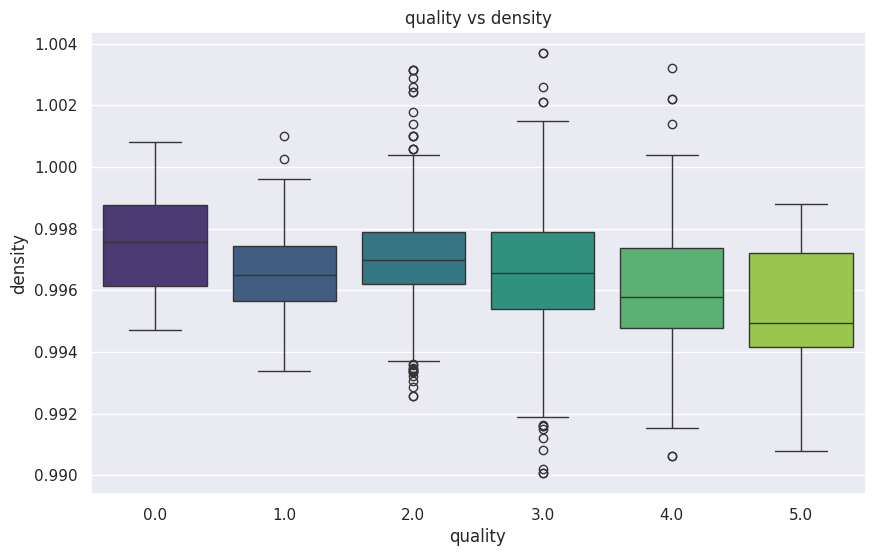

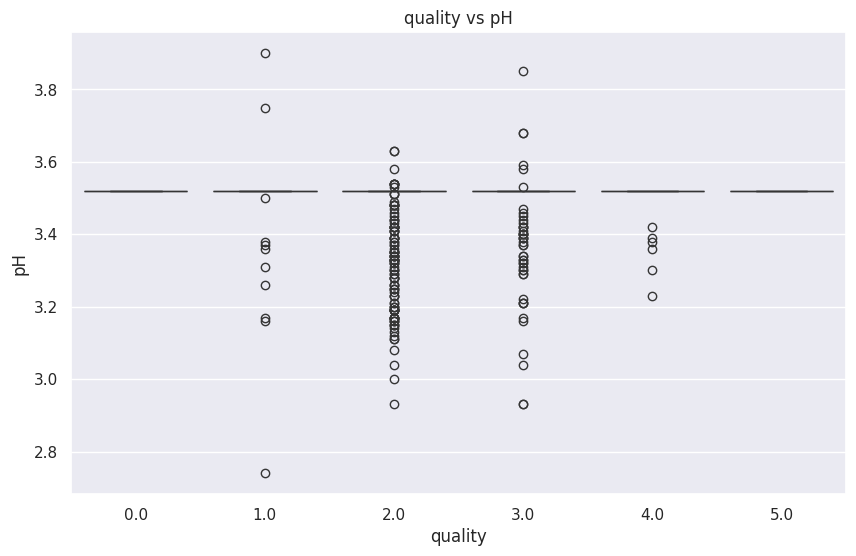

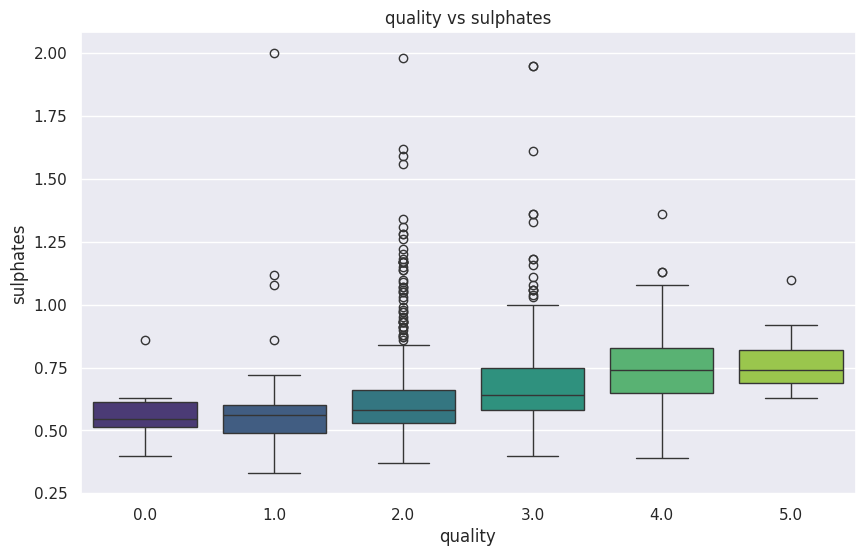

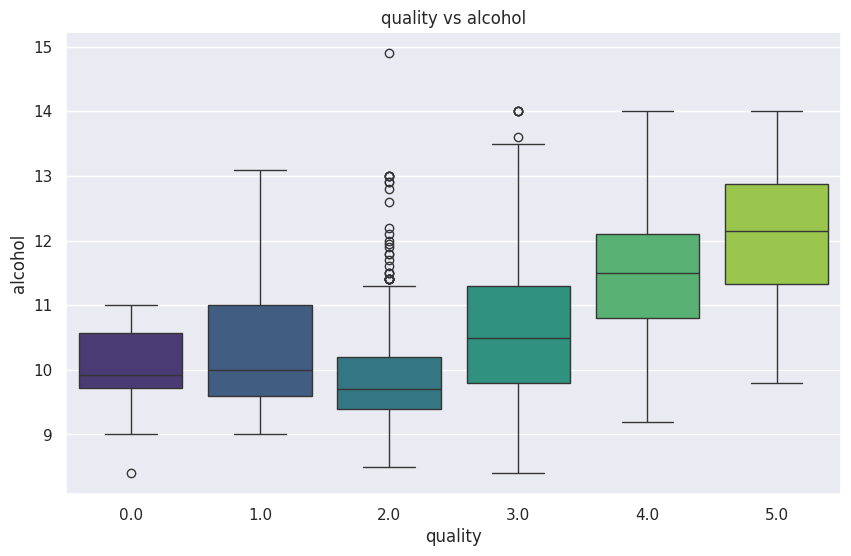

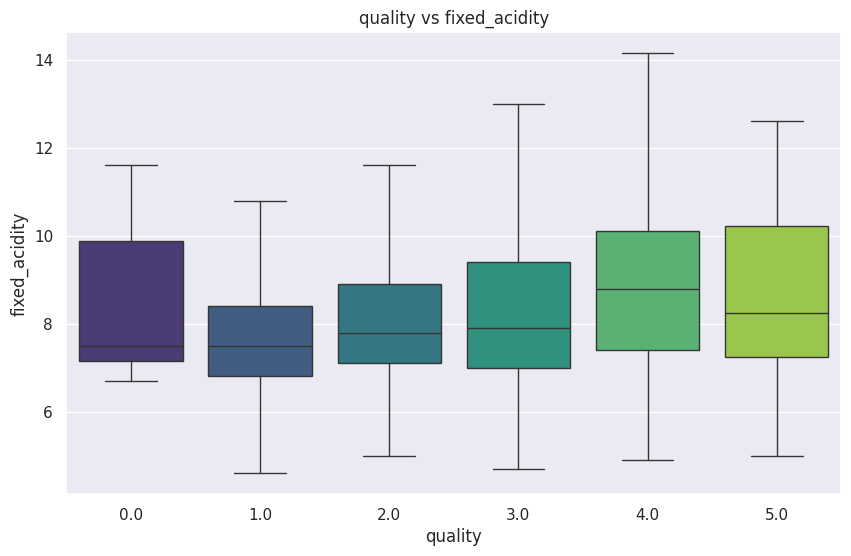

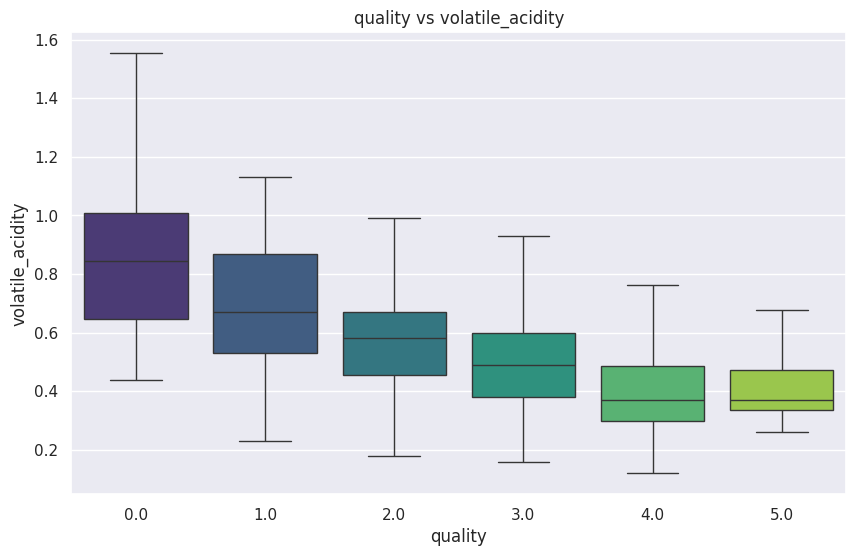

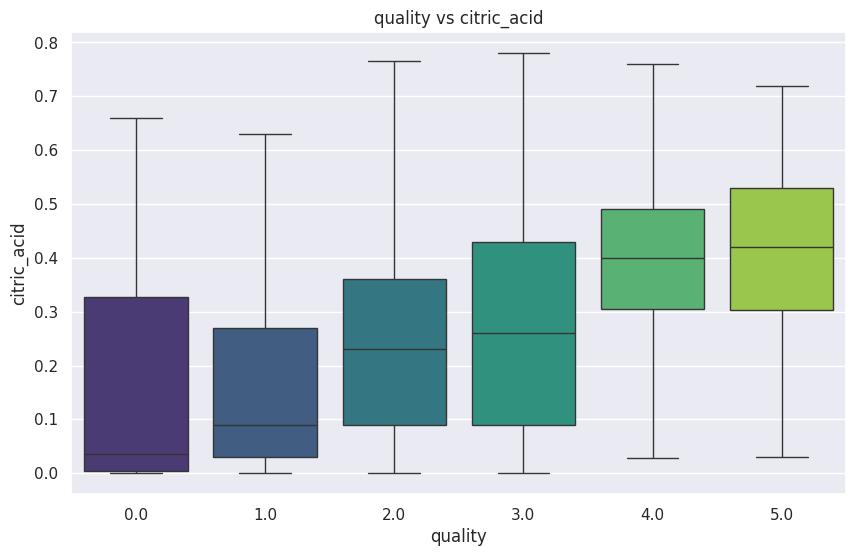

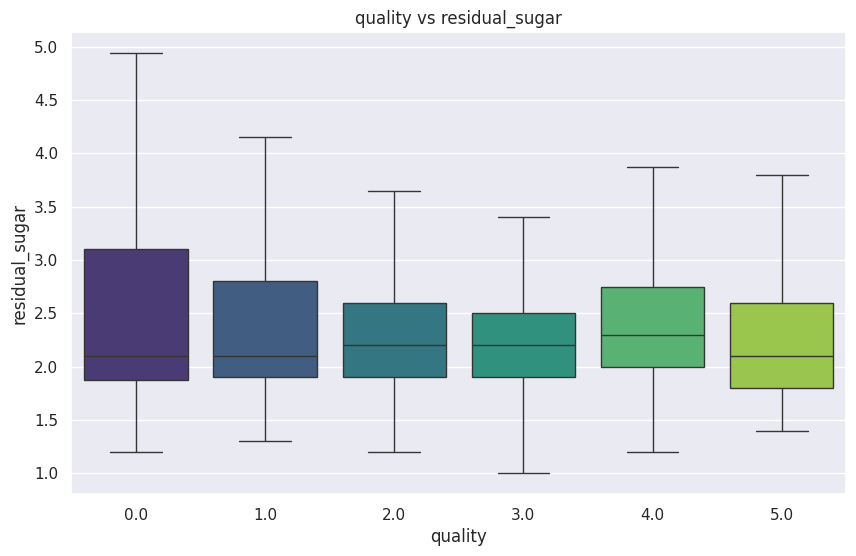

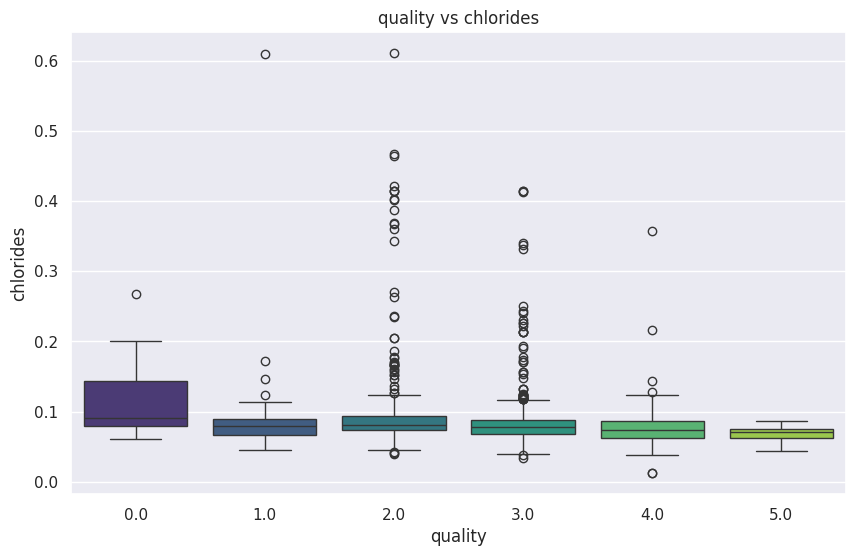

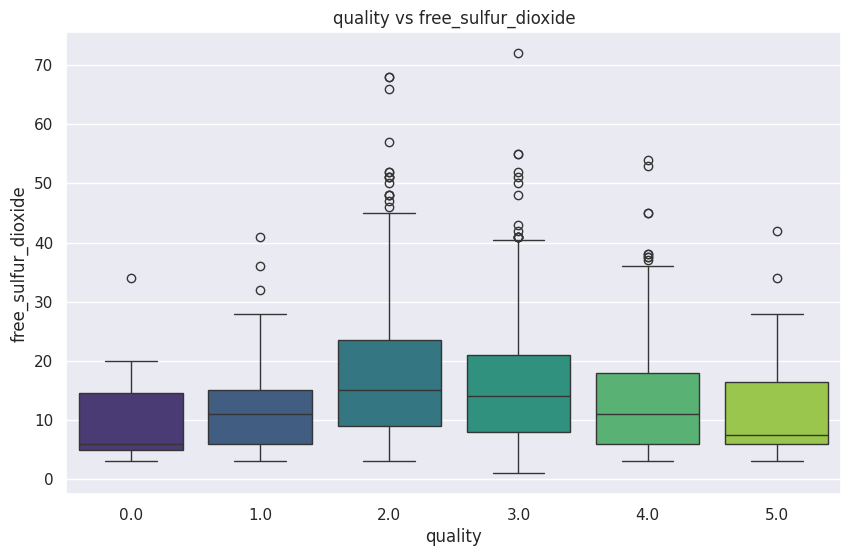

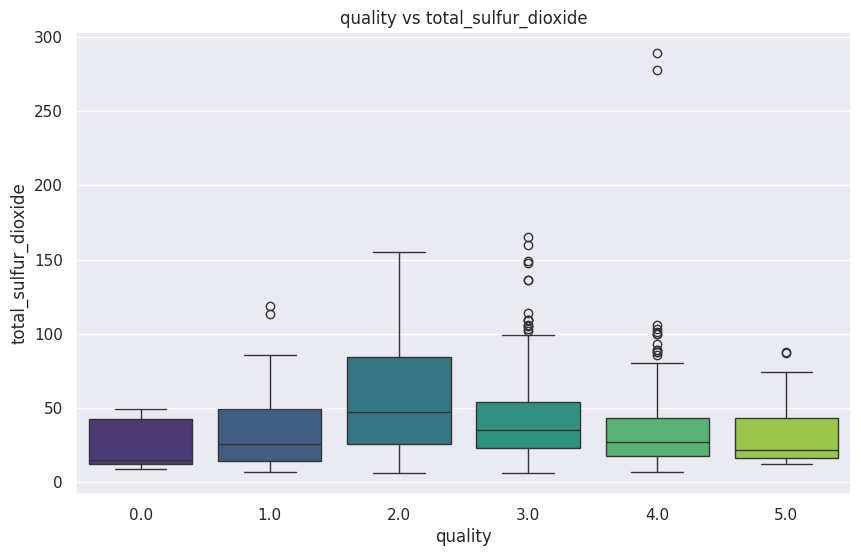

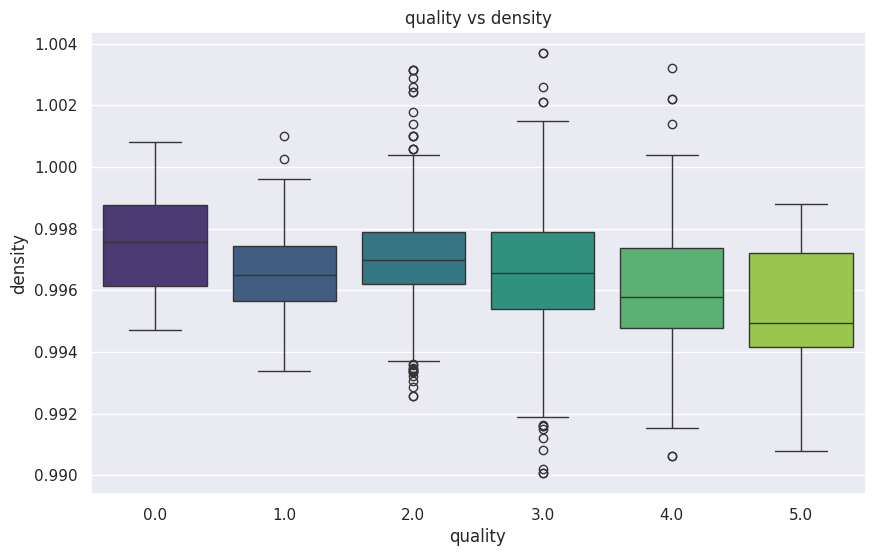

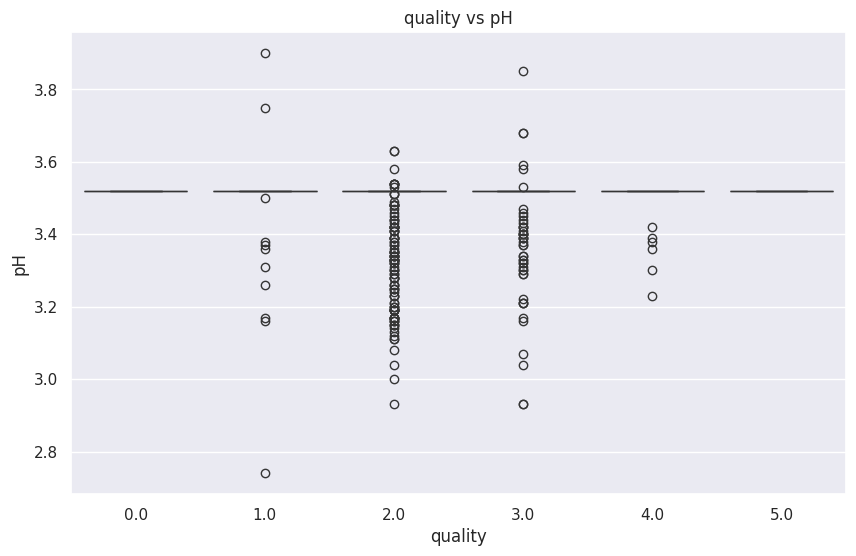

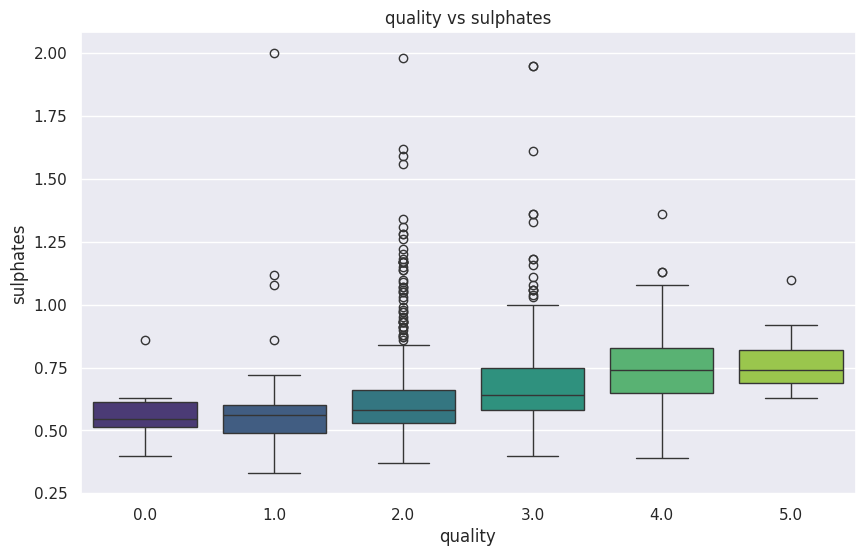

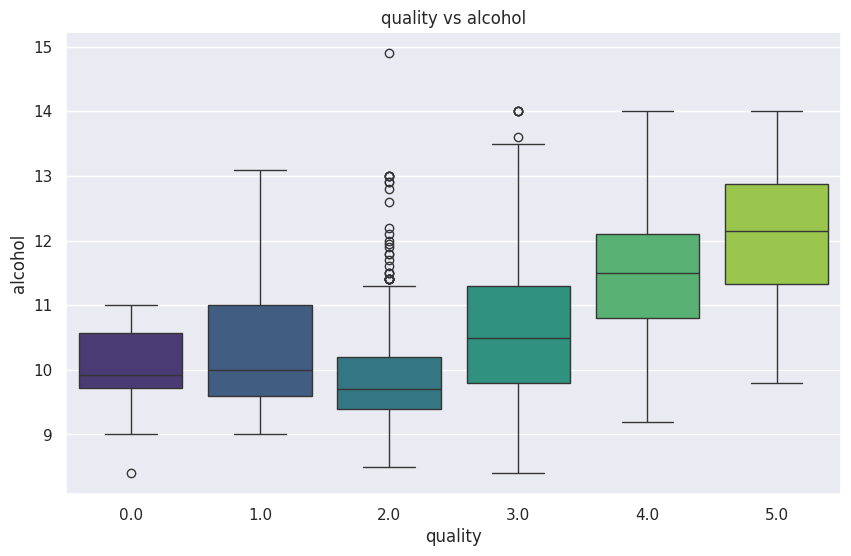

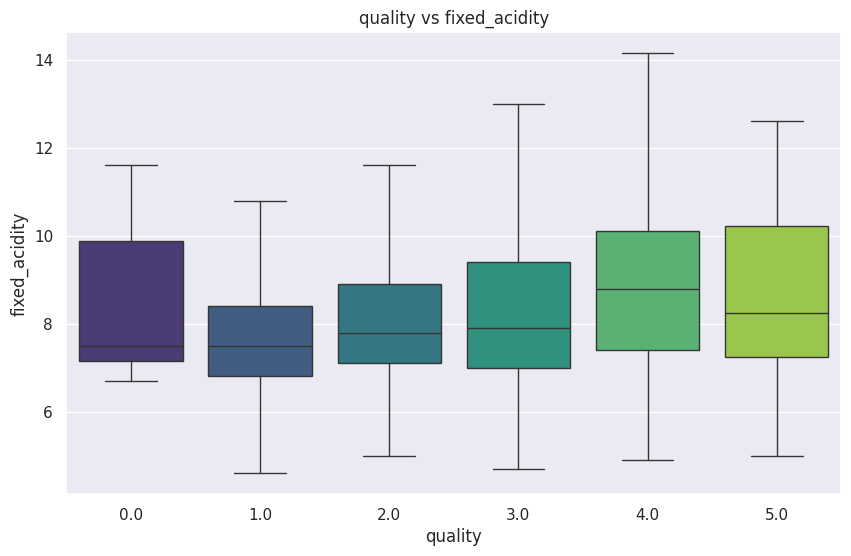

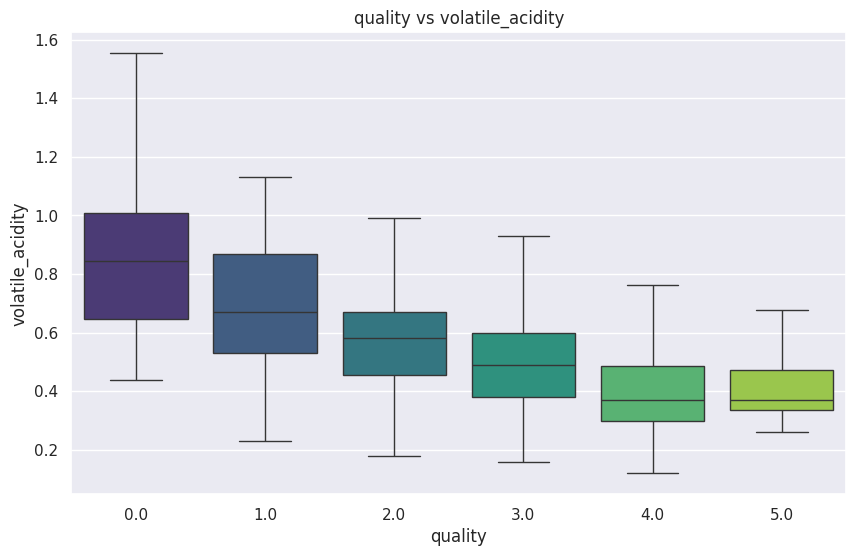

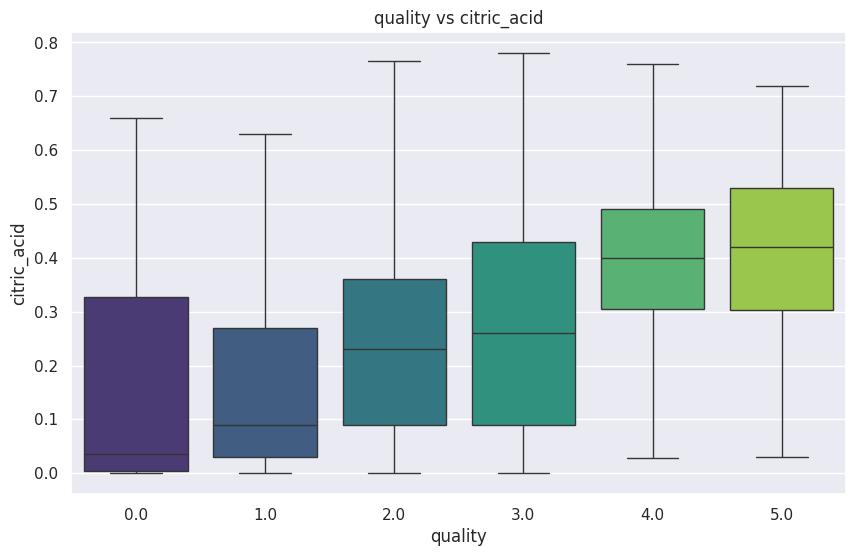

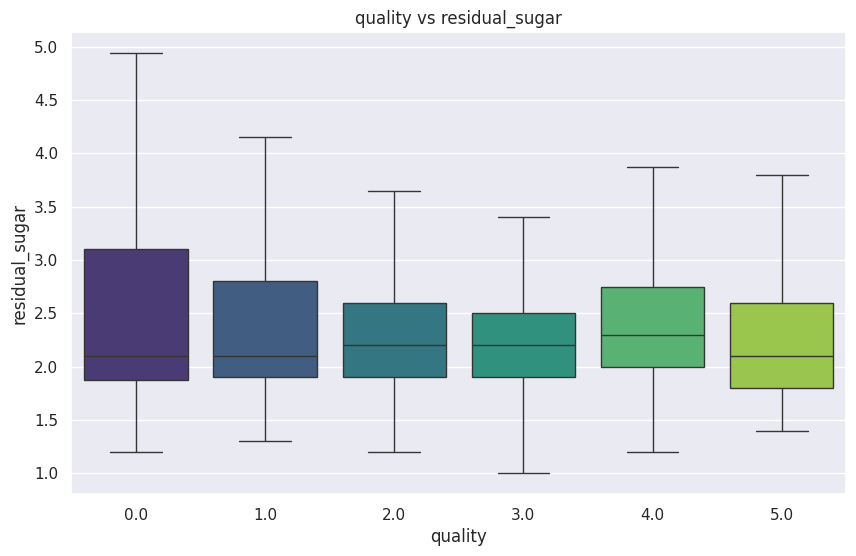

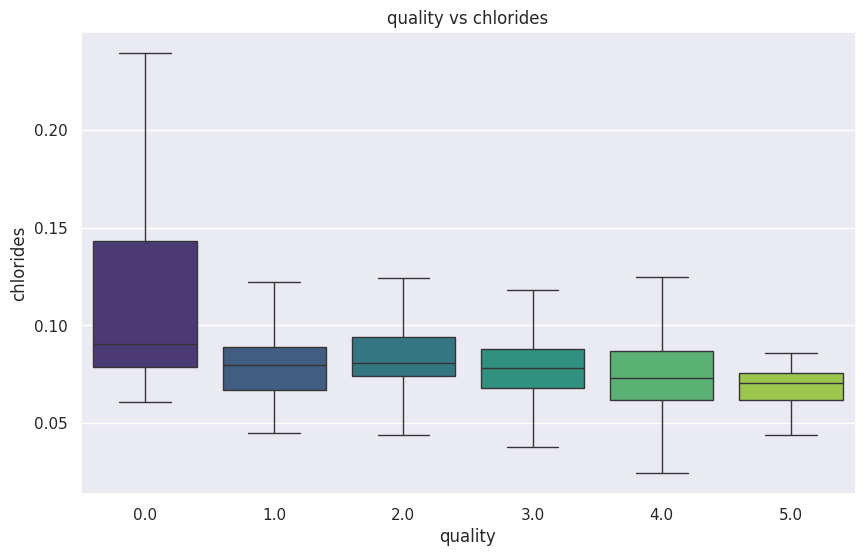

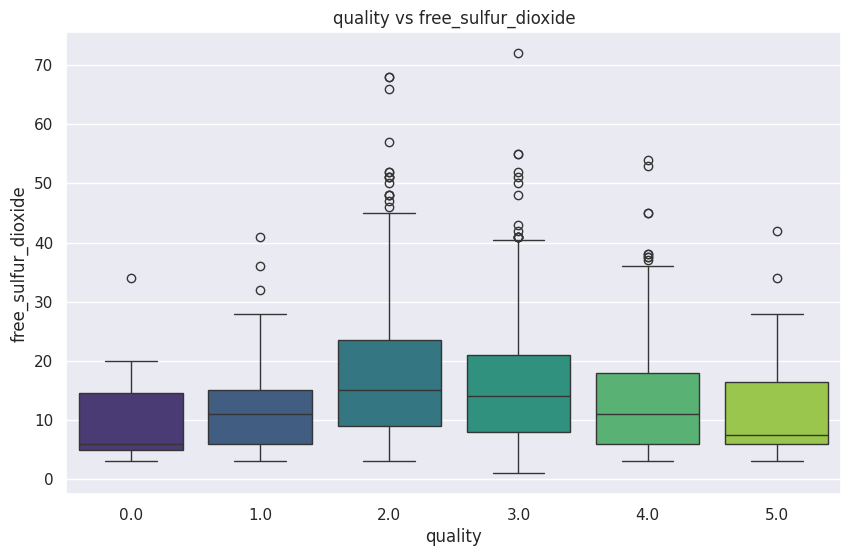

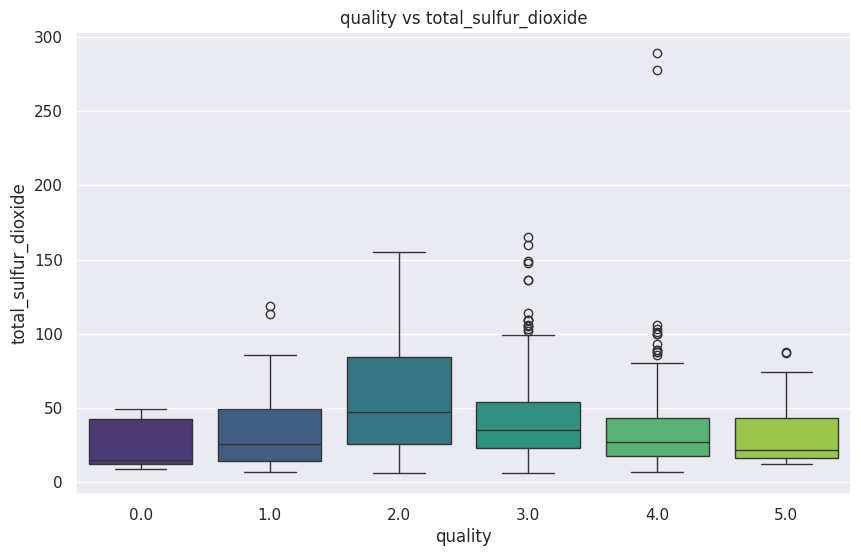

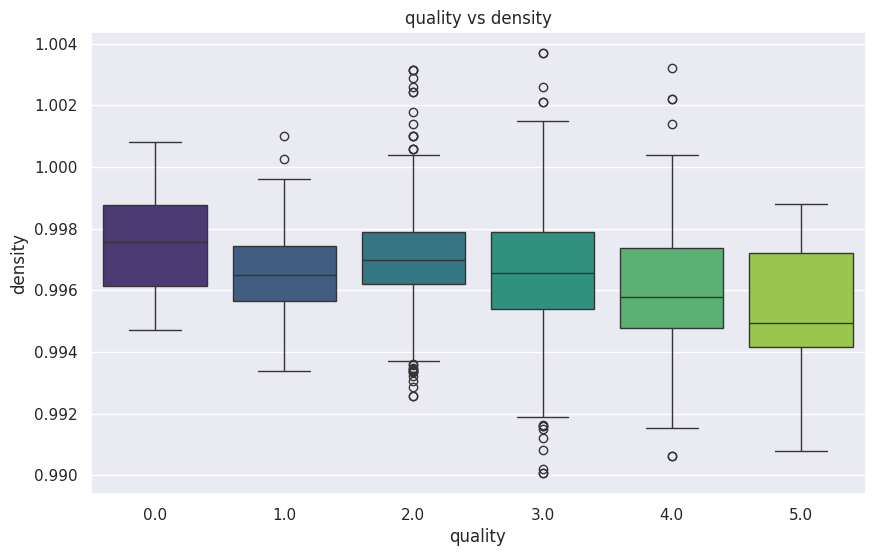

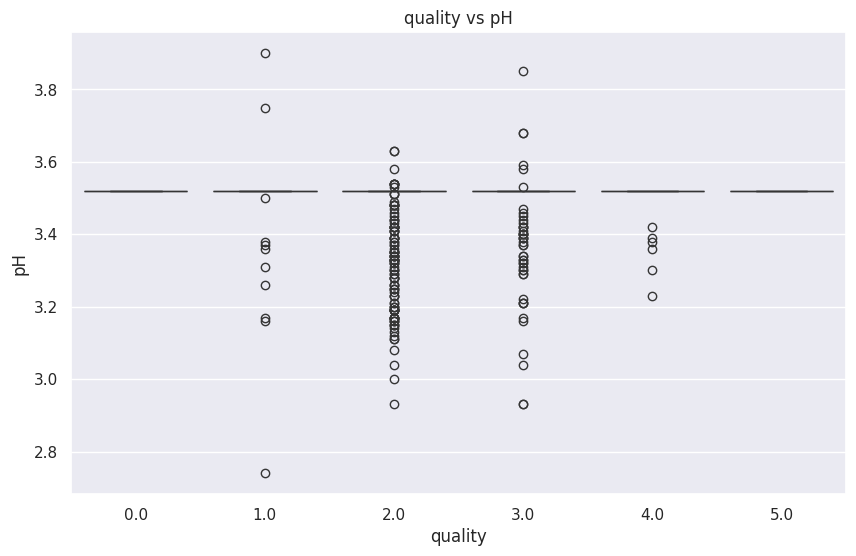

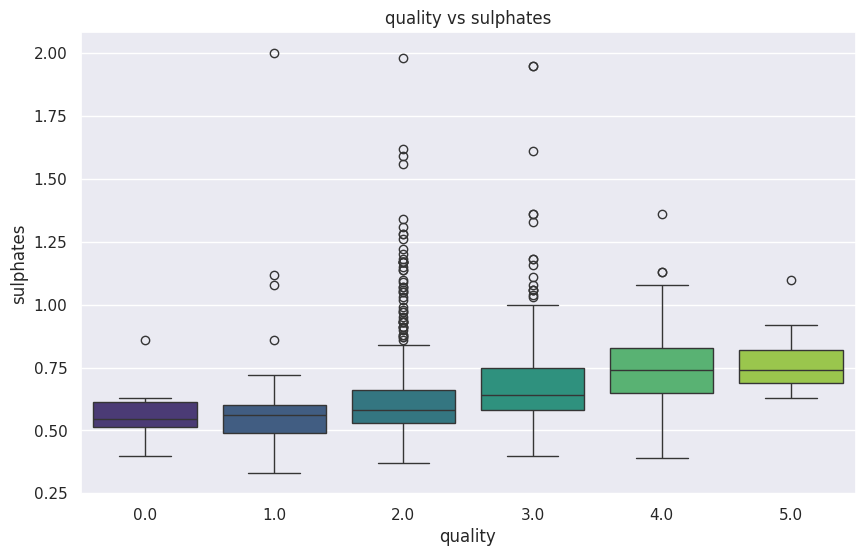

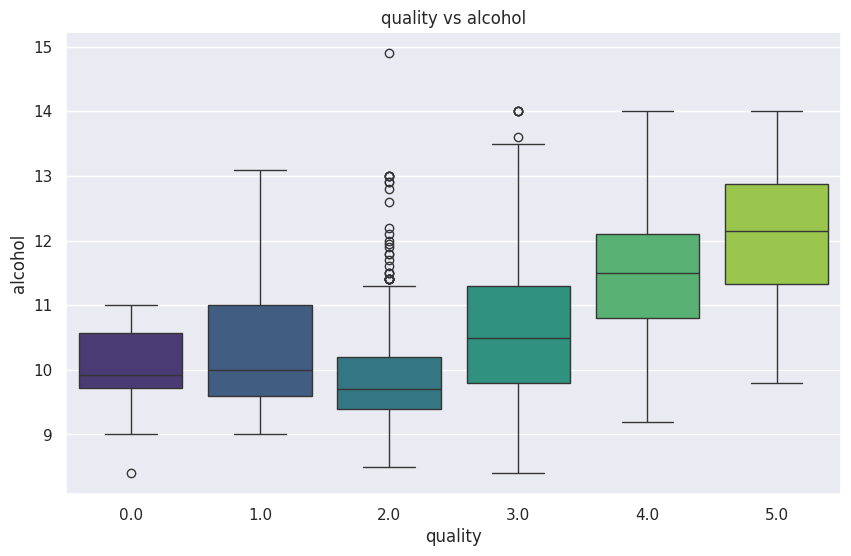

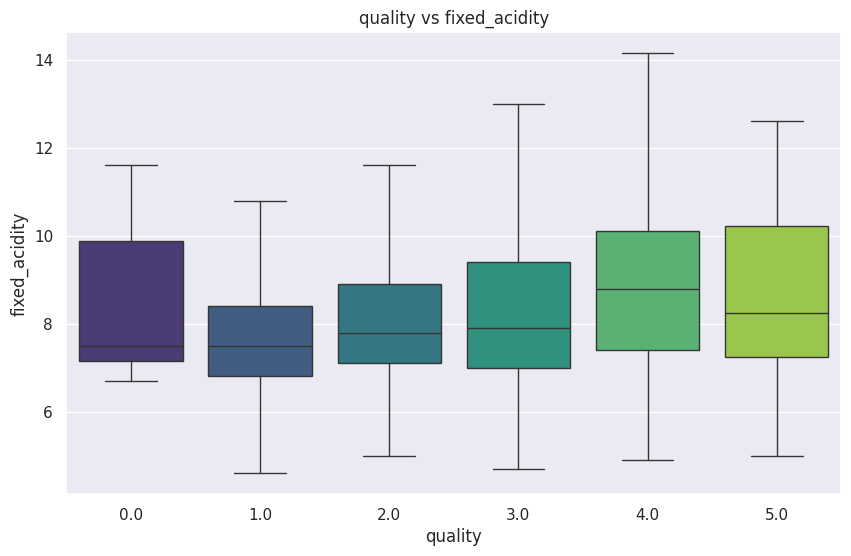

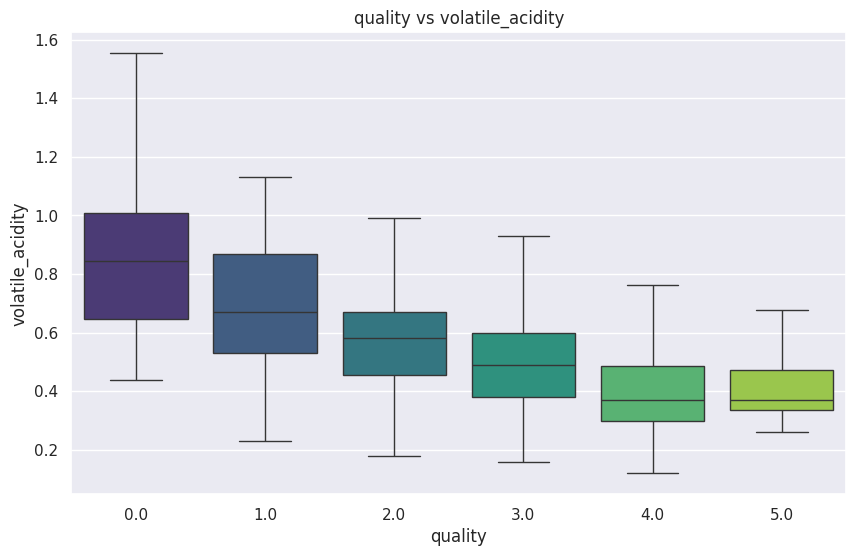

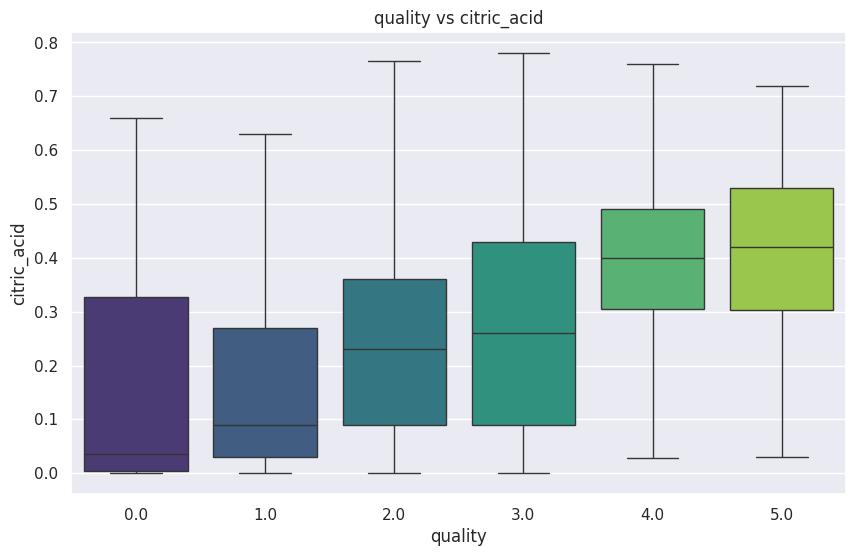

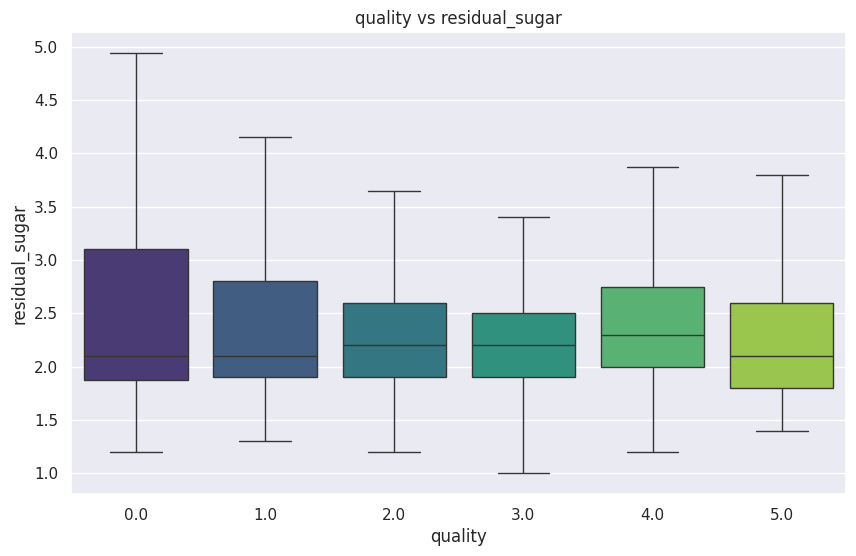

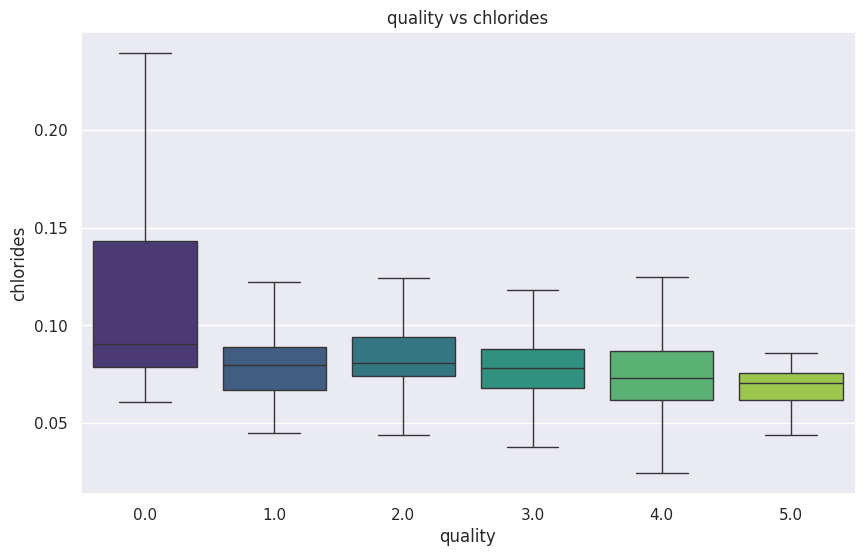

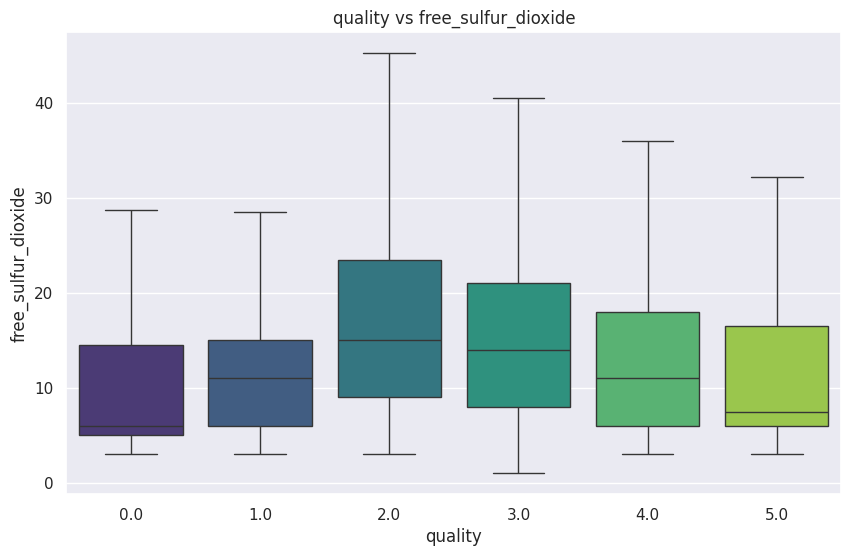

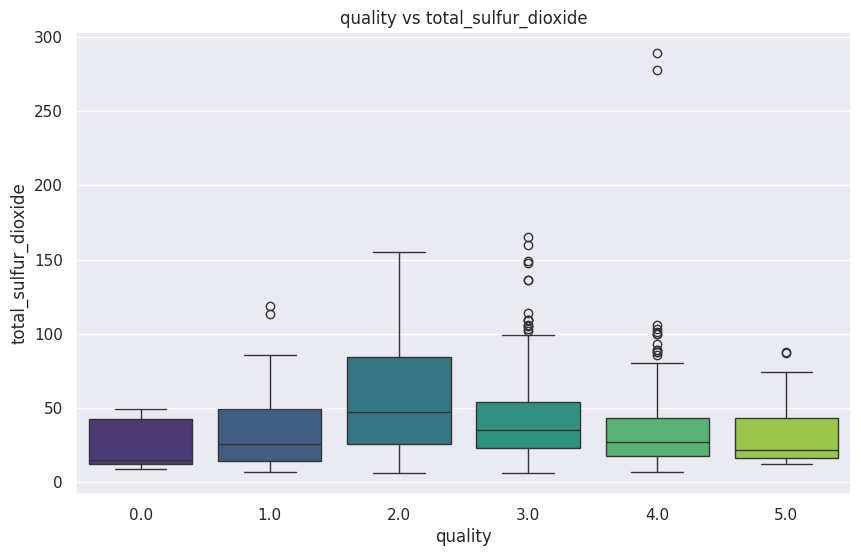

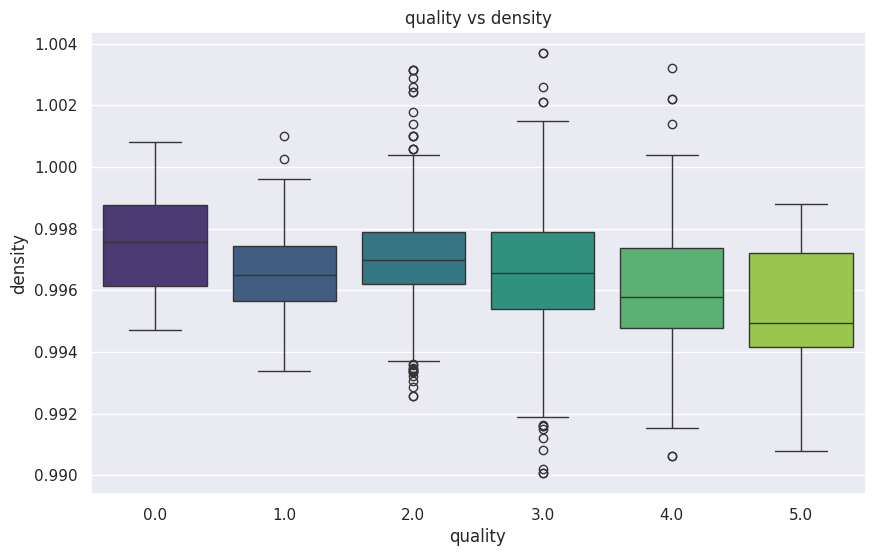

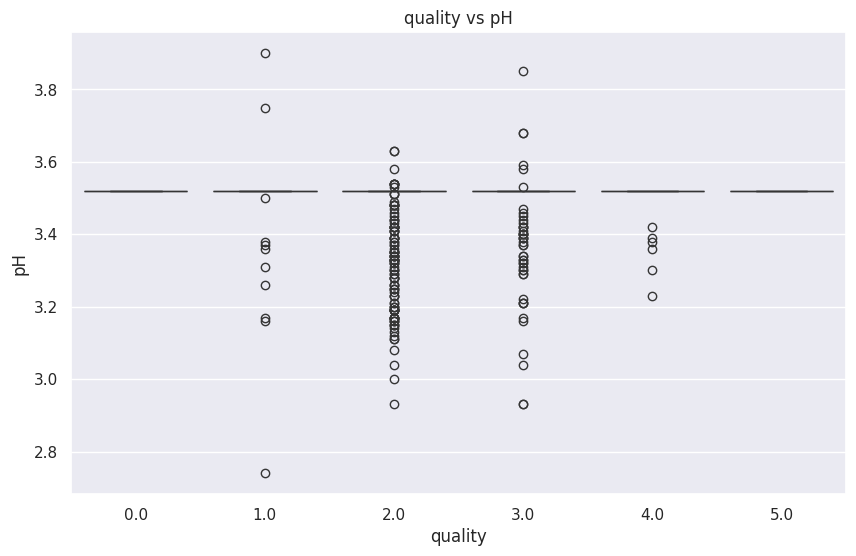

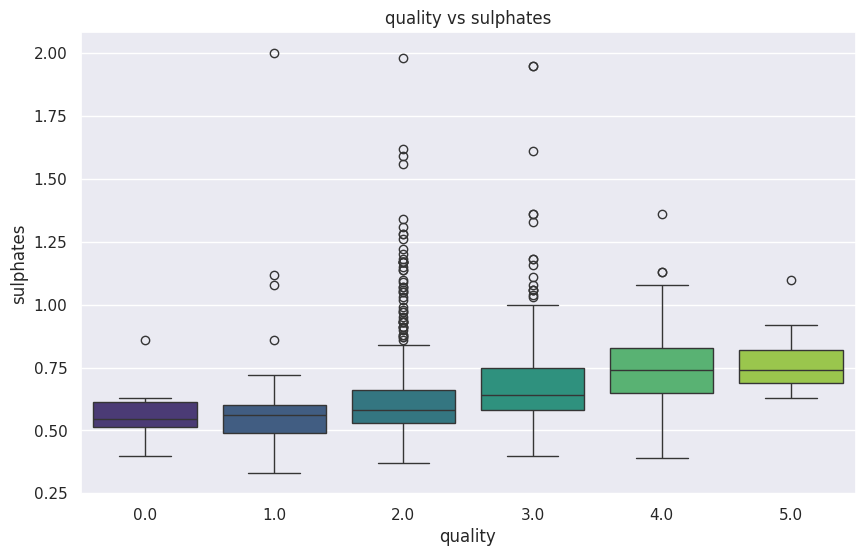

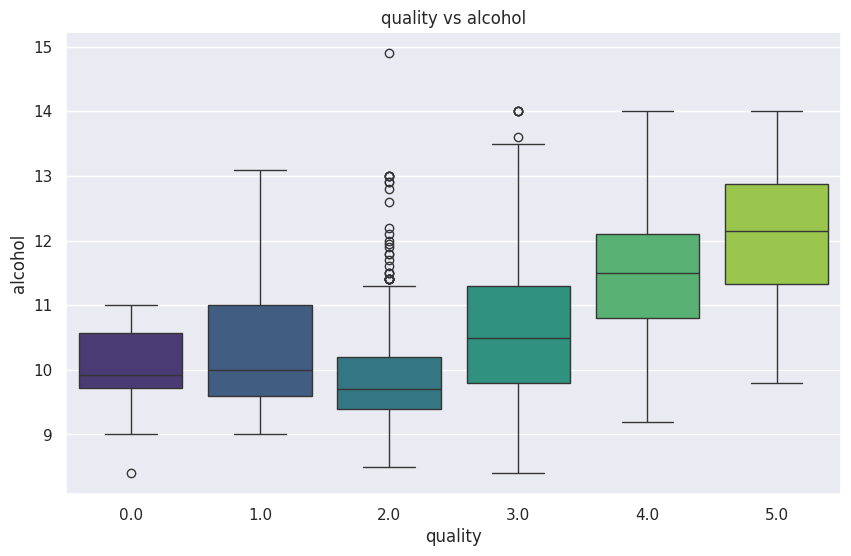

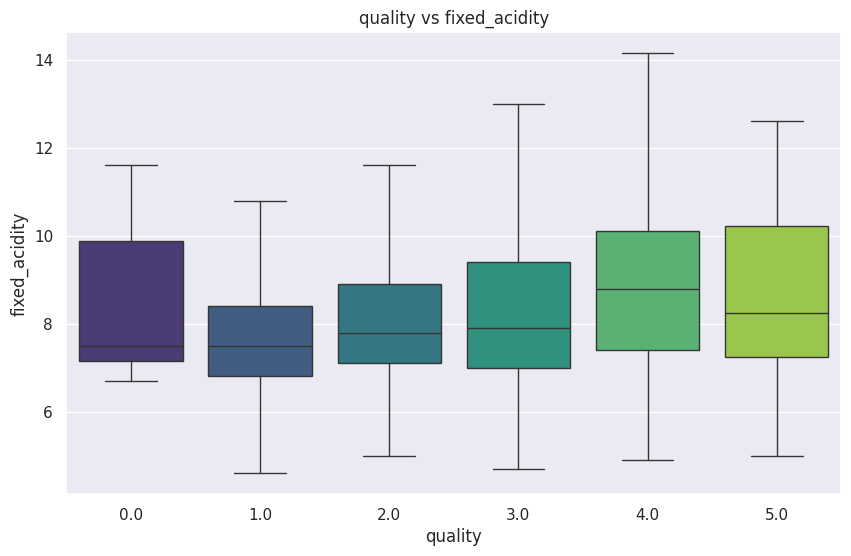

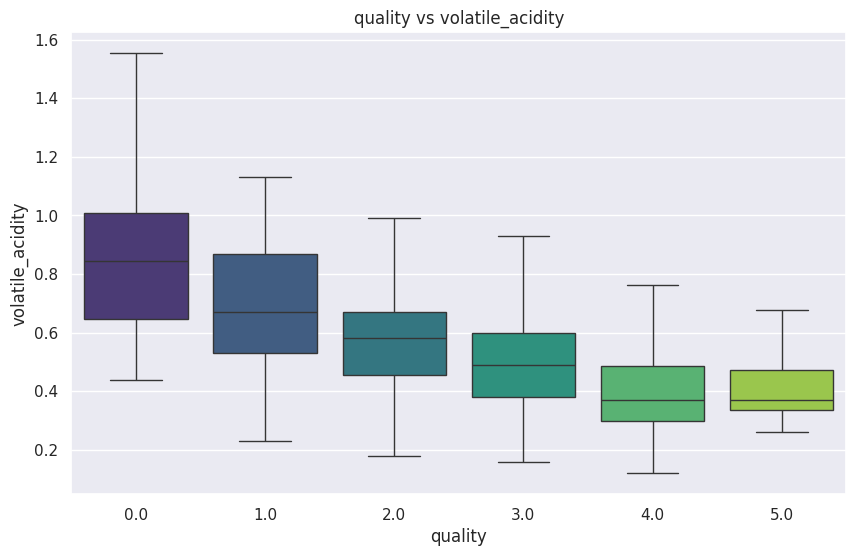

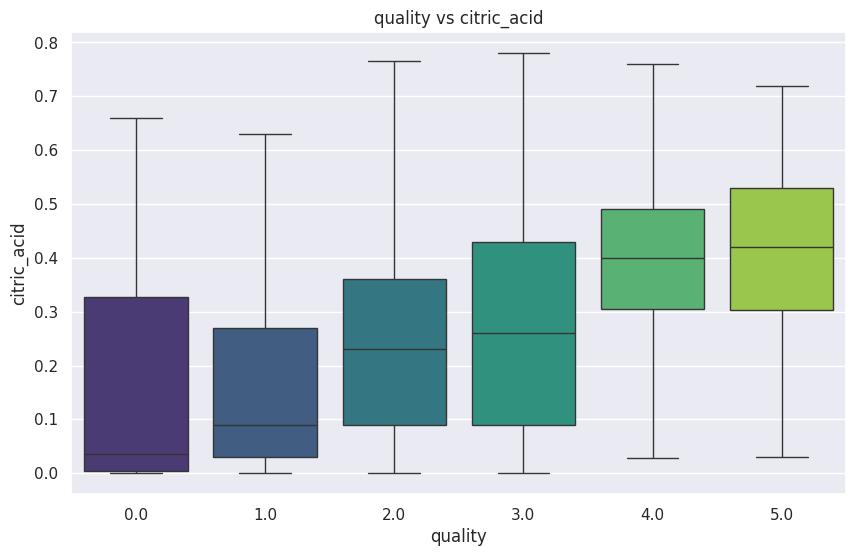

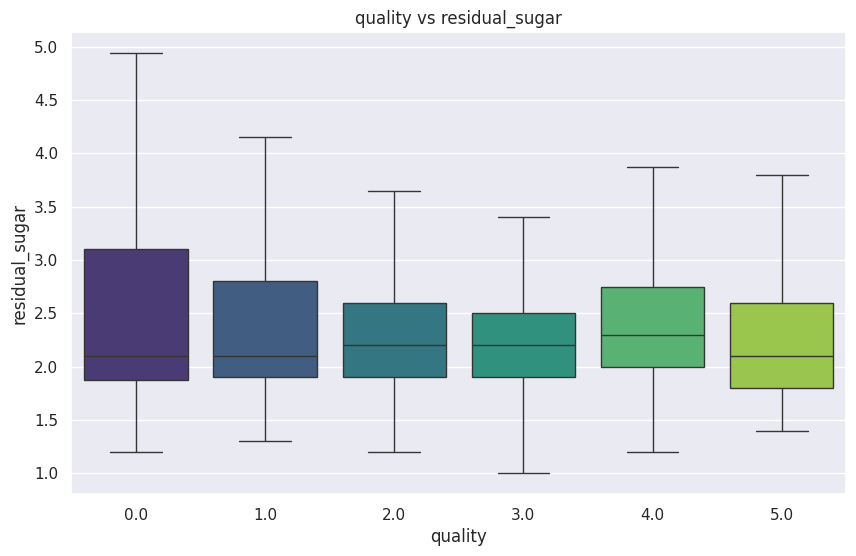

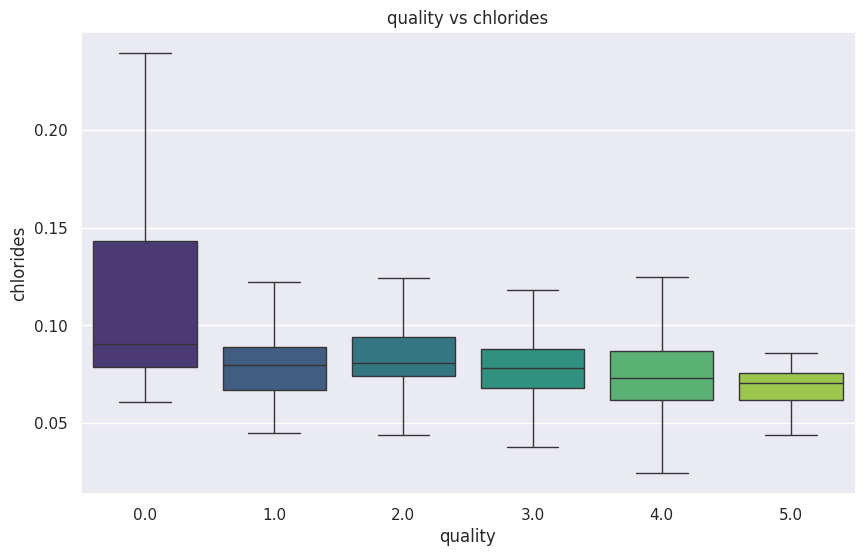

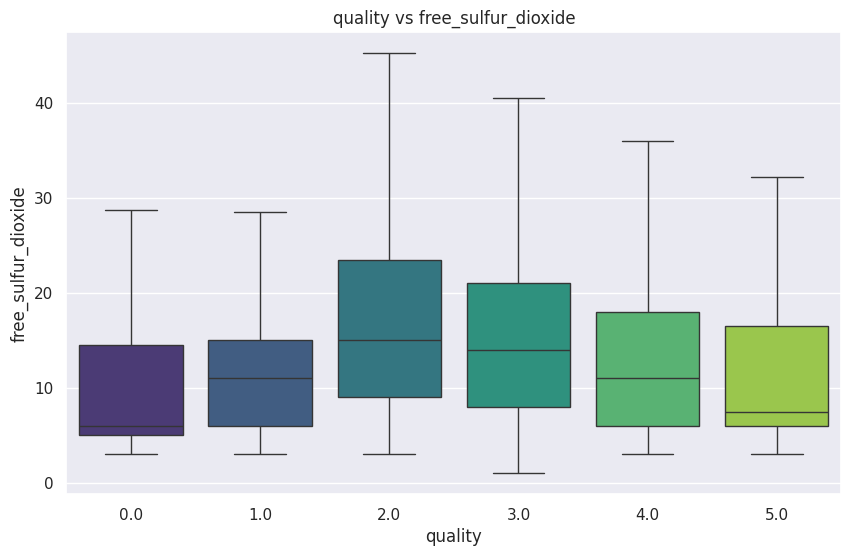

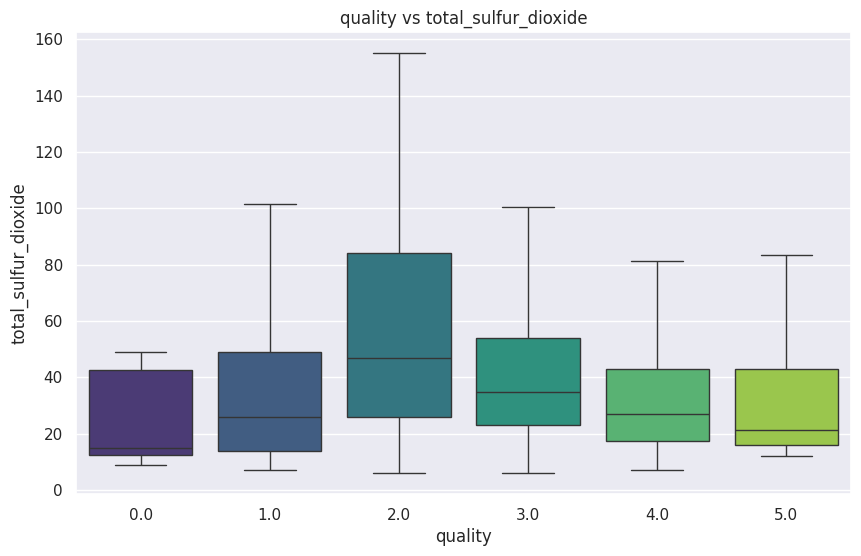

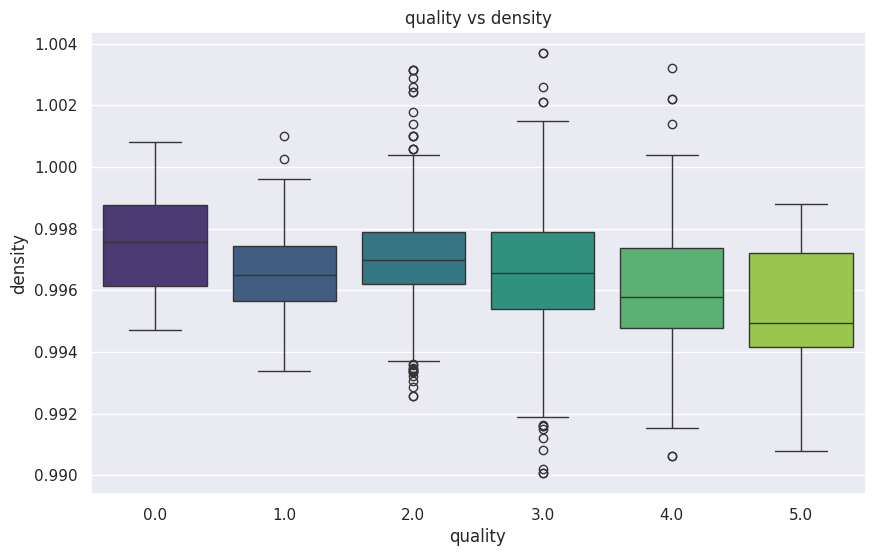

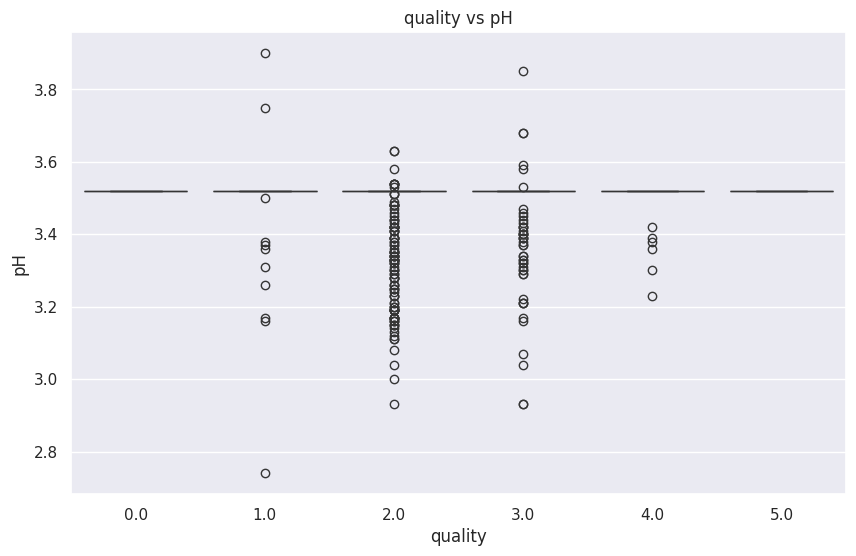

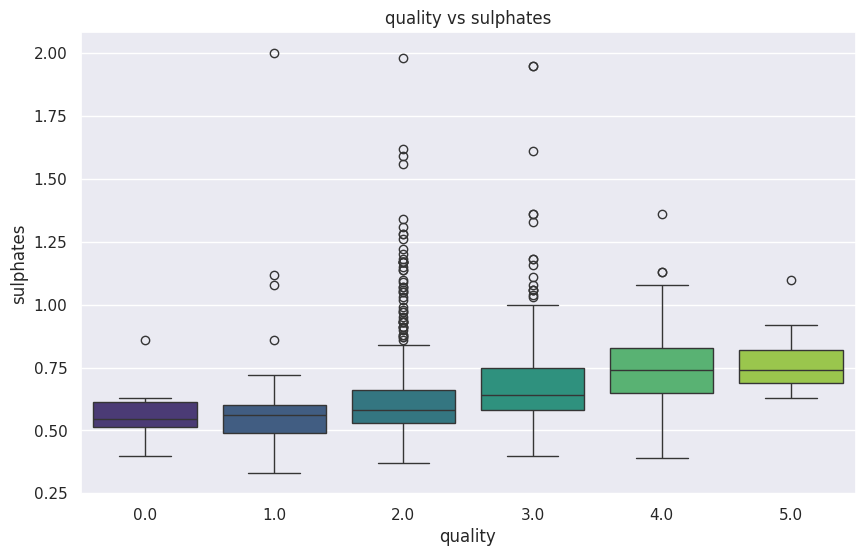

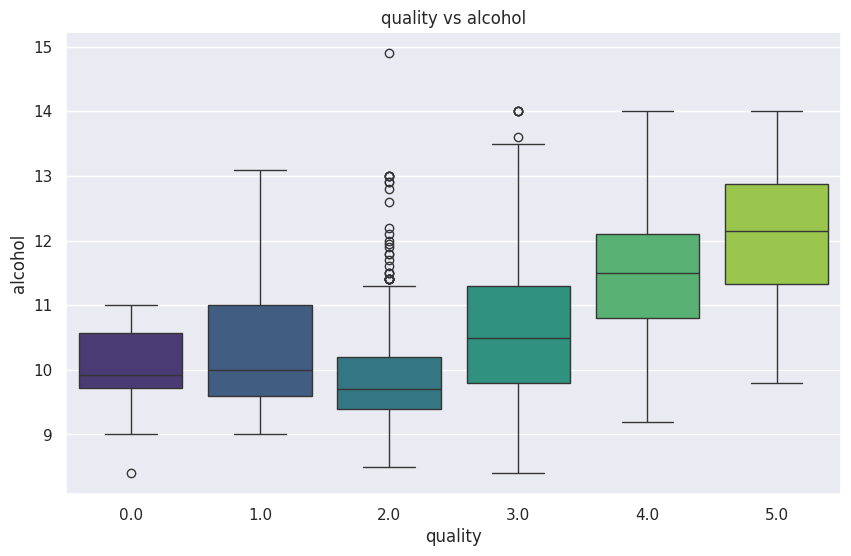

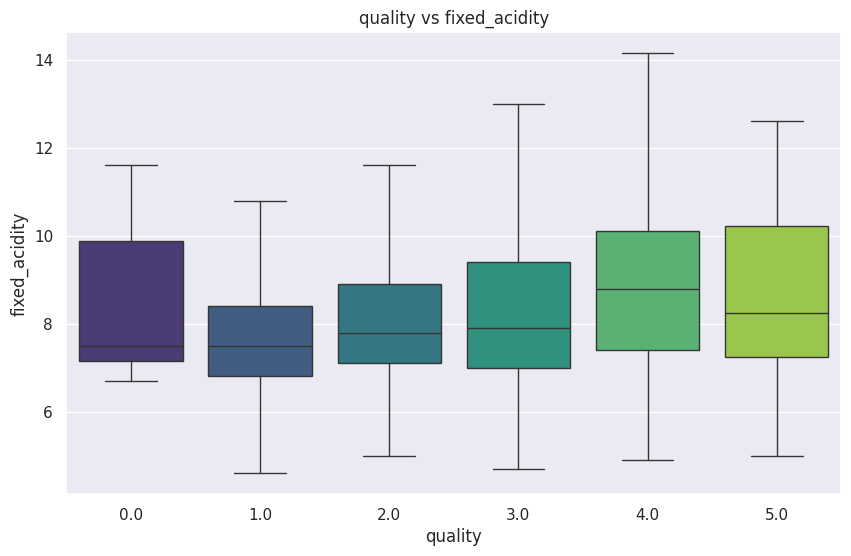

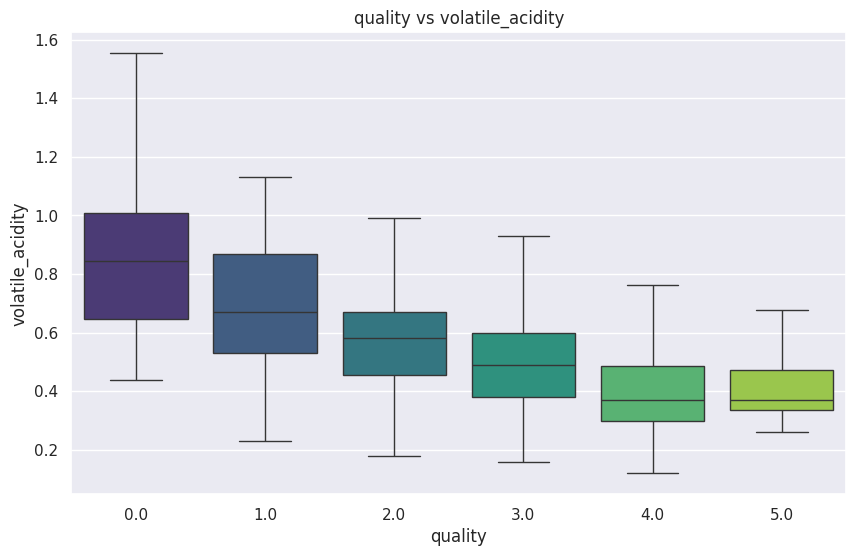

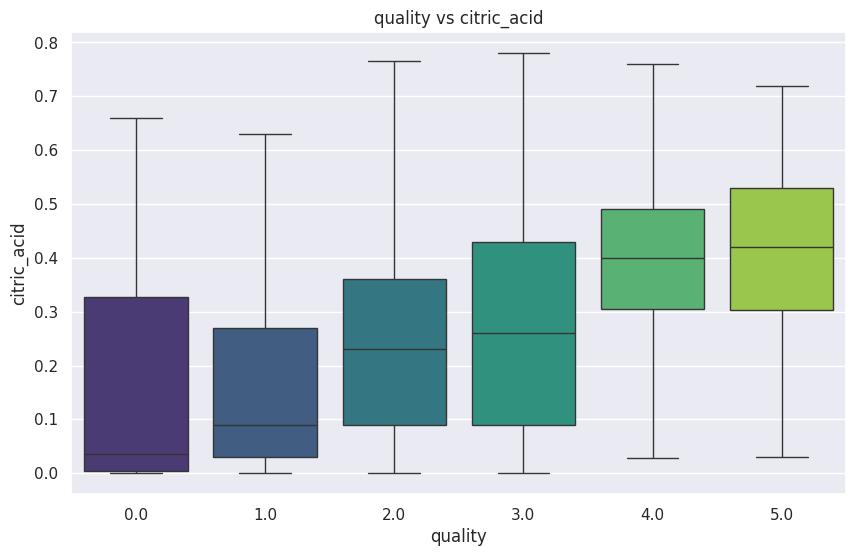

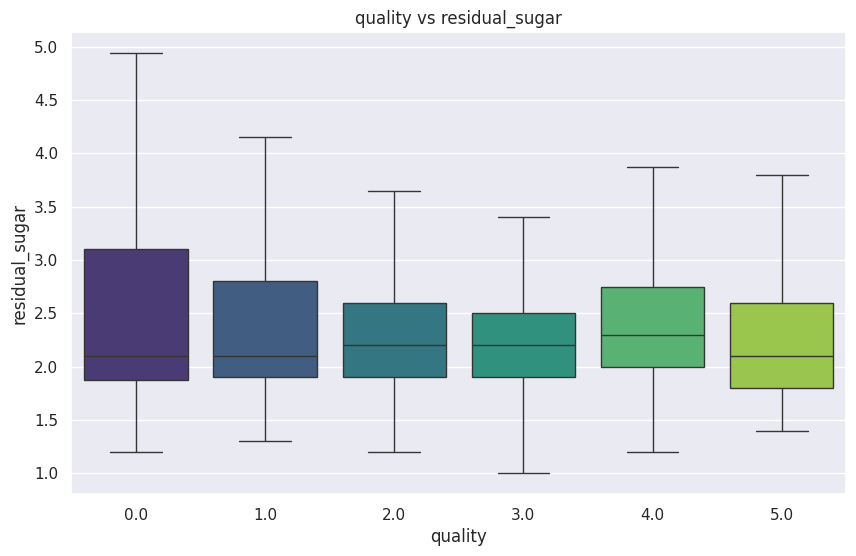

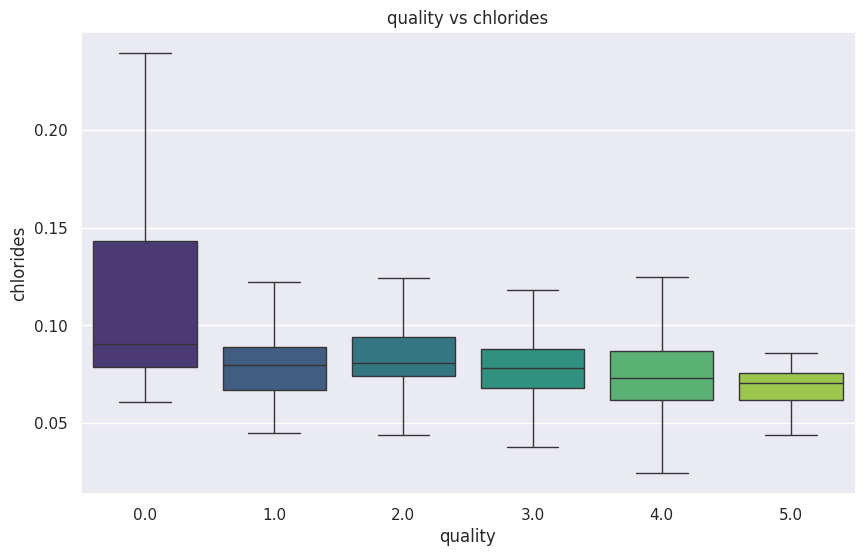

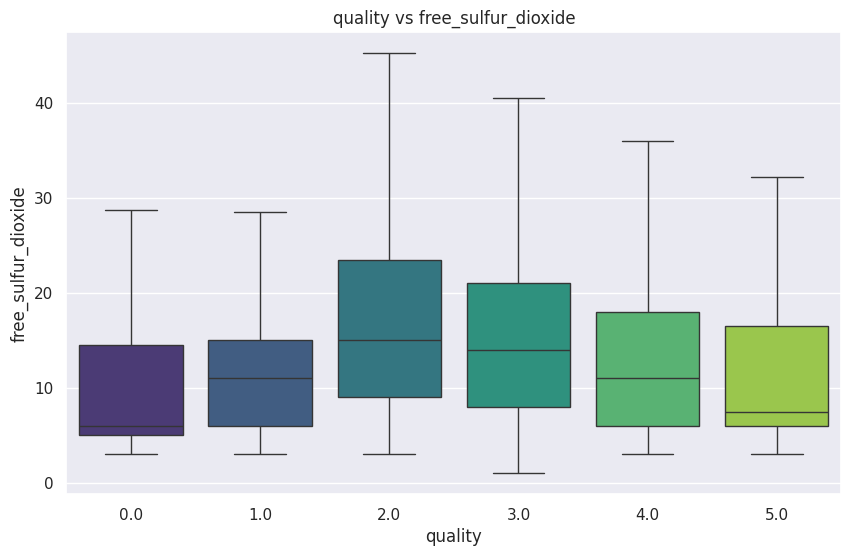

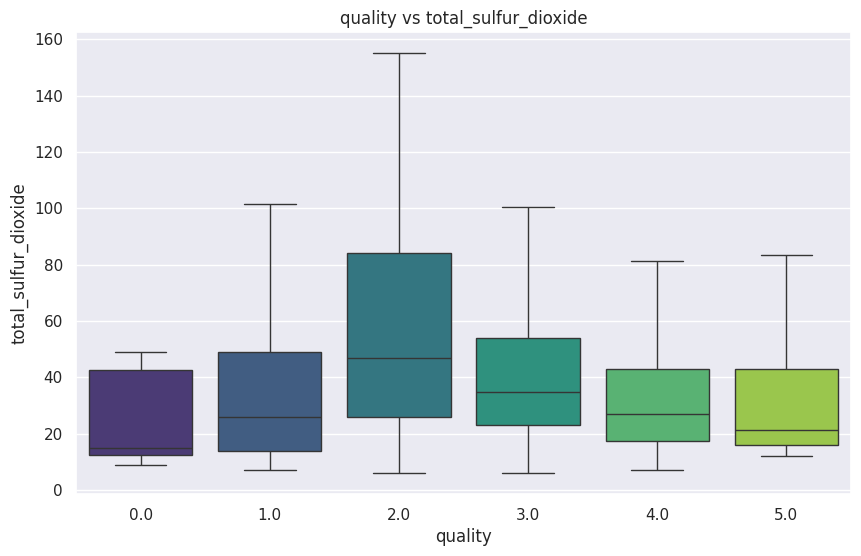

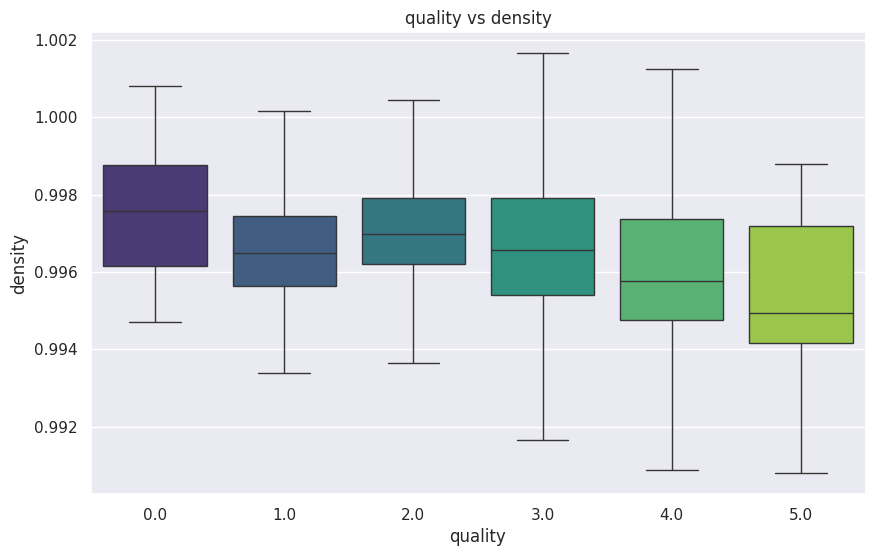

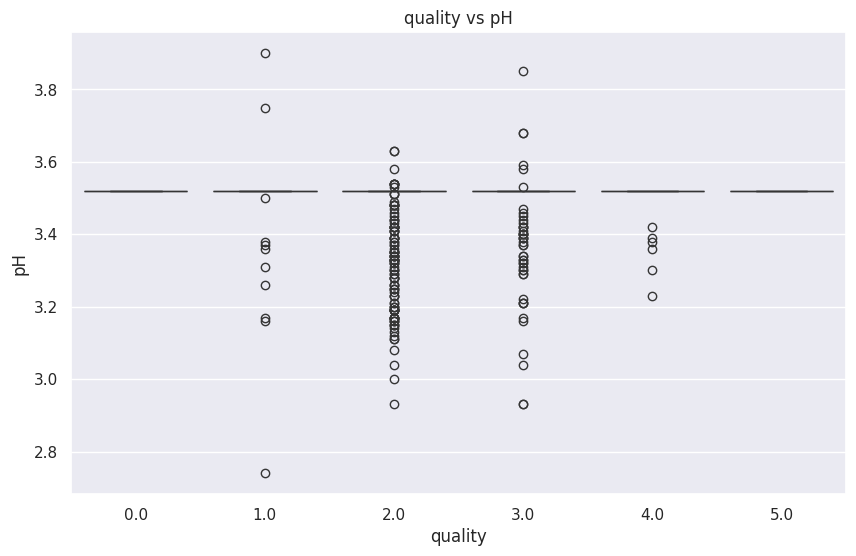

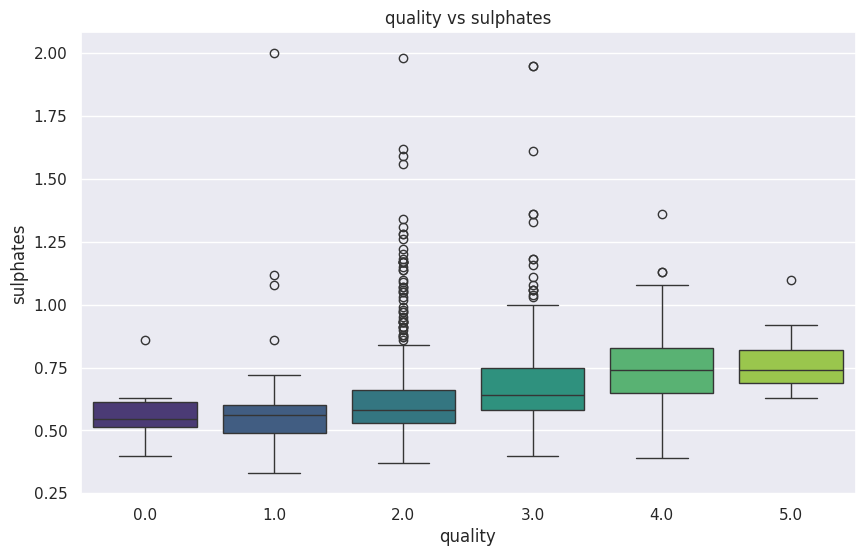

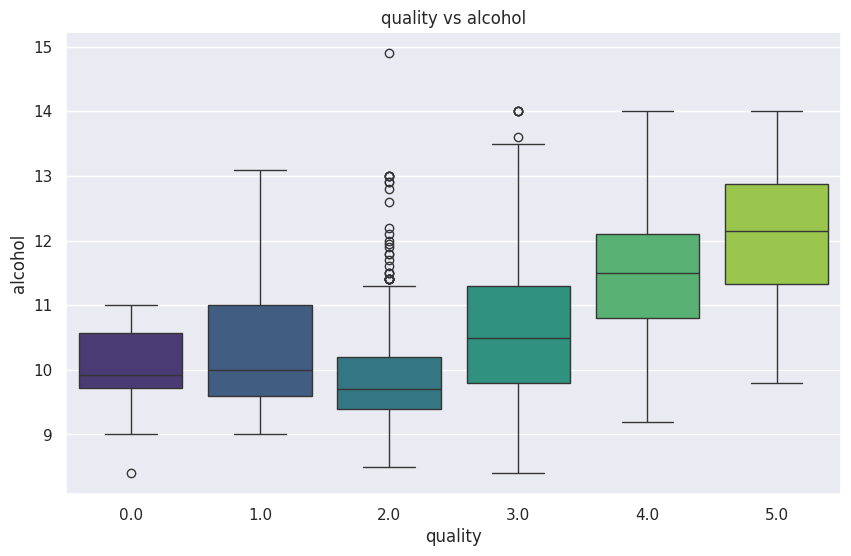

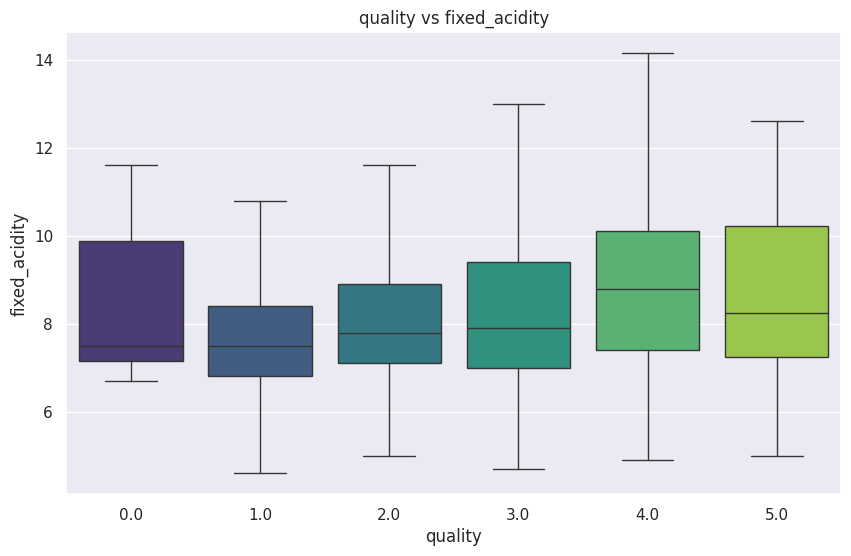

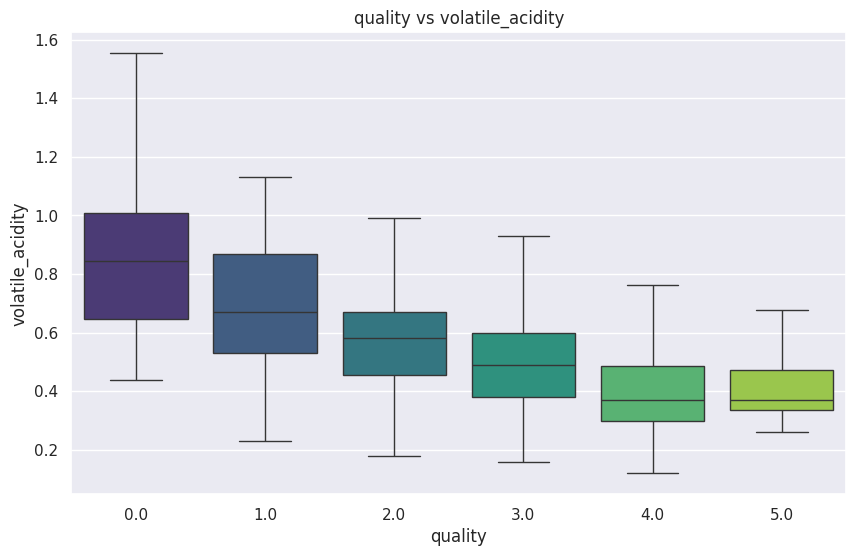

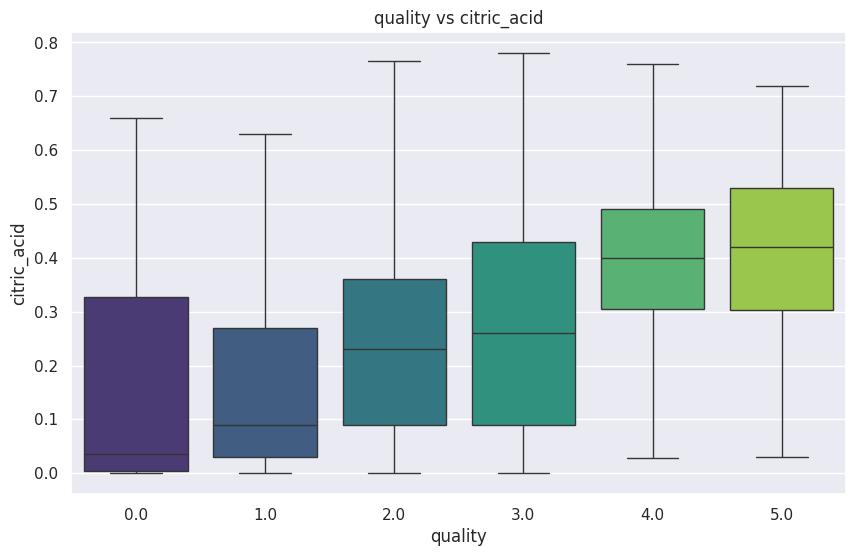

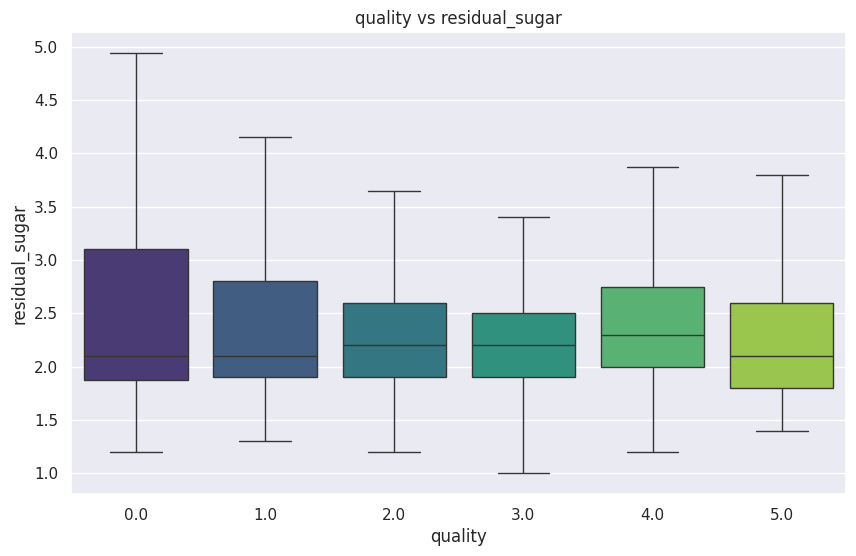

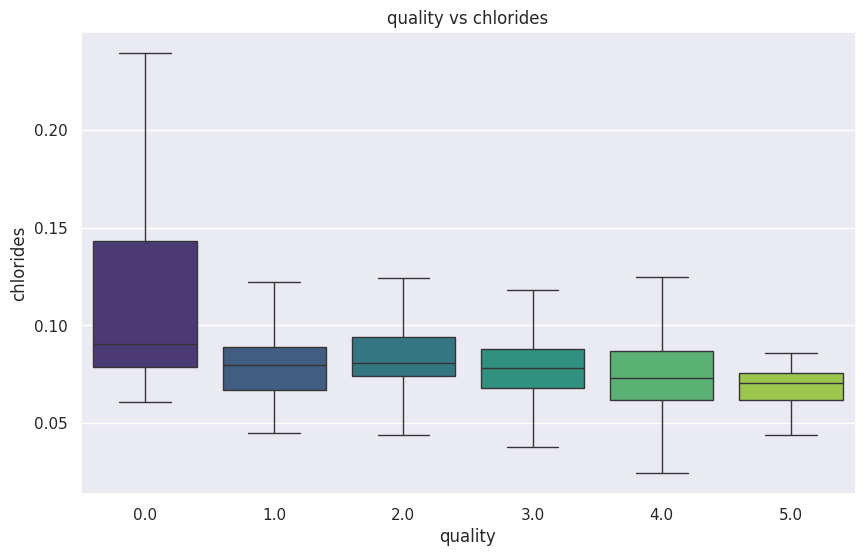

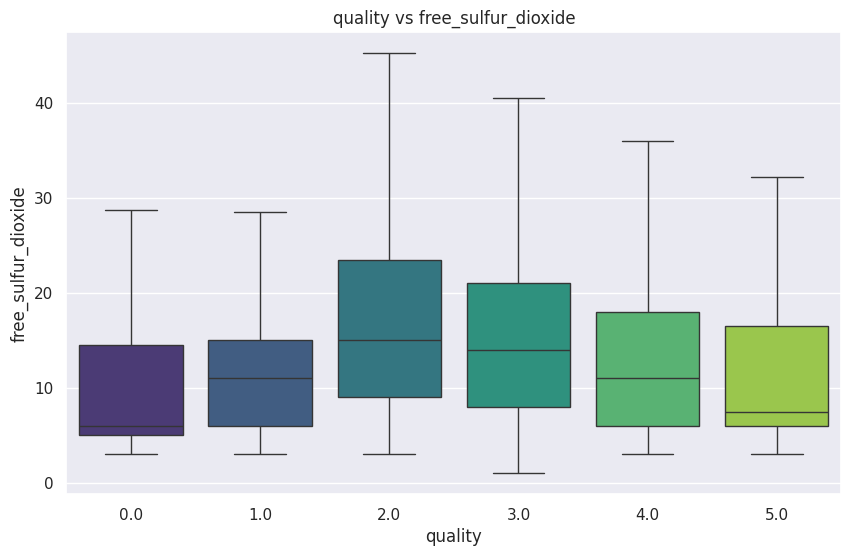

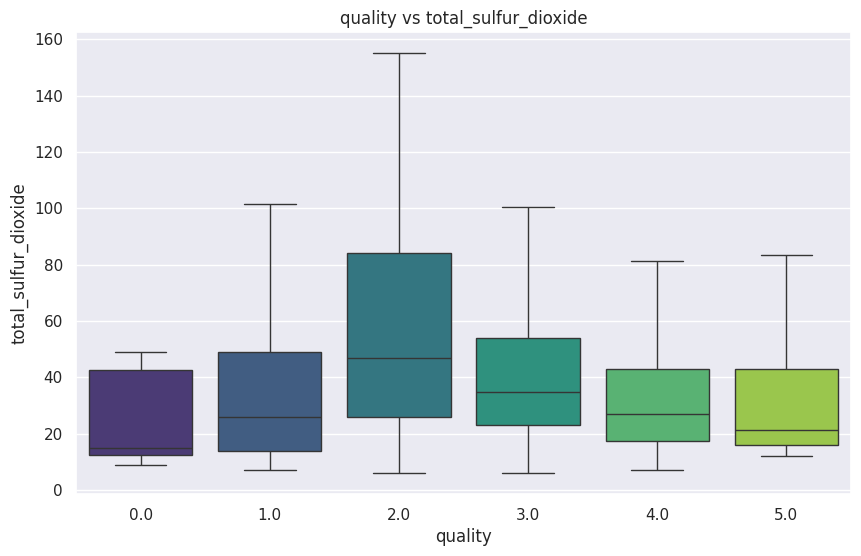

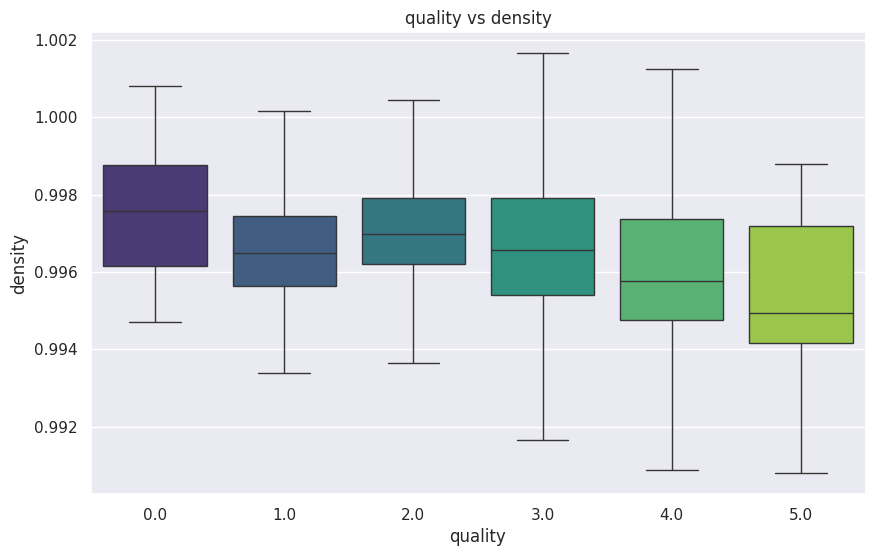

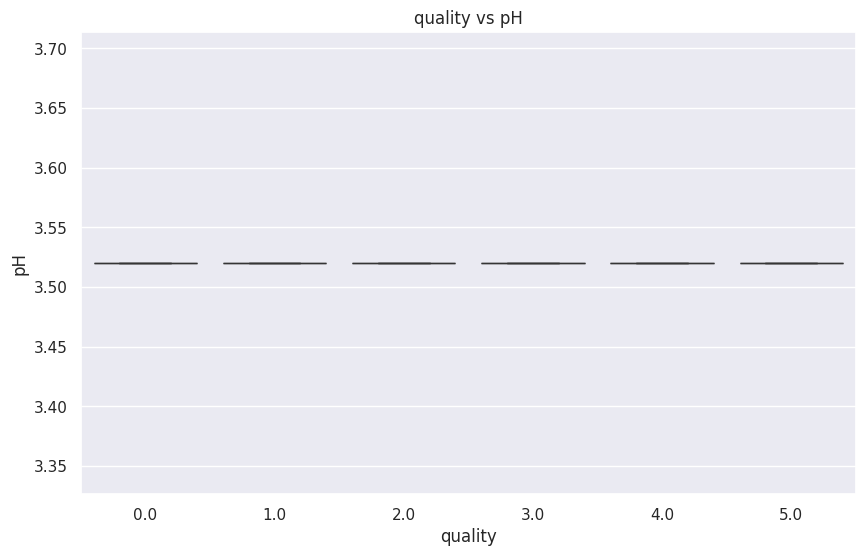

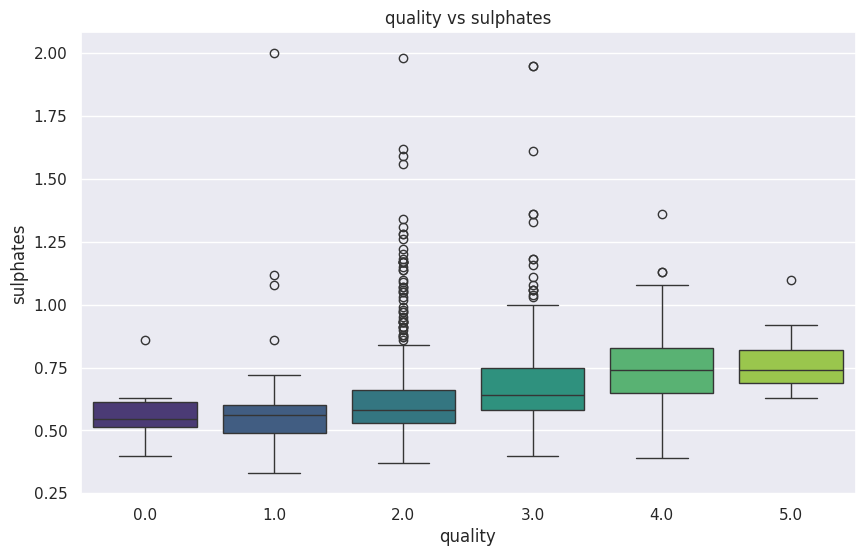

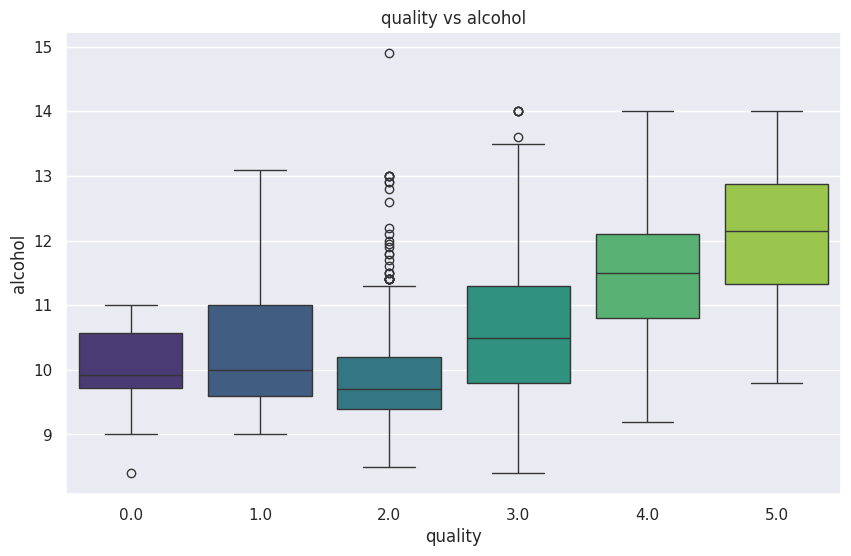

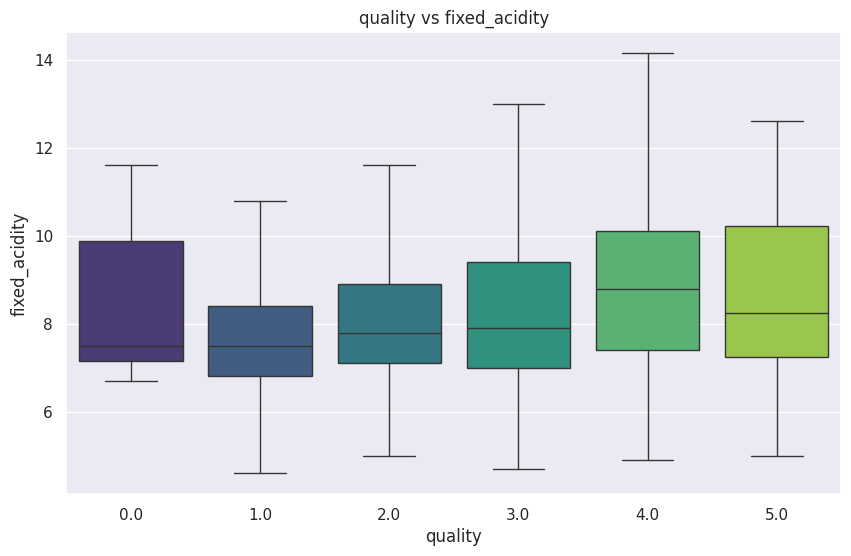

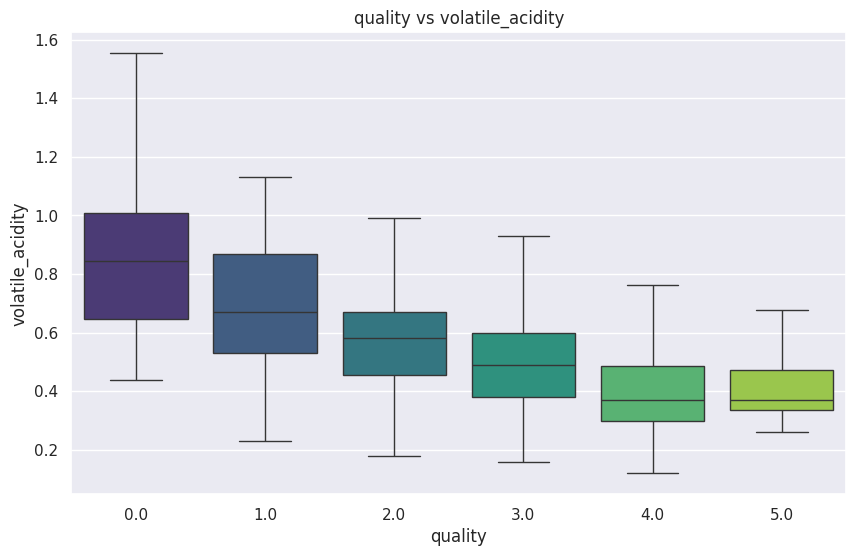

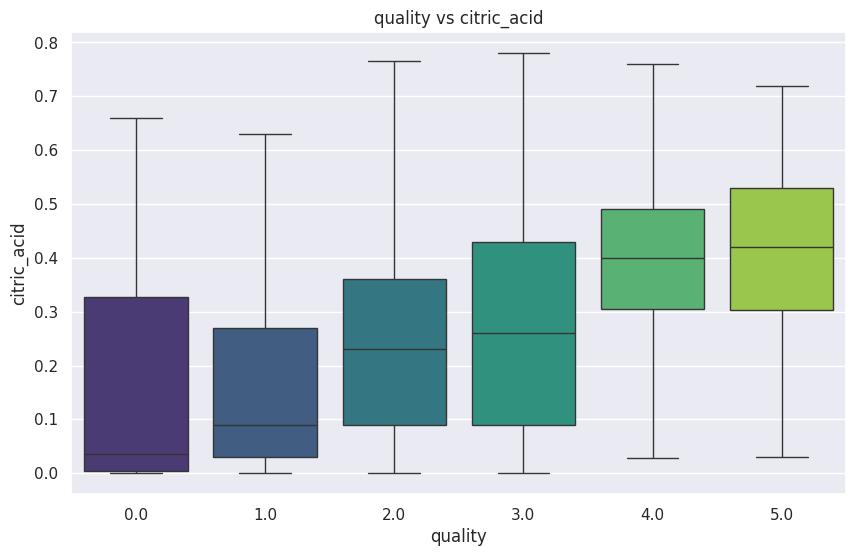

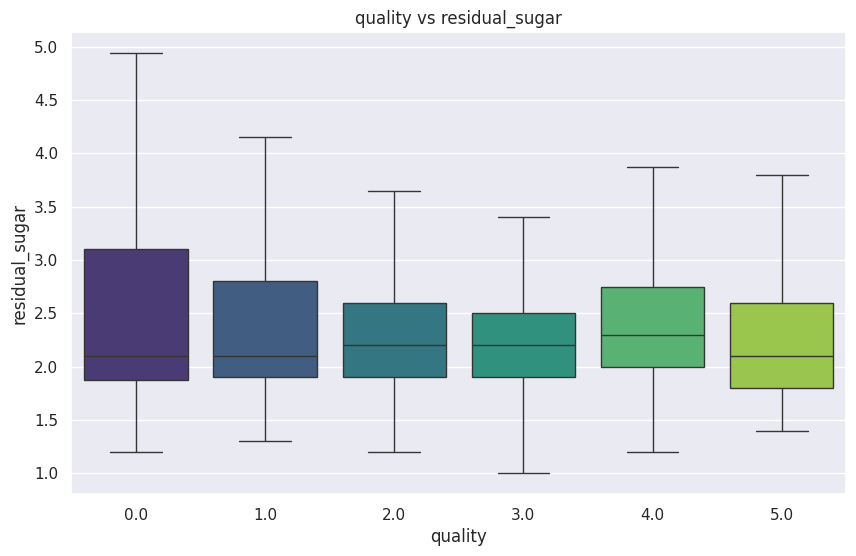

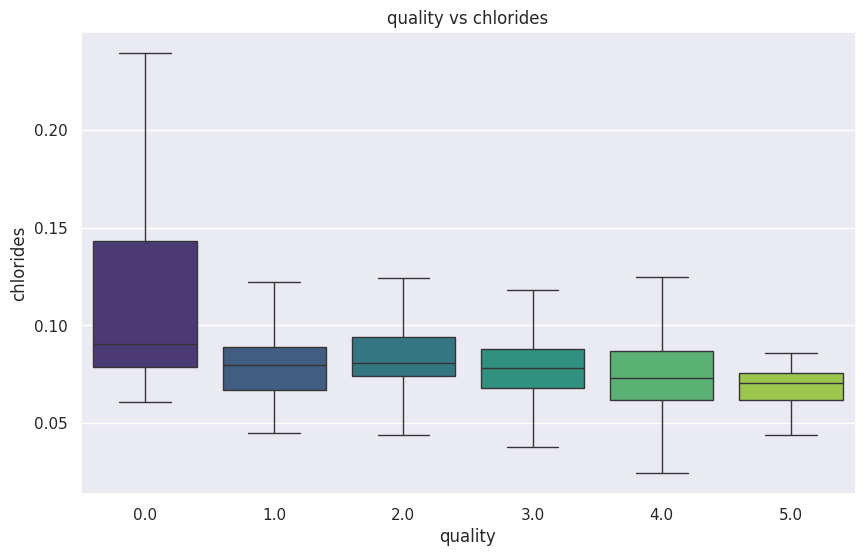

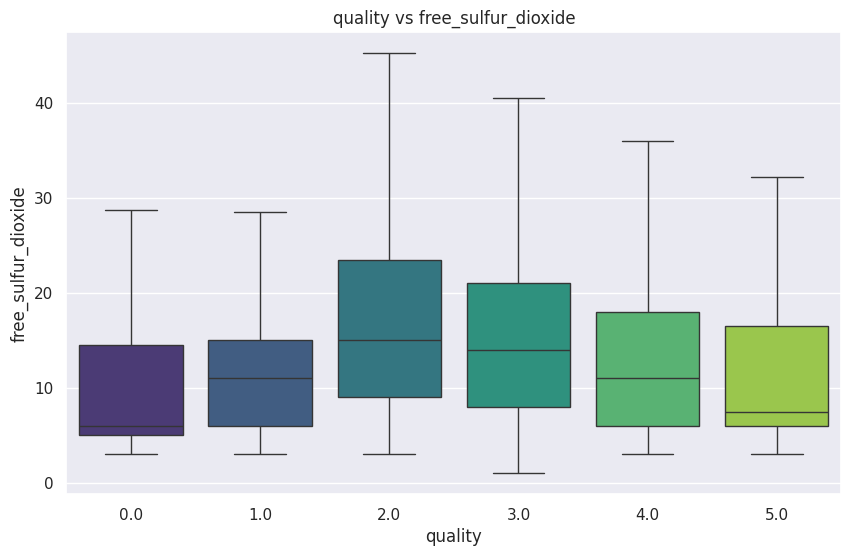

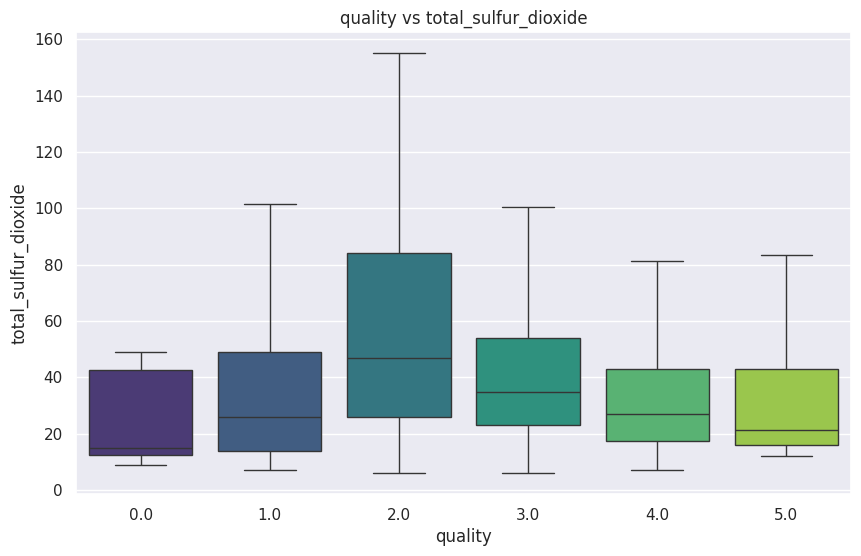

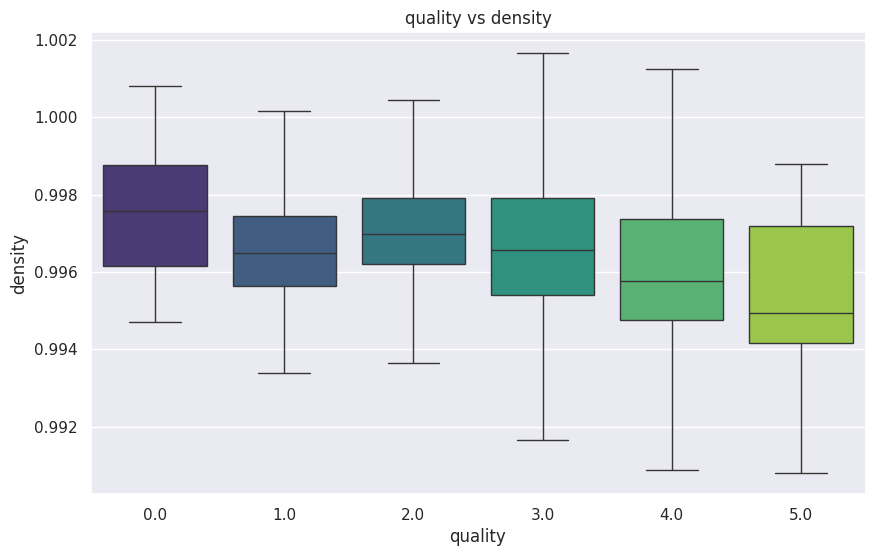

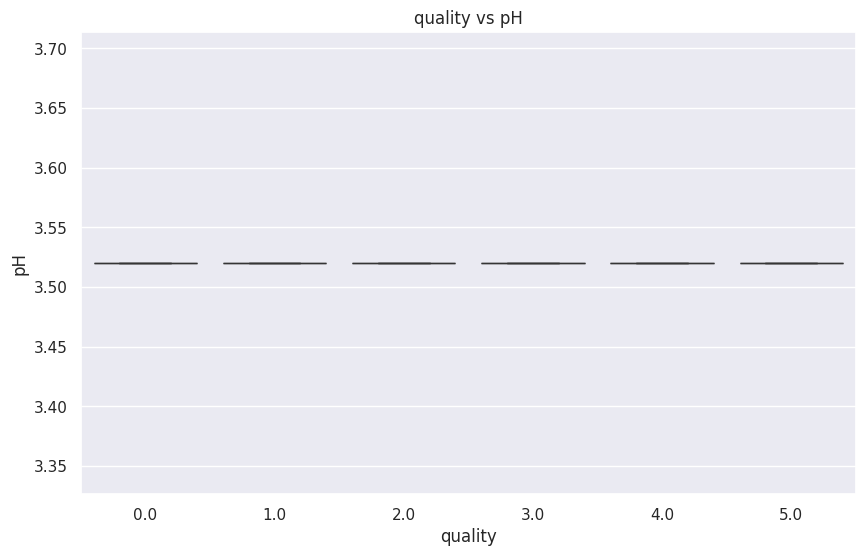

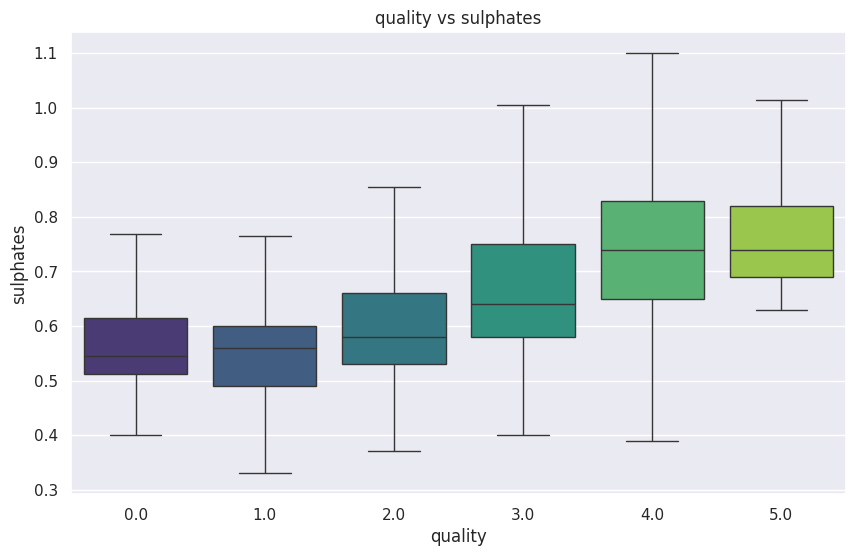

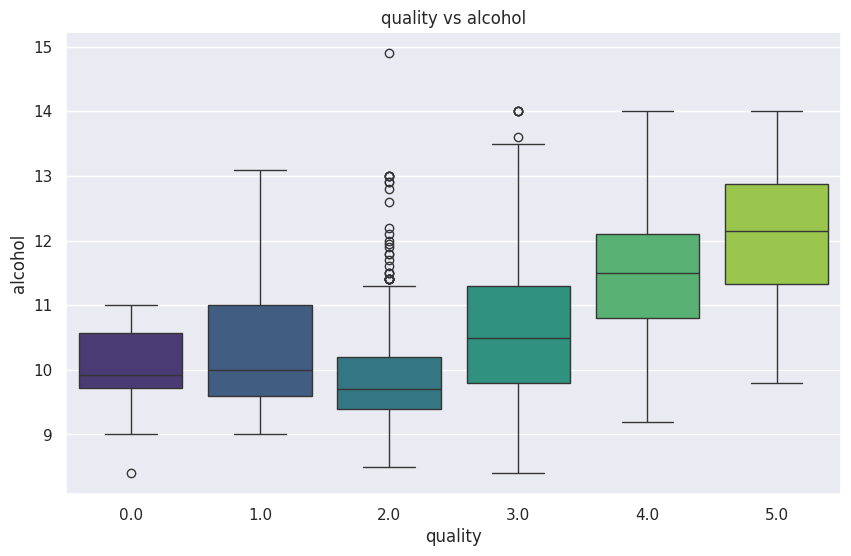

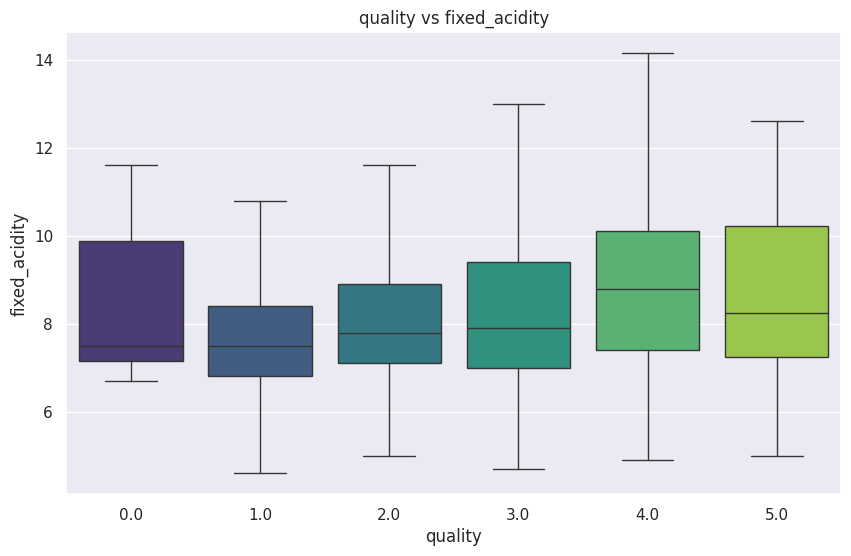

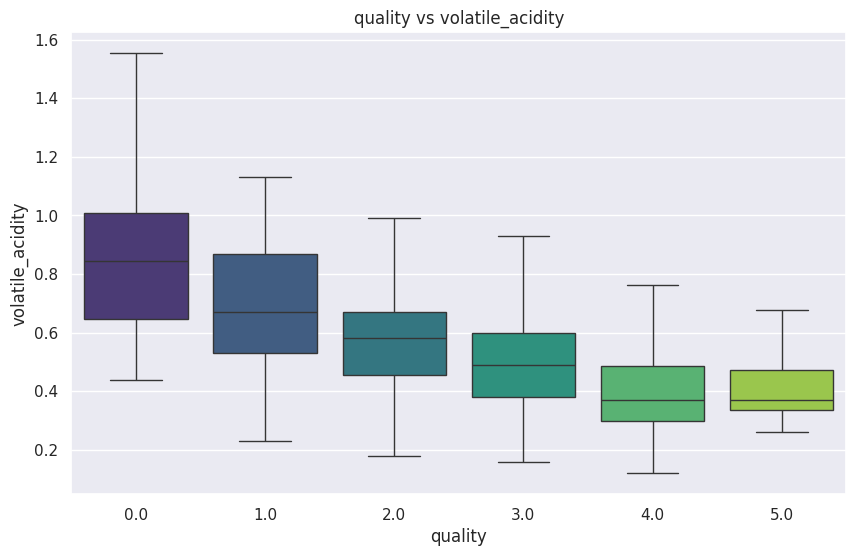

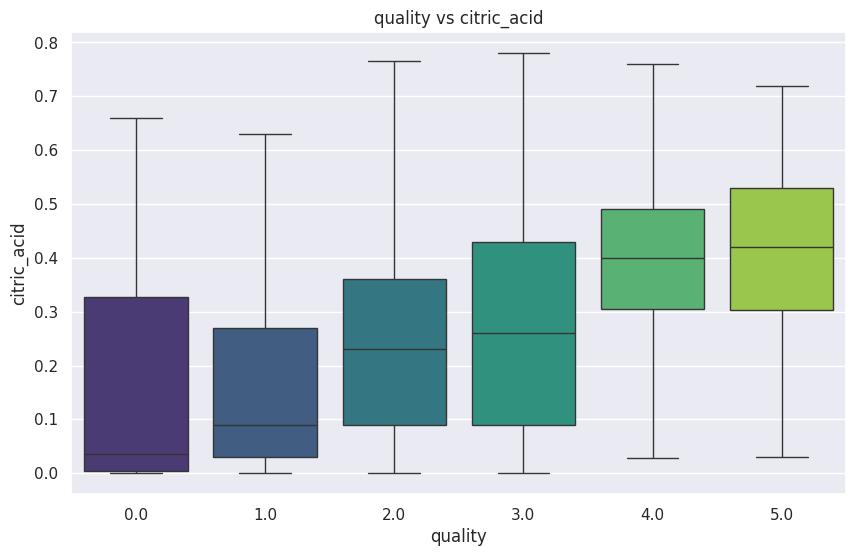

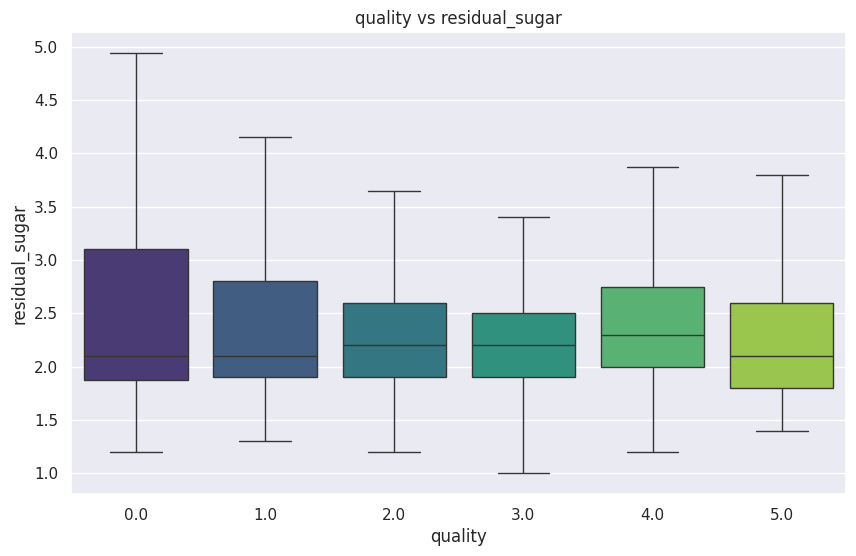

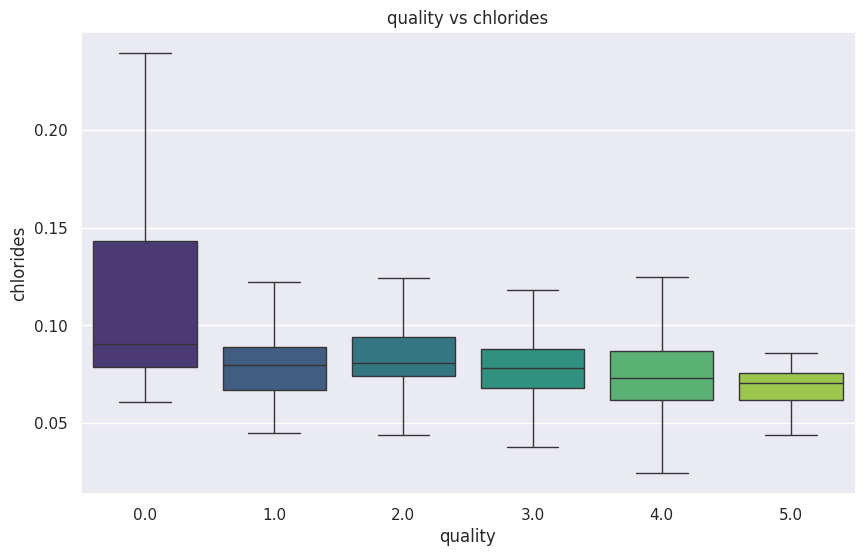

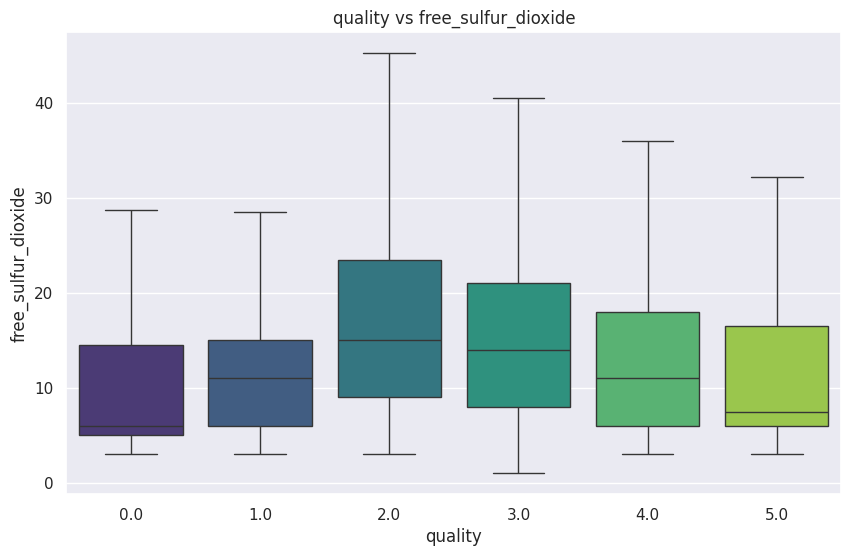

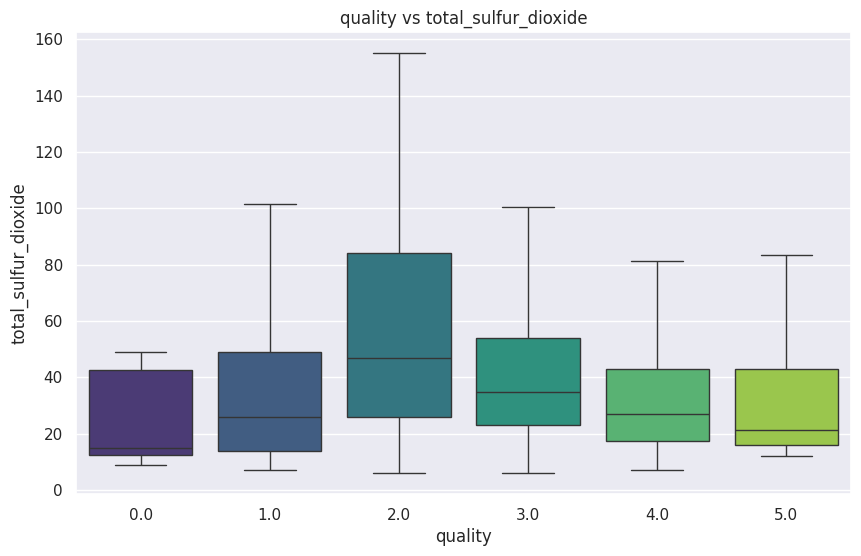

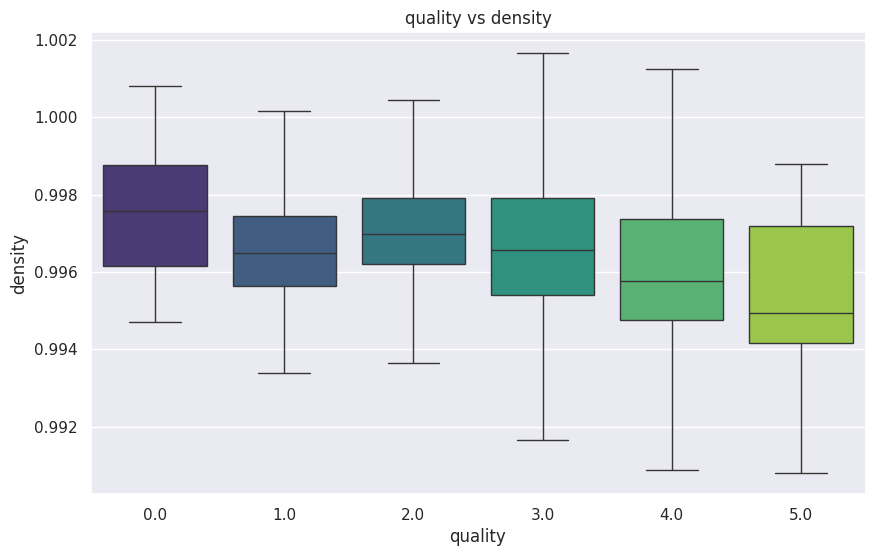

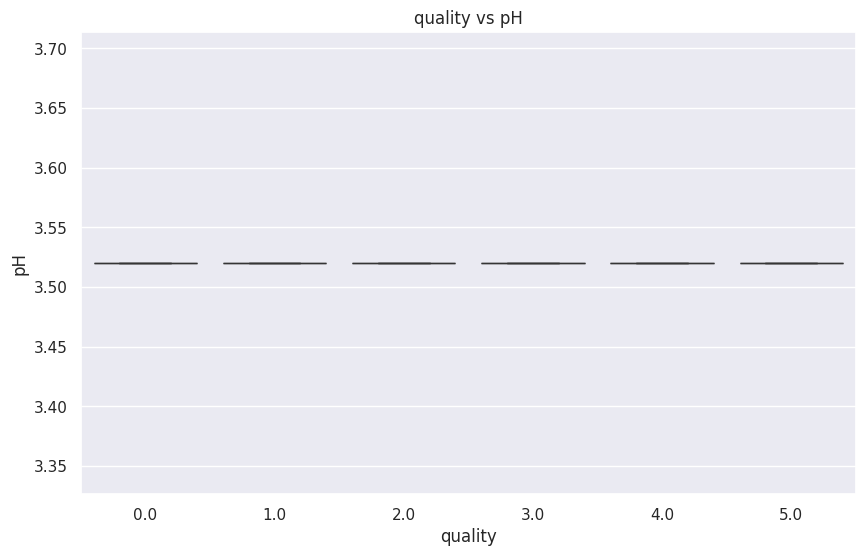

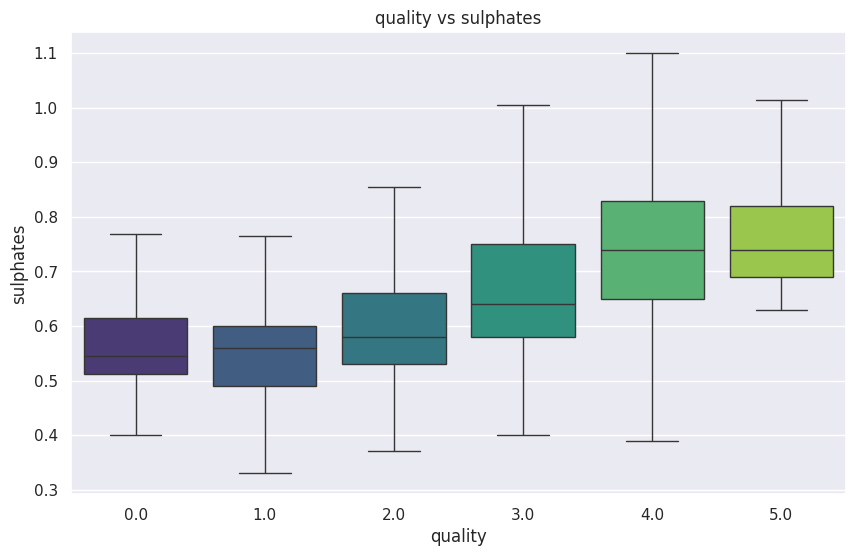

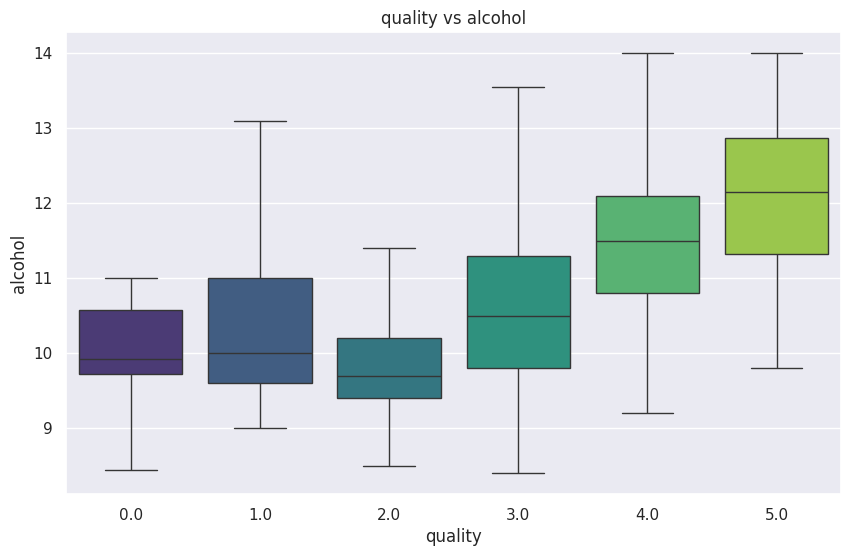

In [172]:
for col in num_cols:
    df = replace_with_thresholds_per_categoric(df, col, 'quality')
    plot_boxplots(df, num_cols, cat_cols)

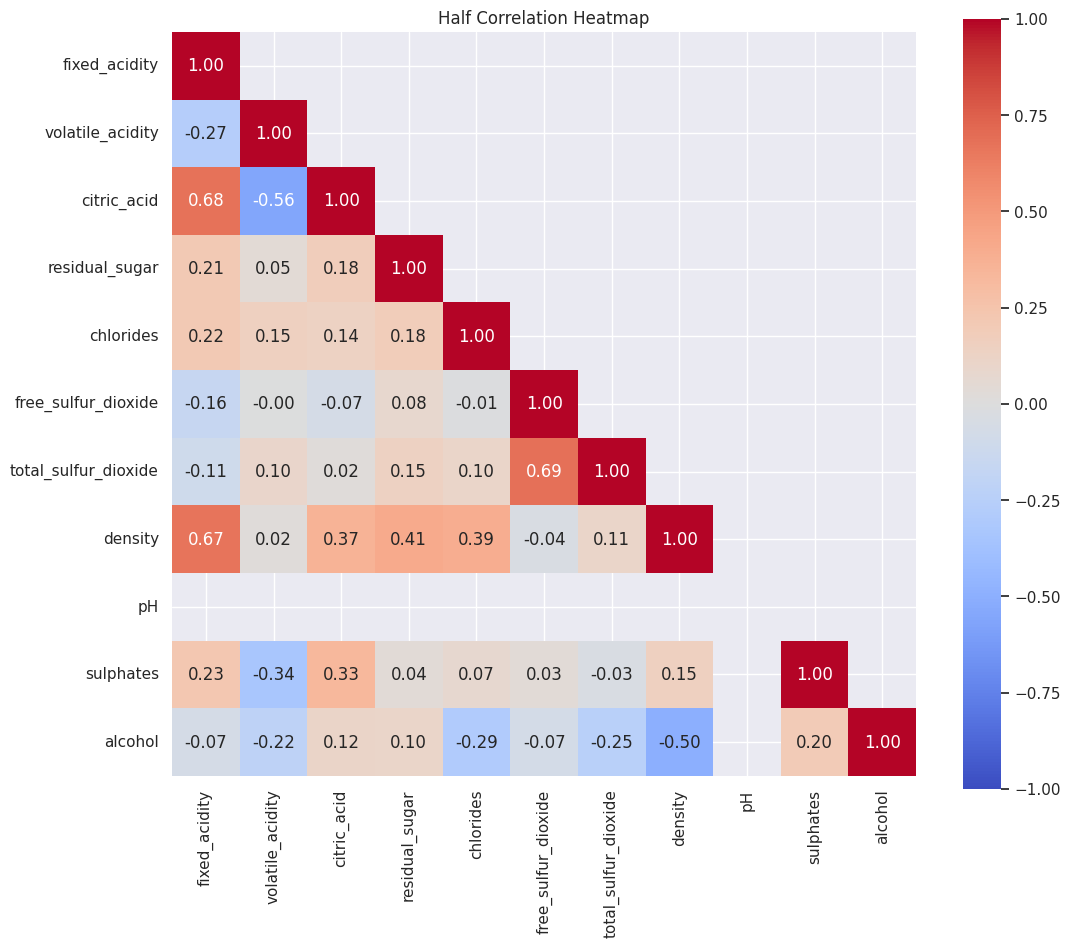

Empty DataFrame
Columns: [Variable 1, Variable 2, Correlation]
Index: []

In [173]:
def plot_correlation_heatmap(dataframe, threshold=0.9):
    numerical_df = dataframe[num_cols]

    corr_matrix = numerical_df.corr()

    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, center=0, square=True)
    plt.title('Half Correlation Heatmap')
    plt.show()

    mask_lower_triangle = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    filtered_corr = corr_matrix.where(mask_lower_triangle)

    high_corr = filtered_corr.stack().reset_index()
    high_corr.columns = ['Variable 1', 'Variable 2', 'Correlation']
    high_corr = high_corr[(high_corr['Correlation'].abs() > threshold) & (high_corr['Correlation'] != 1.0)]

    return high_corr
plot_correlation_heatmap(df, threshold = 0.9)

In [174]:
X = df.drop('quality', axis = 1)
y = df['quality']

In [175]:
results = sm.OLS(y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     107.8
Date:                Fri, 04 Oct 2024   Prob (F-statistic):          1.21e-170
Time:                        16:42:00   Log-Likelihood:                -1509.8
No. Observations:                1596   AIC:                             3042.
Df Residuals:                    1585   BIC:                             3101.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
fixed_acidity            0.0937 

In [176]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [177]:
X_with_const = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data['Variable'] = X_with_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

print(vif_data)

                Variable           VIF
0          fixed_acidity       3.65867
1       volatile_acidity       1.81346
2            citric_acid       2.93855
3         residual_sugar       1.70528
4              chlorides       1.26694
5    free_sulfur_dioxide       2.03922
6   total_sulfur_dioxide       2.26637
7                density       4.79525
8                     pH 1445327.30114
9              sulphates       1.32049
10               alcohol       2.55805


In [178]:
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X)
print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")
from statsmodels.miscmodels.ordinal_model import OrderedModel
from statsmodels.discrete.discrete_model import MNLogit
def multinomial_logistic_regression_no_intercept(X, y):
    model = MNLogit(y, X)
    result = model.fit()

    print(result.summary())

    return result

Explained Variance Ratio: [9.50647952e-01 4.54857972e-02 2.56037309e-03 9.42591475e-04
 3.07915176e-04 3.33677305e-05 1.25507295e-05 9.19031921e-06
 2.62024704e-07 6.43030854e-10 5.11908385e-17]


In [179]:
multinomial_logistic_regression_no_intercept(X, y)

Optimization terminated successfully.
         Current function value: 0.870659
         Iterations 28
                          MNLogit Regression Results                          
Dep. Variable:                quality   No. Observations:                 1596
Model:                        MNLogit   Df Residuals:                     1541
Method:                           MLE   Df Model:                           50
Date:                Fri, 04 Oct 2024   Pseudo R-squ.:                  0.2654
Time:                        16:42:01   Log-Likelihood:                -1389.6
converged:                       True   LL-Null:                       -1891.6
Covariance Type:            nonrobust   LLR p-value:                1.043e-177
           quality=1       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
fixed_acidity            0.1618      0.632      0.256      0.798      -1.077       1.40

In [180]:
rf = RandomForestClassifier(criterion = 'entropy')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 40)
Mm = MinMaxScaler()
X_train = Mm.fit_transform(X_train)
X_test = Mm.transform(X_test)
rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy')

In [181]:
y_pred_rf = rf.predict(X_test)
accuracy_score(y_test, y_pred_rf)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.00      0.00      0.00        10
         2.0       0.75      0.89      0.82       129
         3.0       0.67      0.73      0.70       123
         4.0       0.70      0.45      0.55        51
         5.0       0.00      0.00      0.00         5

    accuracy                           0.71       320
   macro avg       0.35      0.35      0.34       320
weighted avg       0.67      0.71      0.69       320



     Value               Feature
10 0.17300               alcohol
9  0.11698             sulphates
1  0.11164      volatile_acidity
6  0.10287  total_sulfur_dioxide
3  0.09321        residual_sugar
7  0.09027               density
4  0.08593             chlorides
2  0.08081           citric_acid
0  0.07879         fixed_acidity
5  0.06650   free_sulfur_dioxide
8  0.00000                    pH


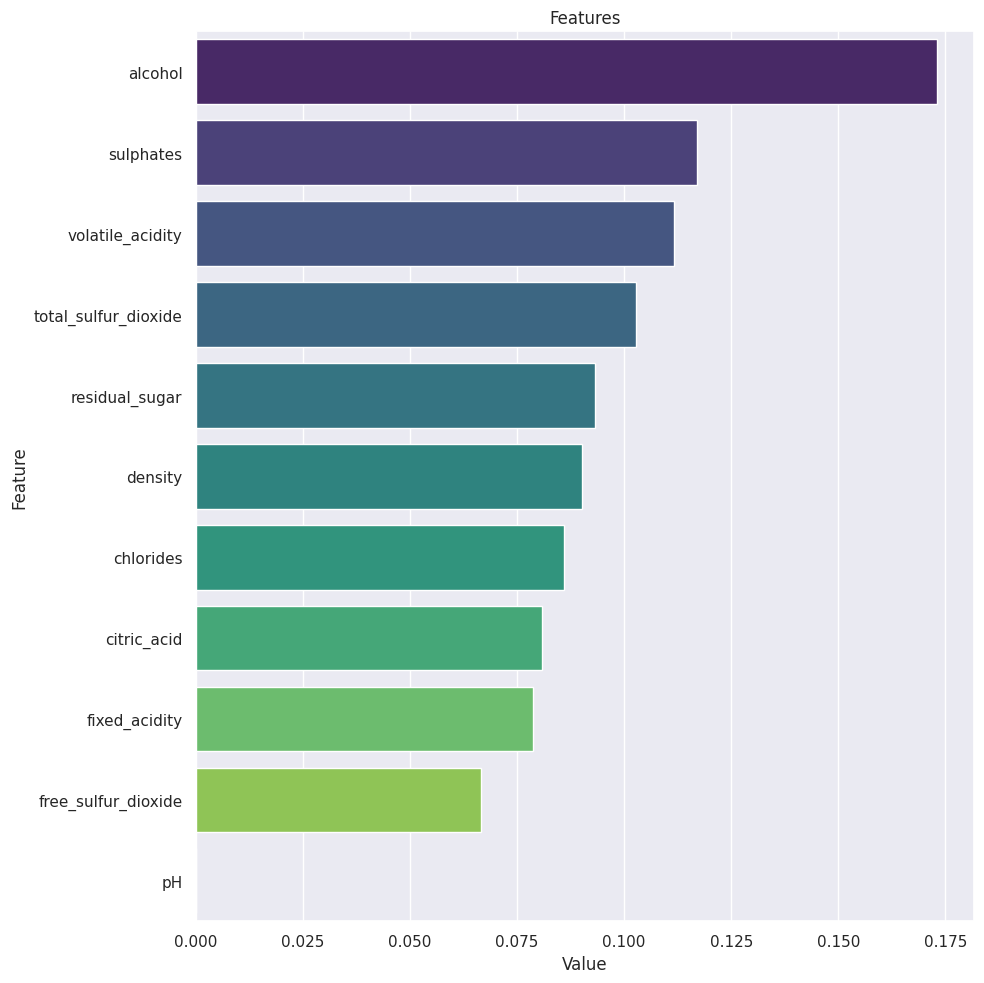

In [182]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    print(feature_imp.sort_values("Value",ascending=False))
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num], palette = 'viridis')
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')
plot_importance(rf, X)

In [211]:
explainer_rf = shap.TreeExplainer(rf)
shap_values_rf = explainer_rf.shap_values(X_train)

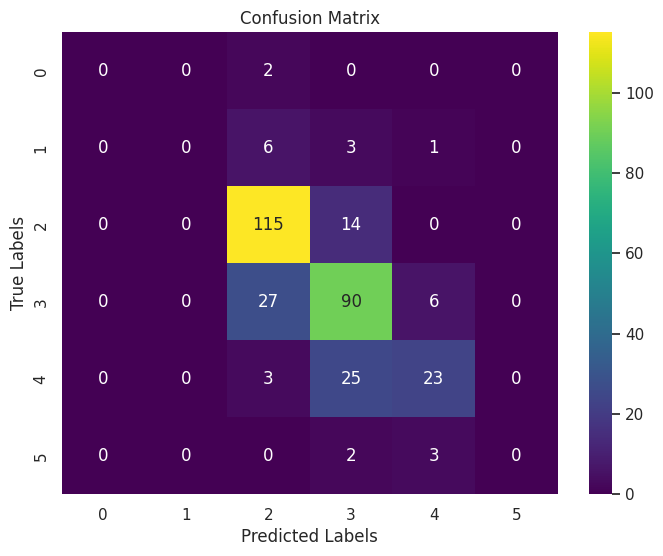

In [186]:
def create_confusion_matrix(actual, predicted, class_labels : list):
    cm = confusion_matrix(actual, predicted)
    class_labels = class_labels
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='viridis', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
create_confusion_matrix(y_test, y_pred_rf, class_labels = ['0', '1', '2', '3', '4', '5'])

In [187]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
accuracy_score(y_test, xgb_pred)

0.746875

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.00      0.00      0.00        10
         2.0       0.75      0.89      0.82       129
         3.0       0.67      0.73      0.70       123
         4.0       0.70      0.45      0.55        51
         5.0       0.00      0.00      0.00         5

    accuracy                           0.71       320
   macro avg       0.35      0.35      0.34       320
weighted avg       0.67      0.71      0.69       320

     Value               Feature
10 0.22721               alcohol
3  0.12430        residual_sugar
9  0.10625             sulphates
1  0.09149      volatile_acidity
6  0.09095  total_sulfur_dioxide
4  0.07742             chlorides
0  0.07723         fixed_acidity
2  0.07681           citric_acid
5  0.06753   free_sulfur_dioxide
7  0.06081               density
8  0.00000                    pH


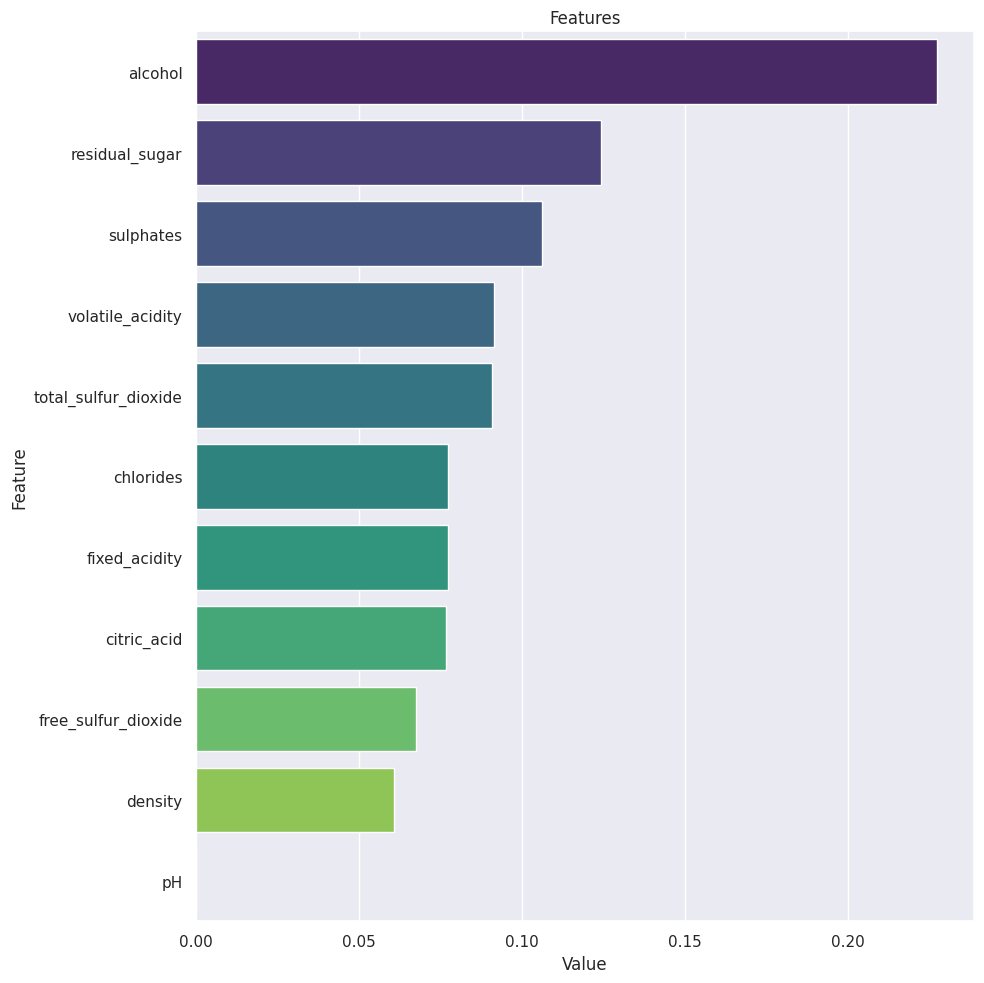

In [189]:
print(classification_report(y_test, y_pred_rf))
plot_importance(xgb, X)
explainer_xgb = shap.TreeExplainer(xgb)
shap_values_xgb = explainer_xgb.shap_values(X_train)

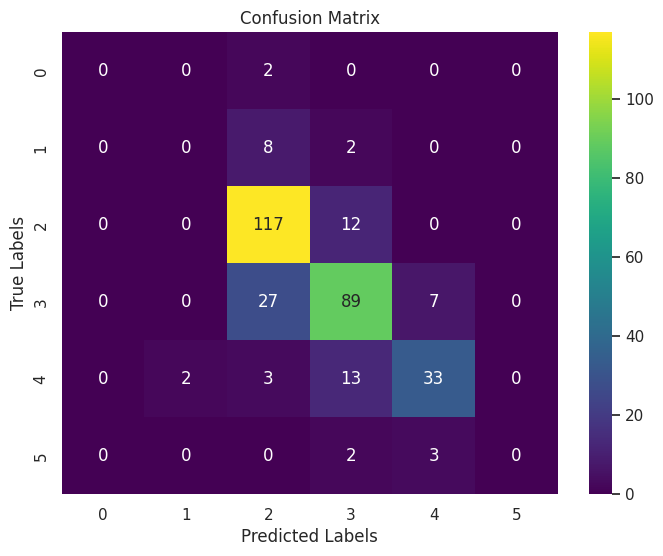

In [190]:
create_confusion_matrix(y_test, xgb_pred, class_labels = ['0', '1', '2', '3', '4', '5'])

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.50      0.20      0.29        10
         2.0       0.77      0.93      0.85       129
         3.0       0.72      0.74      0.73       123
         4.0       0.83      0.57      0.67        51
         5.0       0.00      0.00      0.00         5

    accuracy                           0.76       320
   macro avg       0.47      0.41      0.42       320
weighted avg       0.74      0.76      0.74       320

    Value               Feature
1    2241      volatile_acidity
4    1974             chlorides
6    1945  total_sulfur_dioxide
9    1927             sulphates
7    1784               density
10   1697               alcohol
0    1585         fixed_acidity
2    1538           citric_acid
3    1429        residual_sugar
5    1221   free_sulfur_dioxide
8       0                    pH


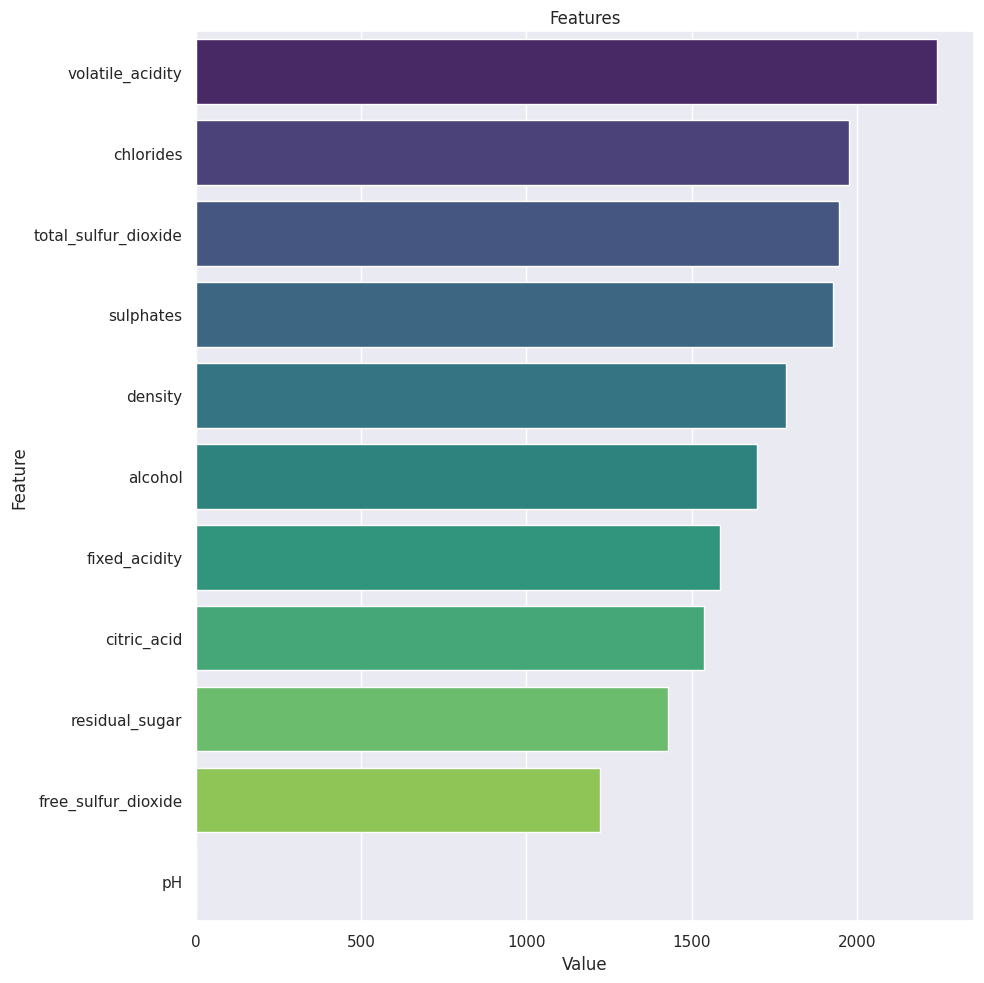

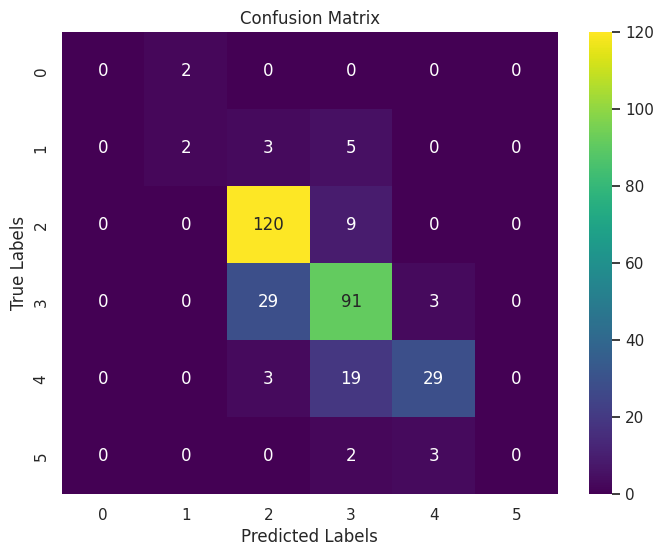

In [193]:
gb = LGBMClassifier(verbose = -1)
gb.fit(X_train, y_train)
lgb_pred = gb.predict(X_test)
accuracy_score(y_test, lgb_pred)
print(classification_report(y_test, lgb_pred))
plot_importance(gb, X)
explainer_lgb = shap.TreeExplainer(gb)
shap_values_lgb = explainer_lgb.shap_values(X_train)
create_confusion_matrix(y_test, lgb_pred, class_labels = ['0', '1', '2', '3', '4', '5'])

In [198]:
!pip install lightgbm
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
lgb = LGBMClassifier(verbose = -1)
cv_scores = cross_val_score(lgb, X, y, cv = 5, scoring = 'accuracy')
print(f'mean of cross validation scores: {cv_scores.mean():.4f}, and std: {cv_scores.std()}')

mean of cross validation scores: 0.6397, and std: 0.008115703255199854


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.00      0.00      0.00        10
         2.0       0.75      0.89      0.82       129
         3.0       0.67      0.73      0.70       123
         4.0       0.70      0.45      0.55        51
         5.0       0.00      0.00      0.00         5

    accuracy                           0.71       320
   macro avg       0.35      0.35      0.34       320
weighted avg       0.67      0.71      0.69       320



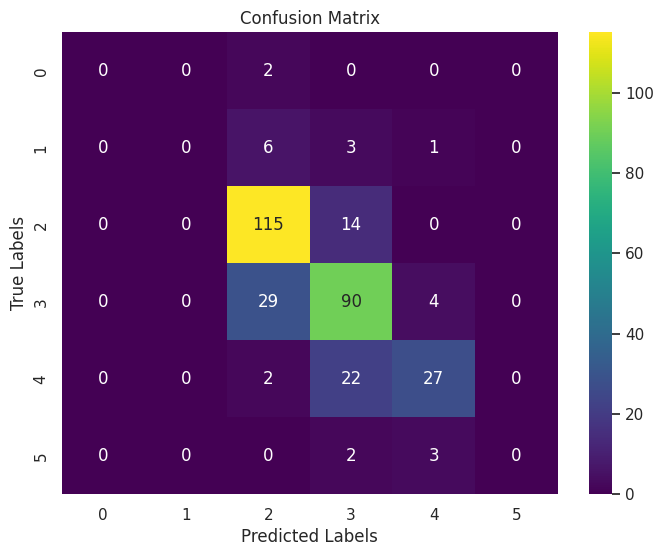

In [197]:
cb = CatBoostClassifier(verbose = False)
cb.fit(X_train, y_train)
cb_pred = cb.predict(X_test)
accuracy_score(y_test, cb_pred)
print(classification_report(y_test, y_pred_rf))
explainer_cb = shap.TreeExplainer(cb)
shap_values_cb = explainer_cb.shap_values(X_train)
create_confusion_matrix(y_test, cb_pred, class_labels = ['0', '1', '2', '3', '4', '5'])

In [199]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, input_shape=(X_train.shape[1],), activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(8, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),

    tf.keras.layers.Dense(6, activation="softmax")
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                      │ (None, 128)                 │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 6)                   │              54 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,110 (305.12 KB)

 Trainable params: 78,110 (305.12 KB)

 Non-trainable params: 0 (0.00 B)

In [200]:
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=64,
                    callbacks=[early_stopping,
                               tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                                     factor=0.1,
                                                                     patience=5,
                                                                     min_lr=1e-6)],
                    verbose=2)

Epoch 1/100
16/16 - 12s - 740ms/step - accuracy: 0.3912 - loss: 2.0770 - val_accuracy: 0.3984 - val_loss: 1.8777 - learning_rate: 0.0010
Epoch 2/100
16/16 - 0s - 24ms/step - accuracy: 0.4353 - loss: 1.8581 - val_accuracy: 0.3984 - val_loss: 1.7985 - learning_rate: 0.0010
Epoch 3/100
16/16 - 1s - 40ms/step - accuracy: 0.4235 - loss: 1.7578 - val_accuracy: 0.3984 - val_loss: 1.6470 - learning_rate: 0.0010
Epoch 4/100
16/16 - 0s - 18ms/step - accuracy: 0.4510 - loss: 1.6208 - val_accuracy: 0.4570 - val_loss: 1.5535 - learning_rate: 0.0010
Epoch 5/100
16/16 - 0s - 25ms/step - accuracy: 0.4598 - loss: 1.5303 - val_accuracy: 0.4531 - val_loss: 1.4708 - learning_rate: 0.0010
Epoch 6/100
16/16 - 0s - 16ms/step - accuracy: 0.4637 - loss: 1.4498 - val_accuracy: 0.4453 - val_loss: 1.3821 - learning_rate: 0.0010
Epoch 7/100
16/16 - 0s - 17ms/step - accuracy: 0.5069 - loss: 1.3748 - val_accuracy: 0.4961 - val_loss: 1.3095 - learning_rate: 0.0010
Epoch 8/100
16/16 - 0s - 22ms/step - accuracy: 0.5461

In [201]:
loss_and_metrics = model.evaluate(X_test, y_test)
print('Loss = ',loss_and_metrics[0])
print('Accuracy = ',loss_and_metrics[1])

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5805 - loss: 0.9970
Loss =  1.0229449272155762
Accuracy =  0.574999988079071


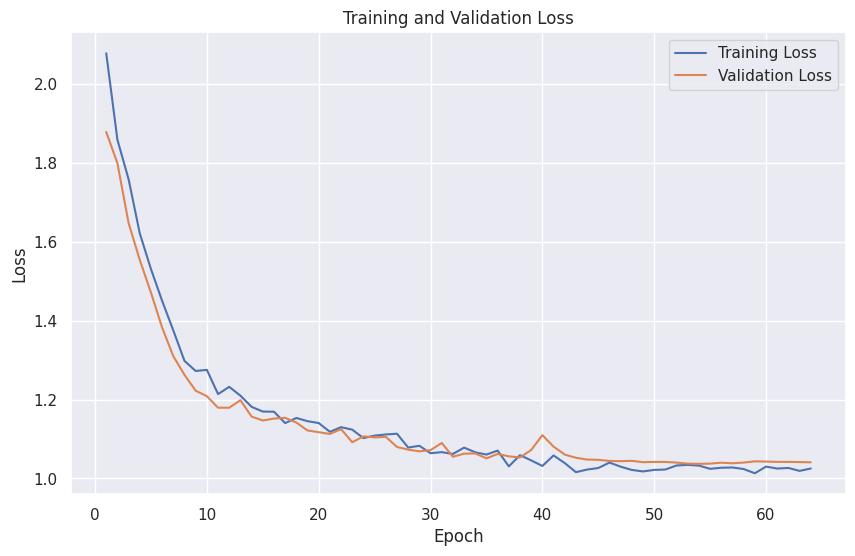

In [202]:
plt.figure(figsize=(10, 6))

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [207]:
!pip install flaml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.3/313.3 kB 8.0 MB/s eta 0:00:00


In [209]:
from flaml import AutoML
from flaml import tune
automl = AutoML()
models = {
    'lgbm': lgb,
    'xgboost': xgb,
    'catboost': cb,
}
automl.fit(
    X_train=X_train,
    y_train=y_train,
    task='classification',
    metric='accuracy',
    estimator_list=models
)

[flaml.automl.logger: 10-04 17:17:08] {1728} INFO - task = classification
[flaml.automl.logger: 10-04 17:17:08] {1739} INFO - Evaluation method: cv


INFO:flaml.automl.task.generic_task:class 0 augmented from 8 to 24
INFO:flaml.automl.task.generic_task:class 5 augmented from 13 to 26


[flaml.automl.logger: 10-04 17:17:08] {1838} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 10-04 17:17:08] {1861} WARNING - No search budget is provided via time_budget or max_iter. Training only one model per estimator. Zero-shot AutoML is used for certain tasks and estimators. To tune hyperparameters for each estimator, please provide budget either via time_budget or max_iter.


INFO:flaml.default.suggest:metafeature distance: 0.16735405485389193
INFO:flaml.default.suggest:metafeature distance: 0.16738273770581366
INFO:flaml.default.suggest:metafeature distance: 0.16735405485389193


[flaml.automl.logger: 10-04 17:17:08] {1955} INFO - List of ML learners in AutoML Run: ['xgboost', 'lgbm', 'catboost']
[flaml.automl.logger: 10-04 17:17:08] {2258} INFO - iteration 0, current learner xgboost
[flaml.automl.logger: 10-04 17:17:28] {2393} INFO - Estimated sufficient time budget=10000s. Estimated necessary time budget=10s.
[flaml.automl.logger: 10-04 17:17:28] {2442} INFO -  at 19.8s,	estimator xgboost's best error=0.2659,	best estimator xgboost's best error=0.2659
[flaml.automl.logger: 10-04 17:17:28] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 10-04 17:17:32] {2442} INFO -  at 24.5s,	estimator lgbm's best error=0.3011,	best estimator xgboost's best error=0.2659
[flaml.automl.logger: 10-04 17:17:32] {2258} INFO - iteration 2, current learner catboost
[flaml.automl.logger: 10-04 17:17:37] {2442} INFO -  at 29.7s,	estimator catboost's best error=0.3211,	best estimator xgboost's best error=0.2659
[flaml.automl.logger: 10-04 17:17:40] {2685} INFO - r

In [210]:
y_pred = automl.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy
print(f"Best model: {automl.best_estimator}")
print(f"Accuracy: {accuracy}")
print(f"Best hyperparameters: {automl.best_config}")

Best model: xgboost
Accuracy: 0.759375
Best hyperparameters: {'n_estimators': 392, 'max_leaves': 46, 'min_child_weight': 0.20655273911443411, 'learning_rate': 0.08039123467849849, 'subsample': 0.6482821473906787, 'colsample_bylevel': 0.5448604029329934, 'colsample_bytree': 0.4211786481671673, 'reg_alpha': 0.029040644754759502, 'reg_lambda': 4.60220206538413}
